In [759]:
# Introduction

# This notebook aims to predict ICU mortality using the GOSSIS dataset.
# The goal is to build a machine learning model that generalizes across diverse healthcare settings,
# providing clinicians with actionable insights to improve patient care globally.




In [760]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


In [761]:
# --- Cell 1: Load Dataset and Initial Cleaning ---


# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83', 'gcs_unable_apache']
data.drop(columns=cols_to_drop, inplace=True)

# **Step 1: Replace "Undefined diagnoses" with "Undefined Diagnoses" in 'apache_2_bodysystem'**
# This ensures consistency in category naming
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display the first few rows to verify
print("Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:")
print(data.head())


Data after dropping unnecessary columns, replacing category names, and saving Apache probabilities:
    age    bmi  elective_surgery  ethnicity gender  height  \
0  68.0  22.73                 0  Caucasian      M   180.3   
1  77.0  27.42                 0  Caucasian      F   160.0   
2  25.0  31.95                 0  Caucasian      F   172.7   
3  81.0  22.64                 1  Caucasian      F   165.1   
4  19.0    NaN                 0  Caucasian      M   188.0   

            icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                      Floor         admit         CTICU          0.541667   
1                      Floor         admit  Med-Surg ICU          0.927778   
2       Accident & Emergency         admit  Med-Surg ICU          0.000694   
3  Operating Room / Recovery         admit         CTICU          0.000694   
4       Accident & Emergency         admit  Med-Surg ICU          0.073611   

   ...  cirrhosis  diabetes_mellitus  hepatic_failure  imm

In [762]:
# Set display options to show all rows for missing values
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)

# Calculate and display missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing Values in Each Column:")
print(missing_values)

# Reset display options back to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')


Missing Values in Each Column:
age                            4228
bmi                            3429
ethnicity                      1395
gender                           25
height                         1334
icu_admit_source                112
weight                         2720
apache_2_diagnosis             1662
apache_3j_diagnosis            1101
arf_apache                      715
gcs_eyes_apache                1901
gcs_motor_apache               1901
gcs_verbal_apache              1901
heart_rate_apache               878
intubated_apache                715
map_apache                      994
resprate_apache                1234
temp_apache                    4108
ventilated_apache               715
d1_diasbp_max                   165
d1_diasbp_min                   165
d1_diasbp_noninvasive_max      1040
d1_diasbp_noninvasive_min      1040
d1_heartrate_max                145
d1_heartrate_min                145
d1_mbp_max                      220
d1_mbp_min                      2

In [763]:
# Drop any rows that have missing values
data.dropna(inplace=True)

# Alternative strategies (commented for reference):
# 1. **Impute Numerical Features:**
#    - Use mean, median, or mode to fill missing values.
# 2. **Impute Categorical Features:**
#    - Fill missing values with the most frequent category or 'Unknown'.
# 3. **Advanced Imputation Techniques:**
#    - Use K-Nearest Neighbors (KNN) or Multiple Imputation by Chained Equations (MICE).


print(f"\nData shape before dropping missing values: {data.shape}")
print(f"Data shape after dropping missing values: {data.shape}")



Data shape before dropping missing values: (61955, 77)
Data shape after dropping missing values: (61955, 77)


In [764]:
# Handle comorbidity variables
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Ensure comorbidity variables are integers
data[comorbidity_vars] = data[comorbidity_vars].astype(int)

# Compute comorbidity count
data['comorbidity_count'] = data[comorbidity_vars].sum(axis=1)

# Handle GCS (Glasgow Coma Scale) variables
gcs_vars = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

# Convert GCS variables to numeric if not already
data[gcs_vars] = data[gcs_vars].apply(pd.to_numeric)

# Compute GCS total
data['gcs_total'] = data[gcs_vars].sum(axis=1)

# Re-express categorical variables by combining certain categories

# Ethnicity: Combine 'Asian', 'Native American', 'Other/Unknown' into 'Other'
ethnicities_to_combine = ['Asian', 'Native American', 'Other/Unknown']
data['ethnicity'] = data['ethnicity'].apply(
    lambda x: x if x not in ethnicities_to_combine else 'Other'
)

# ICU Admit Source: Combine 'Other ICU' into 'Other'
icu_admit_sources_to_combine = ['Other ICU']
data['icu_admit_source'] = data['icu_admit_source'].apply(
    lambda x: x if x not in icu_admit_sources_to_combine else 'Other'
)

# ICU Type: Combine 'SICU', 'CTICU', 'CSICU' into 'Other'
icu_types_to_combine = ['SICU', 'CTICU', 'CSICU']
data['icu_type'] = data['icu_type'].apply(
    lambda x: x if x not in icu_types_to_combine else 'Other'
)

# APACHE 3J Bodysystem: Combine specific categories into 'Other'
apache_3j_bodysystem_to_combine = [
    'Gynecological',
    'Musculoskeletal/Skin',
    'Hematological',
    'Genitourinary',
    'Trauma',
    'Metabolic'
]
data['apache_3j_bodysystem'] = data['apache_3j_bodysystem'].apply(
    lambda x: x if x not in apache_3j_bodysystem_to_combine else 'Other'
)

# Drop individual comorbidity and GCS columns since we have the totals
data.drop(columns=comorbidity_vars + gcs_vars, inplace=True)

# Display the first few rows to verify feature engineering
print("Data after Feature Engineering:")
print(data.head())


Data after Feature Engineering:
     age        bmi  elective_surgery  ethnicity gender  height  \
0   68.0  22.730000                 0  Caucasian      M   180.3   
1   77.0  27.420000                 0  Caucasian      F   160.0   
5   67.0  27.560000                 0  Caucasian      M   190.5   
10  72.0  28.257052                 1   Hispanic      F   154.9   
17  46.0  25.845717                 0   Hispanic      M   167.6   

             icu_admit_source icu_stay_type      icu_type  pre_icu_los_days  \
0                       Floor         admit         Other          0.541667   
1                       Floor         admit  Med-Surg ICU          0.927778   
5        Accident & Emergency         admit  Med-Surg ICU          0.000694   
10  Operating Room / Recovery         admit  Med-Surg ICU          0.004861   
17       Accident & Emergency         admit         Other          0.000000   

    ...  h1_sysbp_noninvasive_min  d1_glucose_max  d1_glucose_min  \
0   ...              

### PCA Exploration

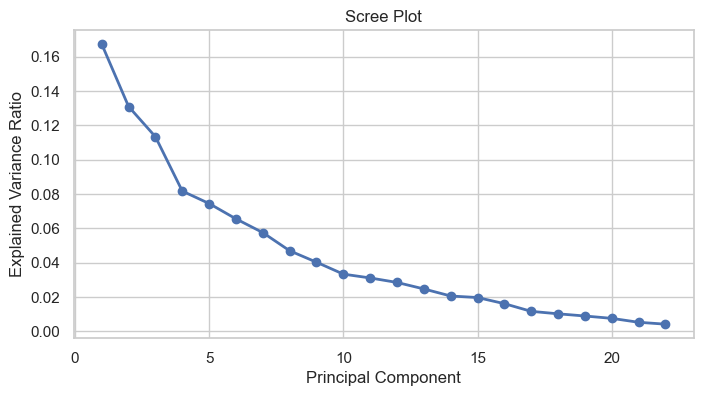

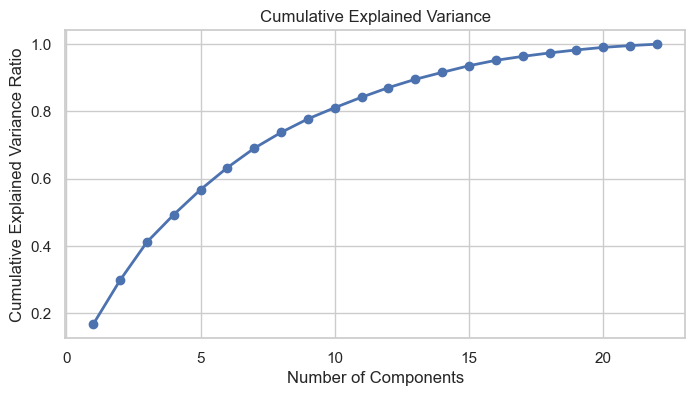

PCA Components for Physiological Data:


heart_rate_apache  d1_heartrate_max  d1_heartrate_min  map_apache  \
0           -0.024173         -0.053860          0.005509    0.361819   
1            0.474967          0.486747          0.352561    0.047024   
2            0.049887         -0.051165          0.236544   -0.147511   
3            0.133337          0.075783          0.186281    0.013500   
4            0.101303          0.100096          0.040425   -0.017877   
5           -0.248927         -0.217292         -0.247858   -0.010381   
6           -0.197639         -0.169680         -0.178828   -0.037185   
7            0.052839          0.041558          0.035626    0.002199   
8            0.041298          0.081554         -0.121163    0.003756   
9           -0.117091         -0.107555         -0.035810    0.083432   
10          -0.030369         -0.012312         -0.009364    0.057424   
11          -0.023568         -0.046690          0.136581   -0.115312   
12           0.024903         -0.052767          0.008763    0.889473   
13           0.217043          0.207291         -0.182429    0.056503   
14           0.272146          0.327075         -0.776302   -0.049002   
15          -0.050280          0.107285         -0.088525    0.120677   
16          -0.062661          0.004723          0.040566   -0.043202   
17          -0.106506          0.048244          0.059329   -0.012873   
18          -0.036618          0.046504          0.010717    0.010017   
19          -0.693698          0.686841          0.068894    0.039903   
20           0.019272         -0.052456         -0.004210    0.066927   
21          -0.007937          0.015952         -0.010616   -0.005161   

    d1_mbp_max  d1_mbp_min  d1_sysbp_max  d1_sysbp_min  d1_diasbp_max  \
0     0.368590    0.415601      0.344996      0.395813       0.291203   
1     0.131540   -0.099679      0.062089     -0.139991       0.151525   
2    -0.341428    0.228807     -0.297538      0.206163      -0.353695   
3    -0.136675    0.174579     -0.144751      0.104619      -0.184357   
4    -0.030163    0.009688     -0.078316     -0.043207      -0.016722   
5     0.019174   -0.023505     -0.003584     -0.051360      -0.067789   
6     0.000610   -0.095223      0.089363     -0.021897      -0.044503   
7     0.056578   -0.086911      0.000736     -0.063466       0.124111   
8    -0.159673    0.252015     -0.116399      0.142735      -0.217941   
9    -0.058104    0.038751      0.089704      0.122952      -0.087289   
10    0.018295   -0.027587      0.046403     -0.034087      -0.050448   
11    0.046718   -0.002404      0.013833      0.005869       0.040419   
12   -0.119557   -0.102894     -0.241519     -0.186771      -0.182036   
13   -0.172269   -0.062918      0.555490      0.390560      -0.452148   
14   -0.000231    0.085761     -0.193046     -0.124988       0.078585   
15   -0.095052   -0.006071     -0.061465      0.015318       0.024778   
16    0.004994    0.006163      0.074798     -0.029218      -0.029133   
17   -0.000688    0.065728      0.485051     -0.645388      -0.352995   
18    0.000382   -0.005936     -0.039784      0.070133       0.011860   
19   -0.058156    0.006205     -0.055849      0.090391       0.032290   
20   -0.699328   -0.348291      0.254559      0.088496       0.451877   
21    0.360896   -0.709779     -0.106072      0.288113      -0.276410   

    d1_diasbp_min  ...  d1_resprate_min  temp_apache  d1_temp_max  \
0        0.380201  ...         0.066714     0.058394    -0.045063   
1       -0.073030  ...         0.117481     0.197866     0.288057   
2        0.235284  ...         0.244699     0.326492     0.110377   
3        0.166604  ...         0.253779    -0.407387    -0.303238   
4        0.040708  ...         0.021236    -0.309099    -0.108437   
5       -0.083192  ...         0.229043     0.082031    -0.001945   
6       -0.149569  ...         0.062970     0.110644     0.042925   
7       -0.059415  ...         0.133590     0.005144    -0.144485   
8        0.263019  ... 

In [765]:
# List of physiological variables
physiological_vars = [
    'heart_rate_apache', 'd1_heartrate_max', 'd1_heartrate_min',
    'map_apache', 'd1_mbp_max', 'd1_mbp_min',
    'd1_sysbp_max', 'd1_sysbp_min',
    'd1_diasbp_max', 'd1_diasbp_min',
    'resprate_apache', 'd1_resprate_max', 'd1_resprate_min',
    'temp_apache', 'd1_temp_max', 'd1_temp_min',
    'd1_spo2_max', 'd1_spo2_min',
    'd1_glucose_max', 'd1_glucose_min',
    'd1_potassium_max', 'd1_potassium_min',
    'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache'
]

# Ensure all variables are in the dataset
physiological_vars = [var for var in physiological_vars if var in data.columns]

# Extract the physiological data
physio_data = data[physiological_vars]
physio_data = physio_data.dropna()



# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
physio_data_scaled = scaler.fit_transform(physio_data)


# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(physio_data_scaled)

# Transform the data
physio_pca = pca.transform(physio_data_scaled)

# Calculate explained variance ratios
explained_variance = pca.explained_variance_ratio_

# Generate scree plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Get PCA components for physiological data
physio_components = pd.DataFrame(pca.components_, columns=physio_data.columns)
print("PCA Components for Physiological Data:")
display(physio_components)

Data retained after dropping missing values: 100.00%


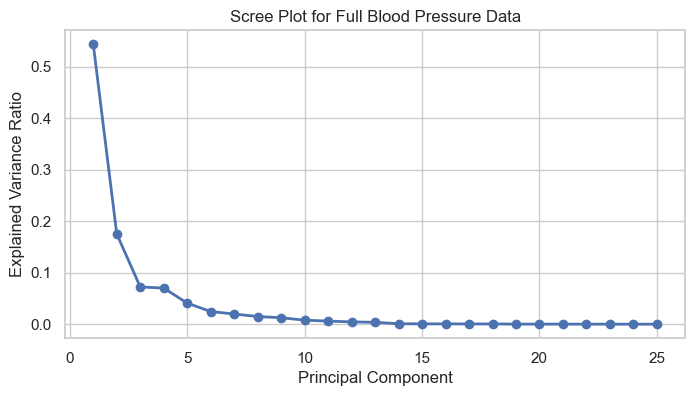

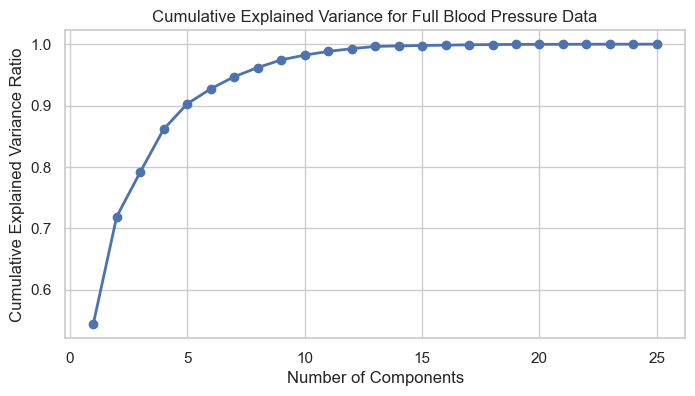

PCA Components for Full Blood Pressure Data:


map_apache  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  \
0     0.161973    0.191893    0.186344                0.191838   
1     0.050544    0.256807   -0.283366                0.256122   
2    -0.126929   -0.100814   -0.094219               -0.101880   
3    -0.197137   -0.233208   -0.210562               -0.233289   
4    -0.044247   -0.124238    0.131242               -0.125049   
5     0.869805    0.015583    0.005692                0.015459   
6     0.287050   -0.056352   -0.084088               -0.057308   
7    -0.272644    0.353088    0.177696                0.356768   
8    -0.019496   -0.025829   -0.025273               -0.023902   
9    -0.017564    0.269260   -0.444745                0.266380   
10   -0.002844   -0.066281    0.029186               -0.071697   
11   -0.014939    0.178730    0.283482                0.184724   
12    0.007445   -0.276745    0.018775               -0.280365   
13   -0.000349   -0.032194   -0.008012                0.039596   
14    0.001074   -0.186166    0.022796                0.189127   
15   -0.001074    0.653821   -0.065515               -0.648374   
16    0.002445    0.126722   -0.011146               -0.128311   
17    0.000945    0.020309    0.015421               -0.022271   
18   -0.000375    0.076868    0.515251               -0.073180   
19   -0.000301   -0.046497   -0.009645                0.045799   
20    0.000034    0.005200    0.007122               -0.009383   
21   -0.000857    0.113103   -0.102589               -0.110898   
22    0.000005    0.048076    0.462965               -0.047022   
23   -0.000046   -0.014514    0.008688                0.014797   
24   -0.000219   -0.000964   -0.007552                0.000894   

    d1_mbp_noninvasive_min  h1_mbp_max  h1_mbp_min  h1_mbp_noninvasive_max  \
0                 0.186451    0.232531    0.234665                0.232755   
1                -0.284009    0.109044   -0.116749                0.107984   
2                -0.093956    0.169258    0.136025                0.169394   
3                -0.210398    0.099394    0.136395                0.098257   
4                 0.130670    0.271130   -0.254122                0.270988   
5                 0.005020    0.105681    0.082909                0.103124   
6                -0.082817   -0.007264   -0.071009               -0.010549   
7                 0.176037    0.291664    0.214643                0.291735   
8                -0.023629    0.024577    0.055560                0.024315   
9                -0.436330    0.135108   -0.195255                0.132101   
10                0.029183    0.078490   -0.045959                0.079519   
11                0.283347   -0.056201   -0.447859               -0.050578   
12                0.017293    0.442288   -0.172310                0.448858   
13                0.002802   -0.230112   -0.129483                0.219218   
14               -0.025108   -0.283312    0.008690                0.282574   
15                0.071016   -0.008120   -0.004695                0.003529   
16                0.008888   -0.396707   -0.099734                0.401862   
17               -0.018331   -0.415797    0.030861                0.414368   
18               -0.518230   -0.012802    0.133450                0.010480   
19                0.009394   -0.166687   -0.053042                0.164227   
20               -0.006431    0.086217   -0.651935               -0.084986   
21                0.104154   -0.052197    0.092125                0.049682   
22               -0.467311    0.014945   -0.126628               -0.013994   
23               -0.009187   -0.000451   -0.001253                0.000635   
24                0.007263   -0.006069    0.010519                0.007075   

    h1_mbp_noninvasive_min  d1_sysbp_max  ...  h1_sysbp_noninvasive_max  \
0                 0.234753      0.186923  ...                  0.219277   
1                -0.117288      0.211937  ...                  0.109174   
2                 0.135936     -0

In [766]:
# List of all blood pressure variables, excluding 'mean' columns
bp_vars_full = [
    'map_apache',
    'd1_mbp_max', 'd1_mbp_min',
    'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
    'h1_mbp_max', 'h1_mbp_min',
    'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
    'd1_sysbp_max', 'd1_sysbp_min',
    'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
    'h1_sysbp_max', 'h1_sysbp_min',
    'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
    'd1_diasbp_max', 'd1_diasbp_min',
    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
    'h1_diasbp_max', 'h1_diasbp_min',
    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min'
]
# Ensure variables are in the dataset
bp_vars_full = [var for var in bp_vars_full if var in data.columns]
# Extract blood pressure data
bp_data_full = data[bp_vars_full]
# Drop rows with missing values
bp_data_full_clean = bp_data_full.dropna()

# Print the percentage of data retained
data_retained = len(bp_data_full_clean) / len(bp_data_full) * 100
print(f"Data retained after dropping missing values: {data_retained:.2f}%")

scaler = StandardScaler()
bp_data_scaled = scaler.fit_transform(bp_data_full_clean)

pca_bp_full = PCA()
pca_bp_full.fit(bp_data_scaled)
bp_pca_full = pca_bp_full.transform(bp_data_scaled)

explained_variance_bp_full = pca_bp_full.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_bp_full) + 1), explained_variance_bp_full, 'o-', linewidth=2)
plt.title('Scree Plot for Full Blood Pressure Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative Explained Variance
cumulative_explained_variance_bp_full = np.cumsum(explained_variance_bp_full)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_bp_full) + 1), cumulative_explained_variance_bp_full, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Full Blood Pressure Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()
# PCA Components (Loadings)
bp_components_full = pd.DataFrame(pca_bp_full.components_, columns=bp_data_full_clean.columns)
print("PCA Components for Full Blood Pressure Data:")
display(bp_components_full)


In [767]:
# Blood Pressure Variables to Drop
bp_vars_to_drop = [
    # Non-Invasive Measurements
    'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
    'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
    'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
    'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
    # Hour 1 Measurements (if choosing to drop)
    'h1_mbp_max', 'h1_mbp_min',
    'h1_sysbp_max', 'h1_sysbp_min',
    'h1_diasbp_max', 'h1_diasbp_min'
]

# Drop the variables from the dataset
data.drop(columns=bp_vars_to_drop, inplace=True)

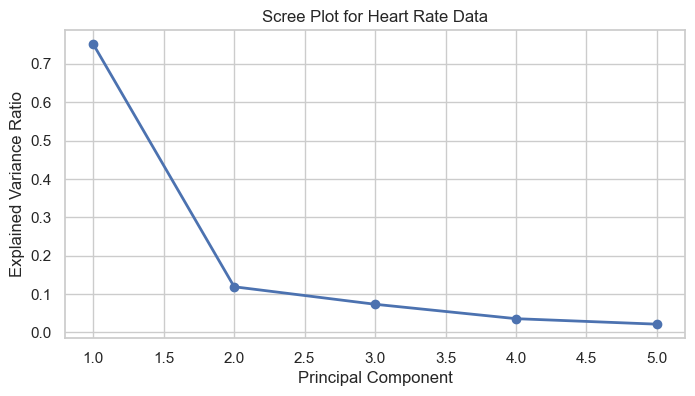

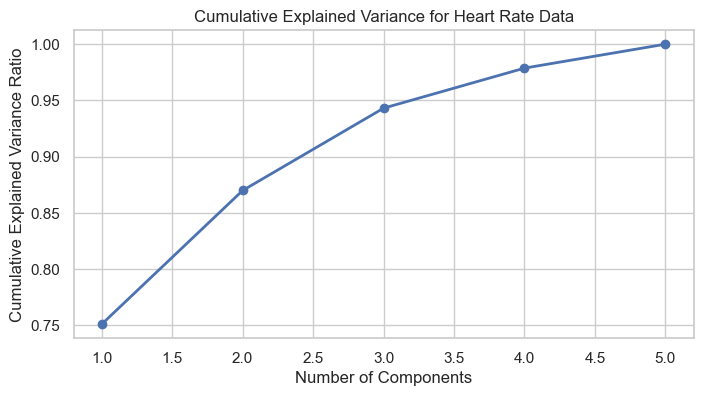

PCA Components for Heart Rate Data:


heart_rate_apache  d1_heartrate_max  d1_heartrate_min  h1_heartrate_max  \
0           0.454720          0.451170          0.385282          0.471476   
1           0.244433          0.470729         -0.809524          0.164421   
2          -0.560031         -0.232314         -0.321200          0.513446   
3          -0.631222          0.633088          0.278104          0.107600   
4          -0.146309          0.346539         -0.125367         -0.689544   

   h1_heartrate_min  
0          0.467914  
1         -0.190533  
2          0.515363  
3         -0.334423  
4          0.606067

In [768]:
# PCA on Heart Rate Variables

# List of heart rate variables
hr_vars = [
    'heart_rate_apache', 'd1_heartrate_max', 'd1_heartrate_min',
    'h1_heartrate_max', 'h1_heartrate_min'
]

# Ensure variables are in the dataset
hr_vars = [var for var in hr_vars if var in data.columns]

# Extract heart rate data
hr_data = data[hr_vars]

# Handle missing values
hr_data = hr_data.dropna()

# Standardize the data
scaler = StandardScaler()
hr_data_scaled = scaler.fit_transform(hr_data)

# Perform PCA

pca_hr = PCA()
pca_hr.fit(hr_data_scaled)
hr_pca = pca_hr.transform(hr_data_scaled)



explained_variance_hr = pca_hr.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_hr) + 1), explained_variance_hr, 'o-', linewidth=2)
plt.title('Scree Plot for Heart Rate Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_hr = np.cumsum(explained_variance_hr)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_hr) + 1), cumulative_explained_variance_hr, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Heart Rate Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
hr_components = pd.DataFrame(pca_hr.components_, columns=hr_data.columns)
print("PCA Components for Heart Rate Data:")
display(hr_components)


In [769]:
# Heart Rate Variables to Drop
hr_vars_to_drop = ['h1_heartrate_max', 'h1_heartrate_min']

# Drop the variables from the dataset
data.drop(columns=hr_vars_to_drop, inplace=True)

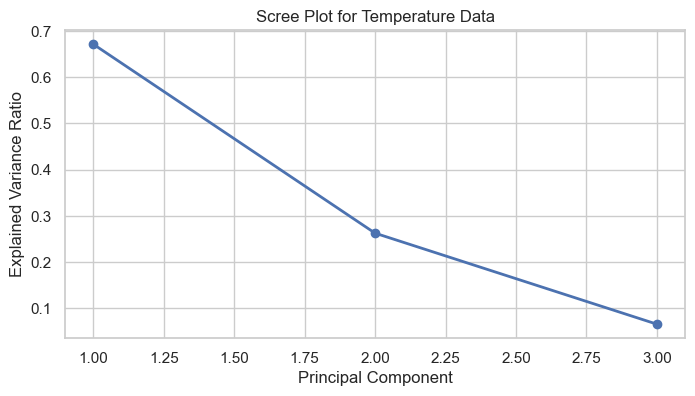

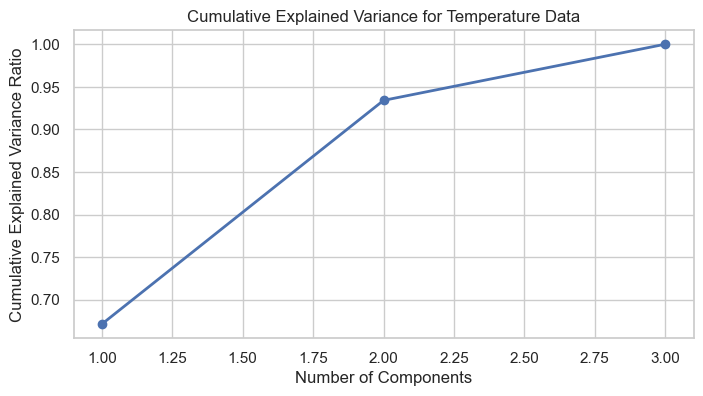

PCA Components for Temperature Data:


temp_apache  d1_temp_max  d1_temp_min
0    -0.656161    -0.430597    -0.619709
1    -0.185002     0.887948    -0.421097
2     0.731592    -0.161660    -0.662298

In [770]:
# PCA on Temperature Variables

# List of temperature variables
temp_vars = [
    'temp_apache', 'd1_temp_max', 'd1_temp_min',
    'h1_temp_max', 'h1_temp_min'
]

# Ensure variables are in the dataset
temp_vars = [var for var in temp_vars if var in data.columns]

# Extract temperature data
temp_data = data[temp_vars]

# Handle missing values
temp_data = temp_data.dropna()

# Standardize the data
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Perform PCA
pca_temp = PCA()
pca_temp.fit(temp_data_scaled)
temp_pca = pca_temp.transform(temp_data_scaled)

# Generate Scree Plot
explained_variance_temp = pca_temp.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_temp) + 1), explained_variance_temp, 'o-', linewidth=2)
plt.title('Scree Plot for Temperature Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_temp = np.cumsum(explained_variance_temp)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_temp) + 1), cumulative_explained_variance_temp, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Temperature Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
temp_components = pd.DataFrame(pca_temp.components_, columns=temp_data.columns)
print("PCA Components for Temperature Data:")
display(temp_components)


In [771]:
# Not really much to drop!

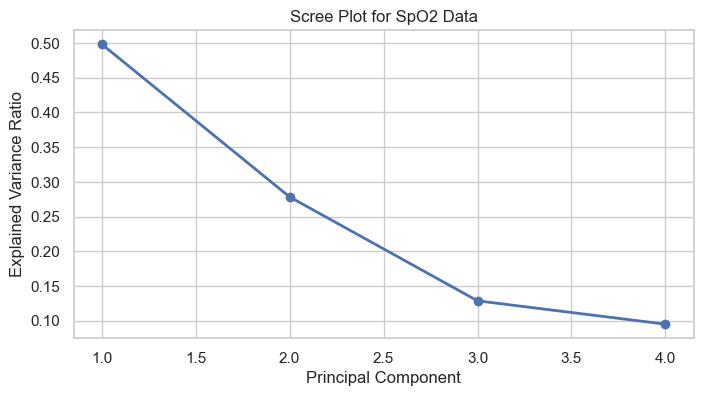

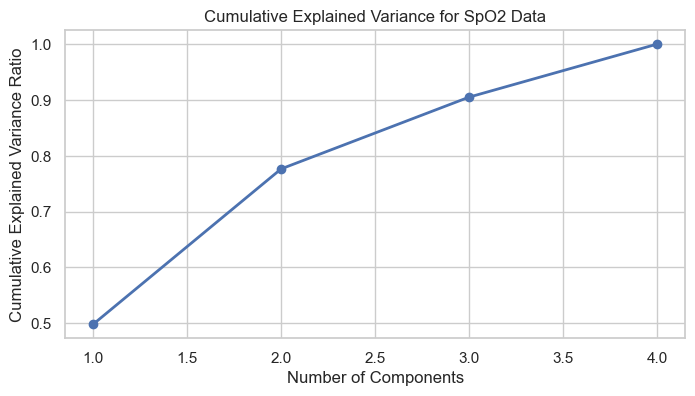

PCA Components for SpO2 Data:


d1_spo2_max  d1_spo2_min  h1_spo2_max  h1_spo2_min
0    -0.400820    -0.454178    -0.551501    -0.573509
1    -0.652951     0.587707    -0.348875     0.326407
2    -0.600268    -0.504389     0.547452     0.292518
3    -0.229514     0.440357     0.523860    -0.692084

In [772]:
# PCA on Peripheral Oxygen Saturation Variables

# List of SpO2 variables
spo2_vars = [
    'd1_spo2_max', 'd1_spo2_min',
    'h1_spo2_max', 'h1_spo2_min'
]

# Ensure variables are in the dataset
spo2_vars = [var for var in spo2_vars if var in data.columns]

# Extract SpO2 data
spo2_data = data[spo2_vars]

# Handle missing values
spo2_data = spo2_data.dropna()

# Standardize the data
scaler = StandardScaler()
spo2_data_scaled = scaler.fit_transform(spo2_data)

# Perform PCA
pca_spo2 = PCA()
pca_spo2.fit(spo2_data_scaled)
spo2_pca = pca_spo2.transform(spo2_data_scaled)

# Generate Scree Plot
explained_variance_spo2 = pca_spo2.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_spo2) + 1), explained_variance_spo2, 'o-', linewidth=2)
plt.title('Scree Plot for SpO2 Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_spo2 = np.cumsum(explained_variance_spo2)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_spo2) + 1), cumulative_explained_variance_spo2, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for SpO2 Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
spo2_components = pd.DataFrame(pca_spo2.components_, columns=spo2_data.columns)
print("PCA Components for SpO2 Data:")
display(spo2_components)


In [773]:
# SpO₂ Variables to Drop
spo2_vars_to_drop = ['h1_spo2_max', 'h1_spo2_min']

# Drop the variables from the dataset
data.drop(columns=spo2_vars_to_drop, inplace=True)

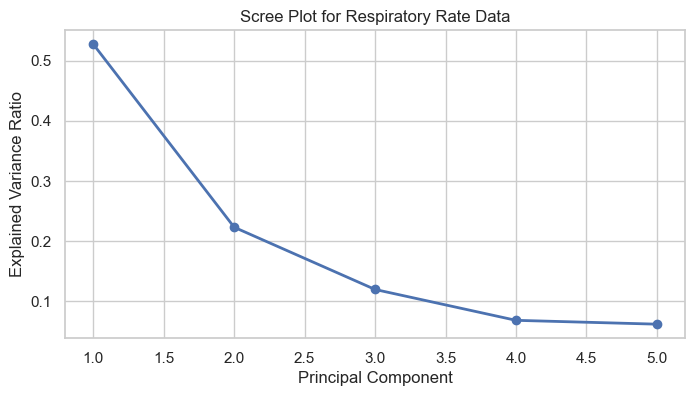

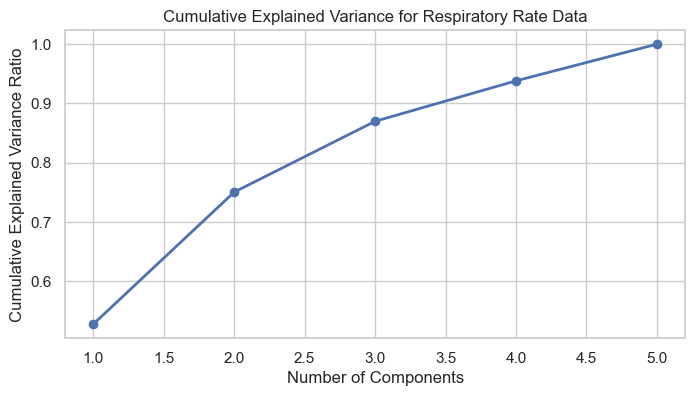

PCA Components for Respiratory Rate Data:


resprate_apache  d1_resprate_max  d1_resprate_min  h1_resprate_max  \
0         0.479149         0.426805         0.341257         0.501368   
1        -0.172408        -0.565489         0.685325        -0.180754   
2        -0.655343        -0.080323        -0.332035         0.522632   
3        -0.516260         0.476194         0.544351         0.129541   
4        -0.211405         0.514633        -0.085484        -0.652713   

   h1_resprate_min  
0         0.469498  
1         0.384910  
2         0.425067  
3        -0.440018  
4         0.507069

In [774]:
# PCA on Respiratory Rate Variables

# List of respiratory rate variables
resp_vars = [
    'resprate_apache', 'd1_resprate_max', 'd1_resprate_min',
    'h1_resprate_max', 'h1_resprate_min'
]

# Ensure variables are in the dataset
resp_vars = [var for var in resp_vars if var in data.columns]

# Extract respiratory rate data
resp_data = data[resp_vars]

# Handle missing values
resp_data = resp_data.dropna()

# Standardize the data
scaler = StandardScaler()
resp_data_scaled = scaler.fit_transform(resp_data)

# Perform PCA
pca_resp = PCA()
pca_resp.fit(resp_data_scaled)
resp_pca = pca_resp.transform(resp_data_scaled)

# Generate Scree Plot
explained_variance_resp = pca_resp.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_resp) + 1), explained_variance_resp, 'o-', linewidth=2)
plt.title('Scree Plot for Respiratory Rate Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_resp = np.cumsum(explained_variance_resp)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_resp) + 1), cumulative_explained_variance_resp, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Respiratory Rate Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
resp_components = pd.DataFrame(pca_resp.components_, columns=resp_data.columns)
print("PCA Components for Respiratory Rate Data:")
display(resp_components)


In [775]:
# Respiratory Rate Variables to Drop
resp_vars_to_drop = ['h1_resprate_max', 'h1_resprate_min']

# Drop the variables from the dataset
data.drop(columns=resp_vars_to_drop, inplace=True)

In [776]:
# --- Cell 6: Display Numerical and Categorical Features Separately ---

# **Step 1: Define Categorical Features Before Encoding**
# It's crucial to define which features are categorical based on your understanding of the data.
# Adjust this list based on your dataset's actual categorical features.

categorical_features = [
    'ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type',
    'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem'
]

# **Step 2: Identify Numerical Features (Excluding the Target Variable)**
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

# **Step 3: Differentiate Between Binary and Continuous Numerical Features**
# Binary categorical features are those categorical features with exactly two unique values
binary_columns = [col for col in categorical_features if data[col].nunique() == 2]
# Continuous numerical features are the remaining numerical features not in binary_columns
continuous_numerical_features = [col for col in numerical_features if col not in binary_columns]

# **Step 4: Print Feature Lists**
print("Continuous Numerical Features:")
print(continuous_numerical_features)

print("\nCategorical Features:")
print(categorical_features)

print("\nBinary Categorical Features:")
print(binary_columns)

# **Step 5: Summary Statistics for Continuous Numerical Features**
if continuous_numerical_features:
    print("\nSummary Statistics of Continuous Numerical Features:")
    print(data[continuous_numerical_features].describe())
else:
    print("\nNo Continuous Numerical Features to display.")


Continuous Numerical Features:
['age', 'bmi', 'elective_surgery', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min', 'comorbidity_count', 'gcs_total']

Categorical Features:
['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem']

Binary Categorical Features:
['gender']

Summary Statistics of Continuous Numerical Features:
                age           bmi  elective_surgery        height  \
count  61955.000000  61955.000000      61955.000000

### EDA

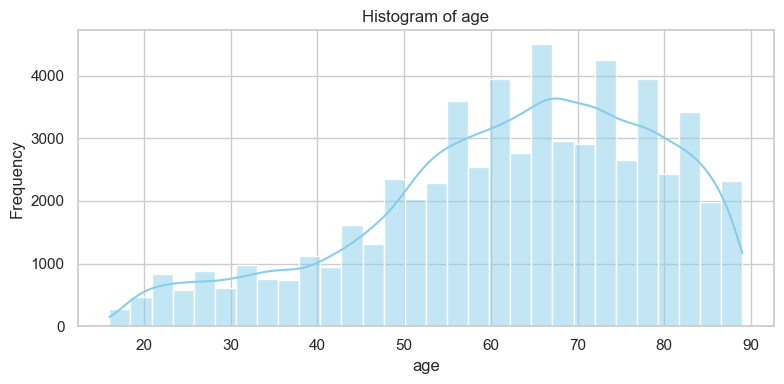

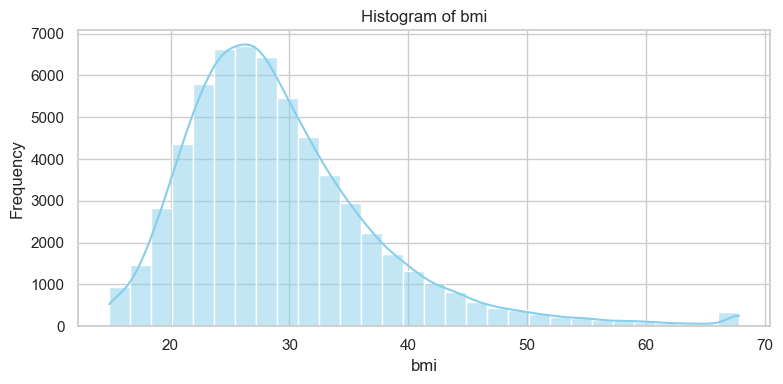

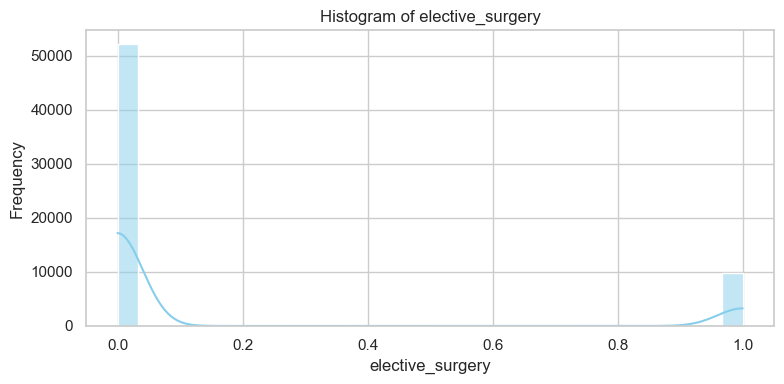

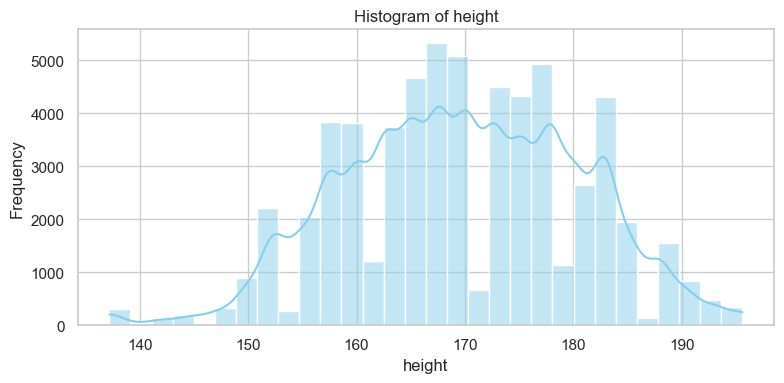

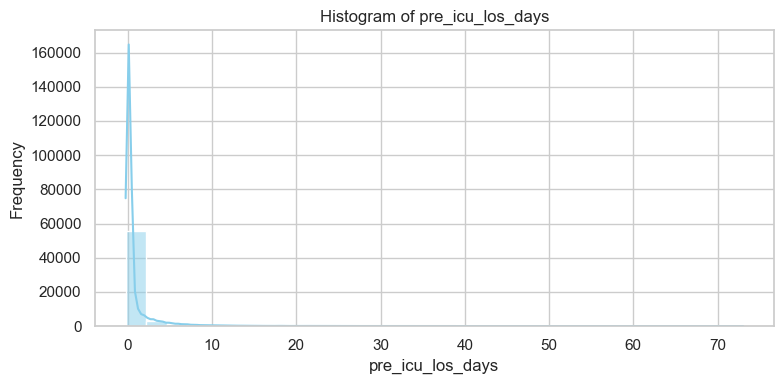

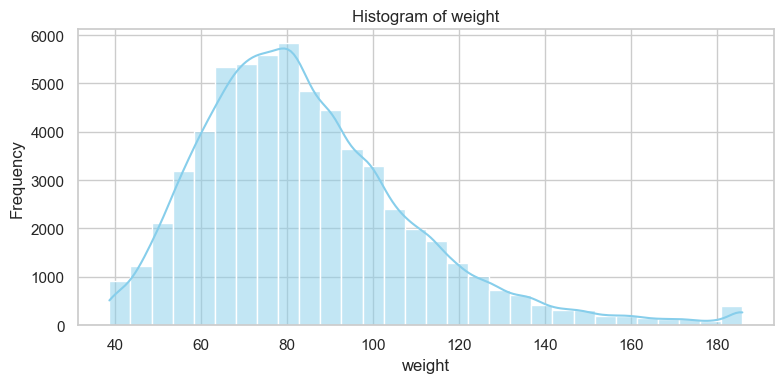

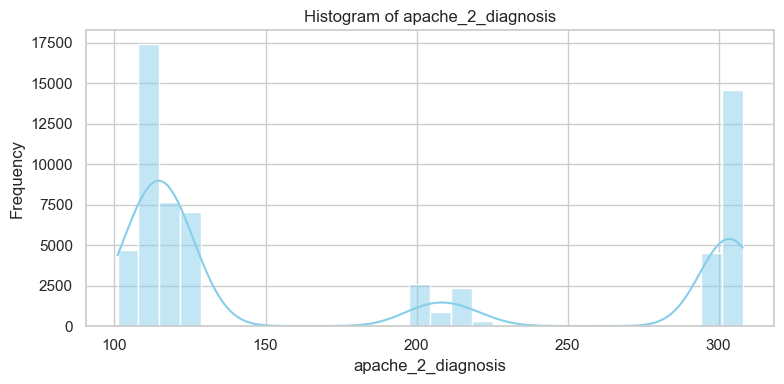

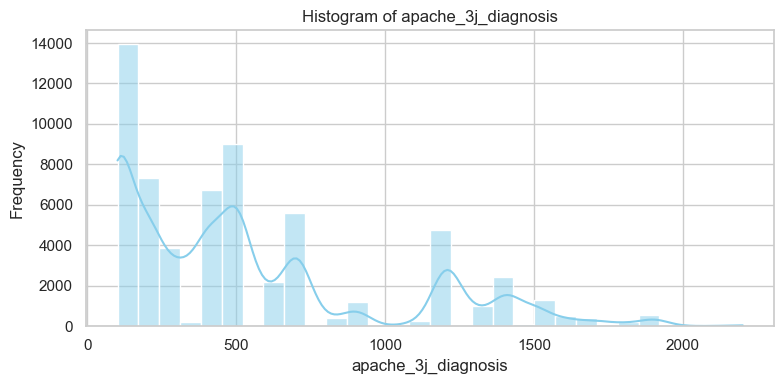

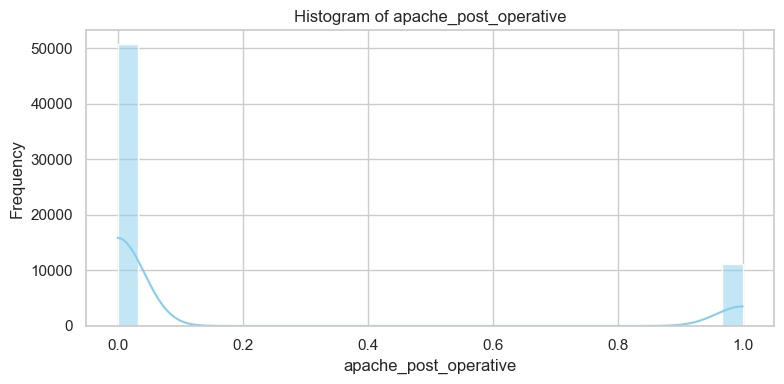

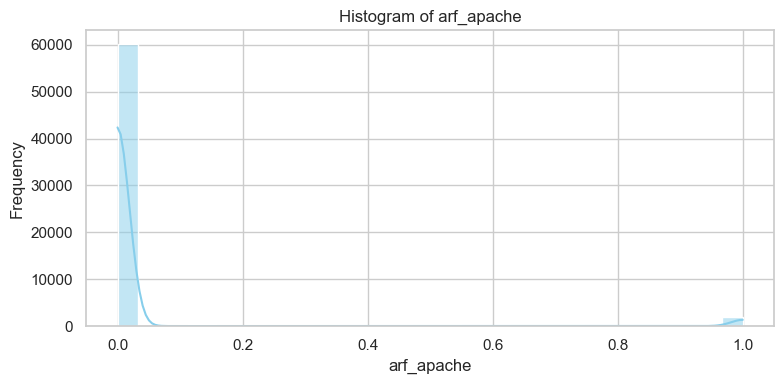

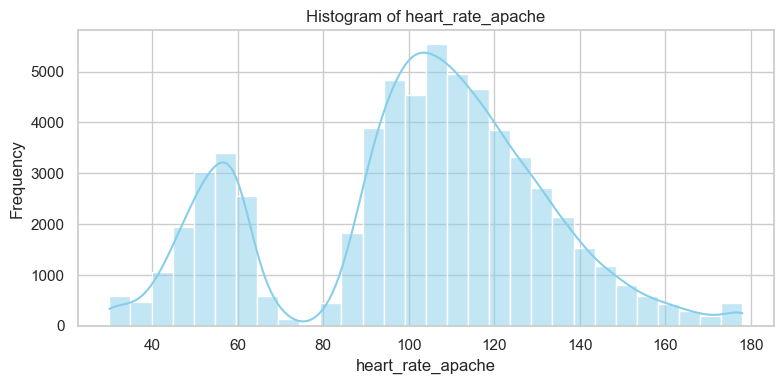

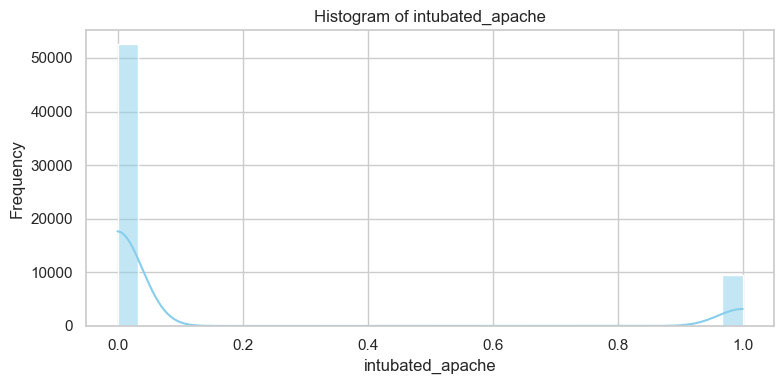

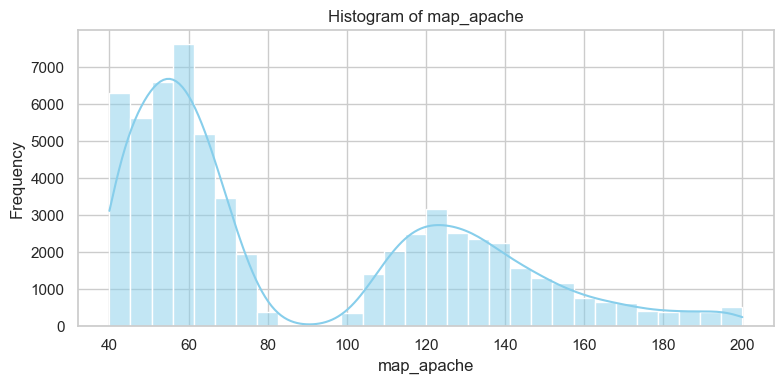

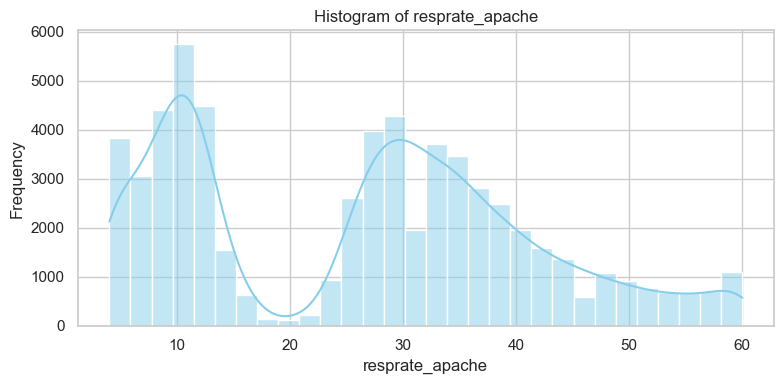

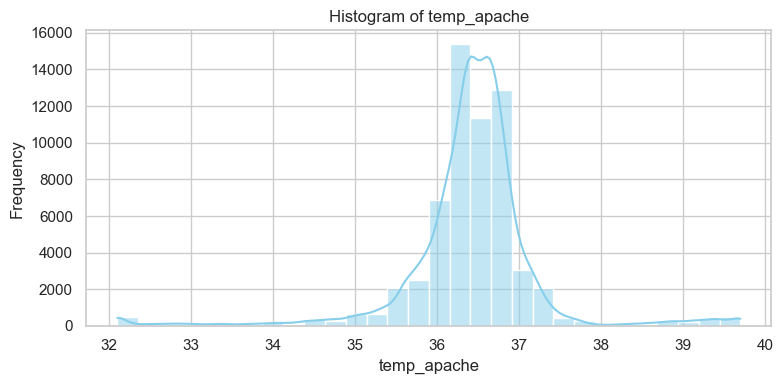

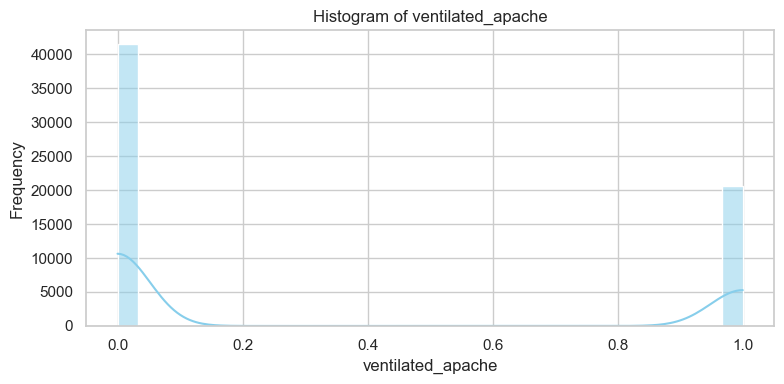

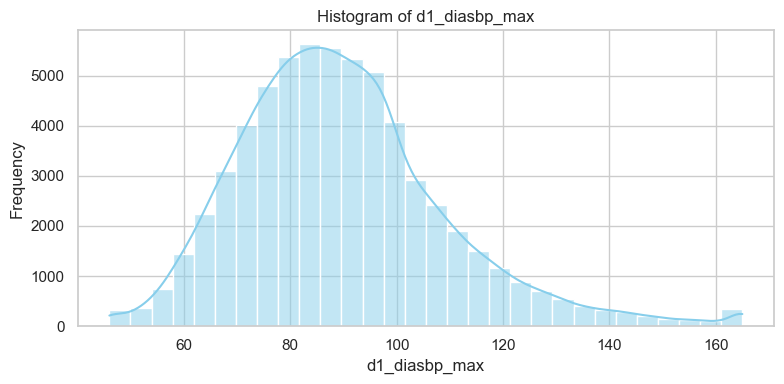

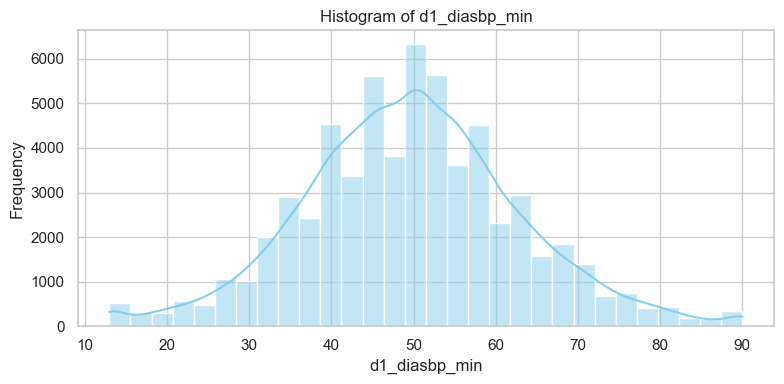

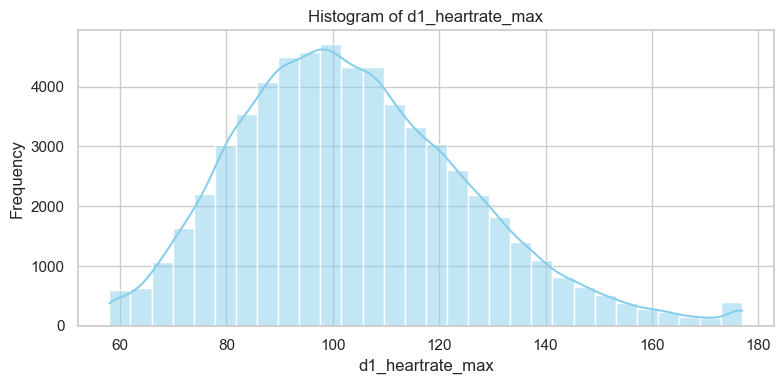

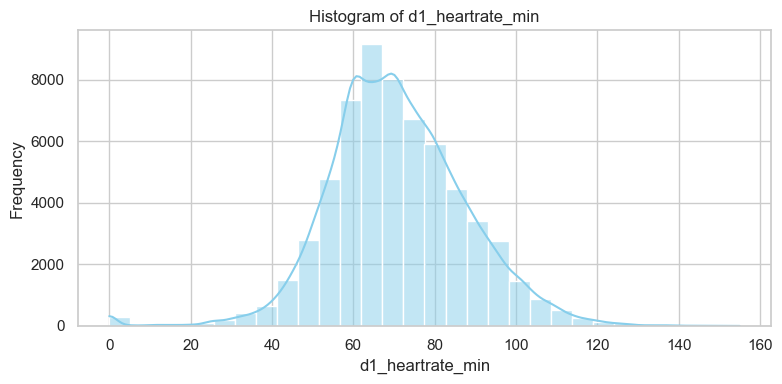

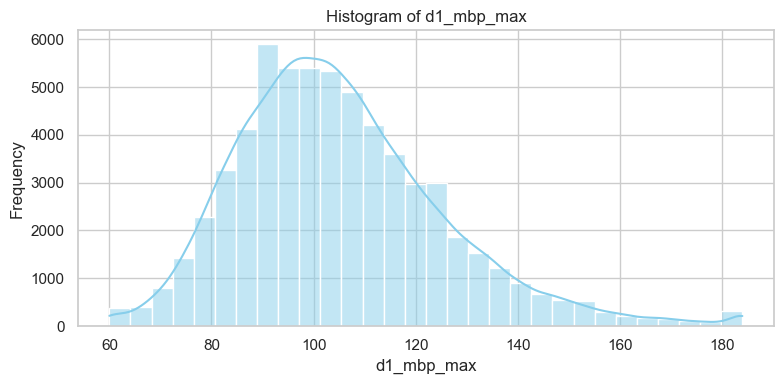

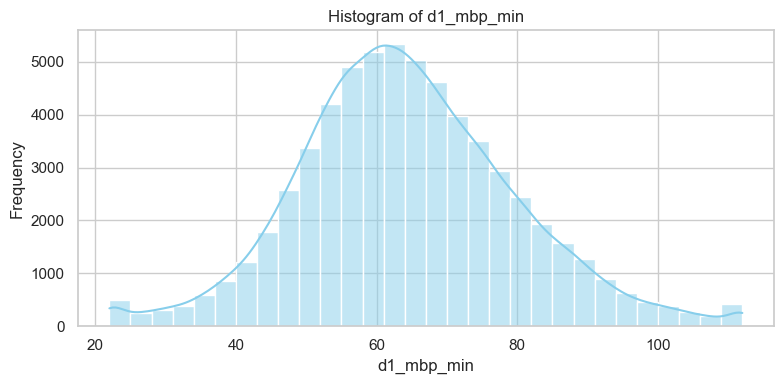

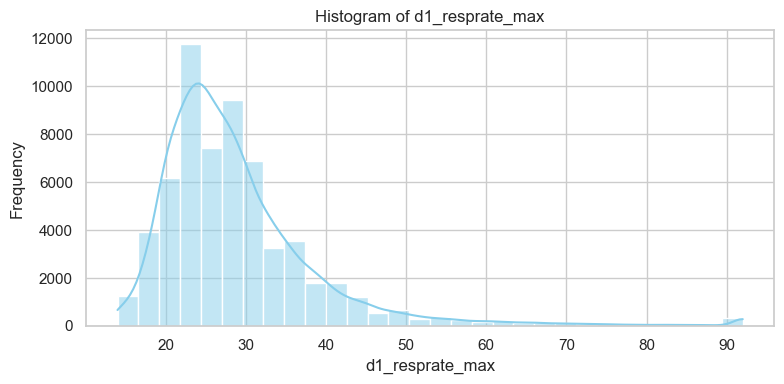

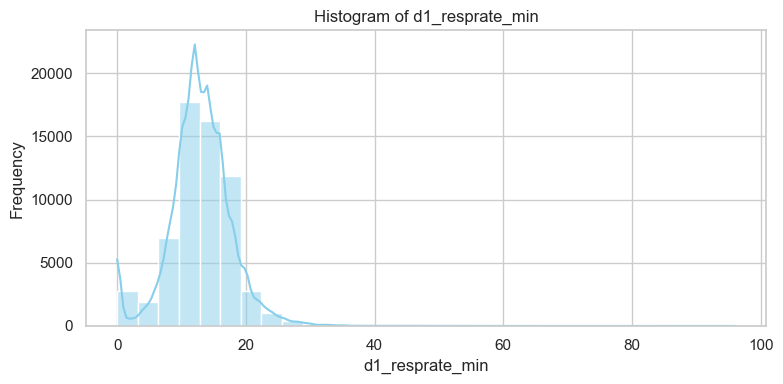

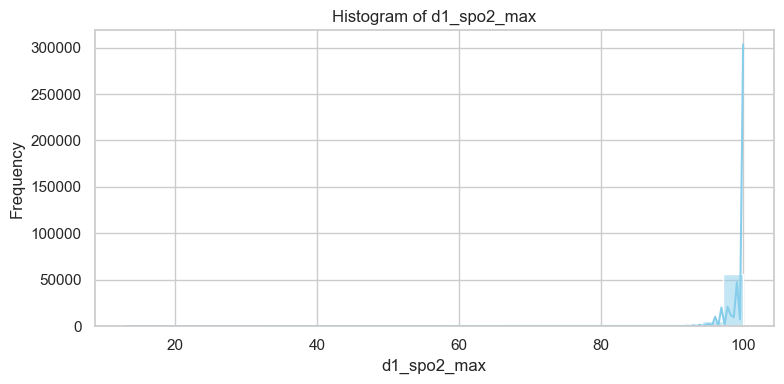

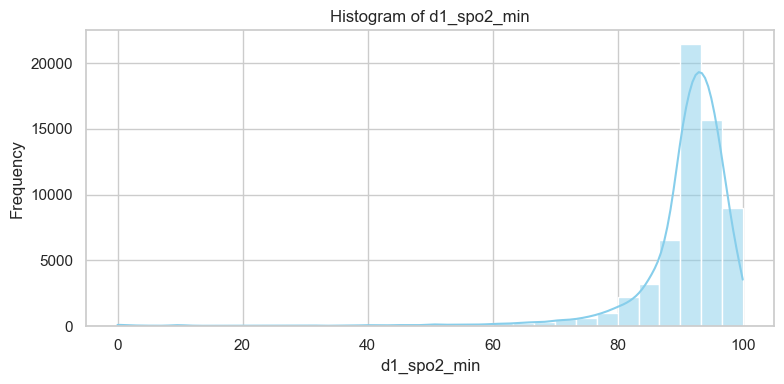

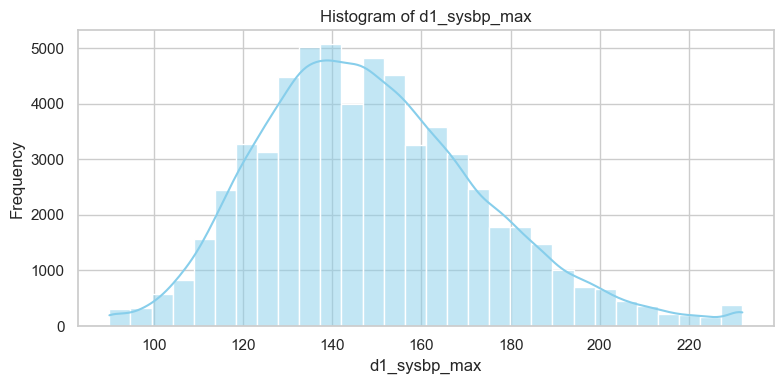

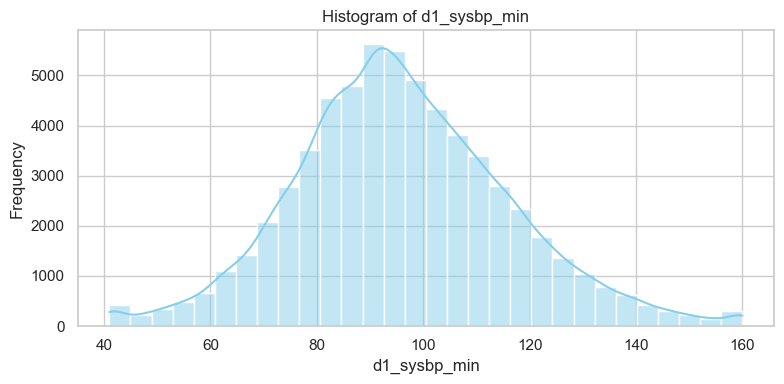

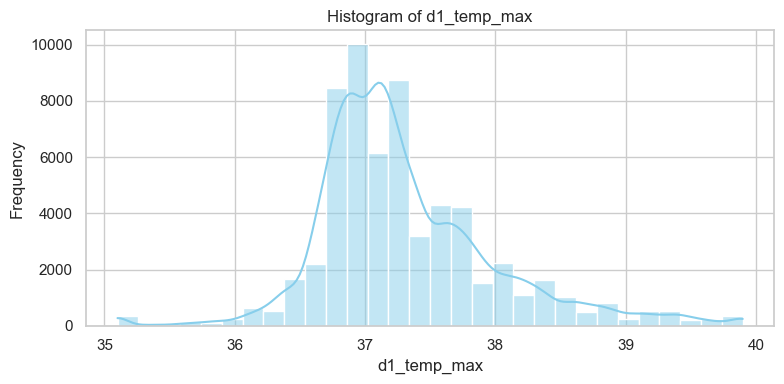

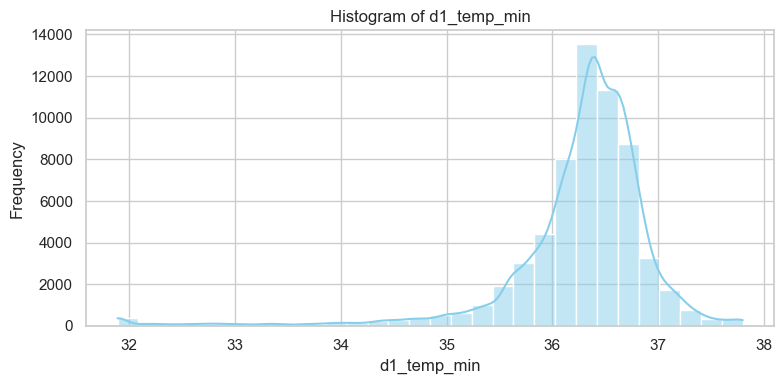

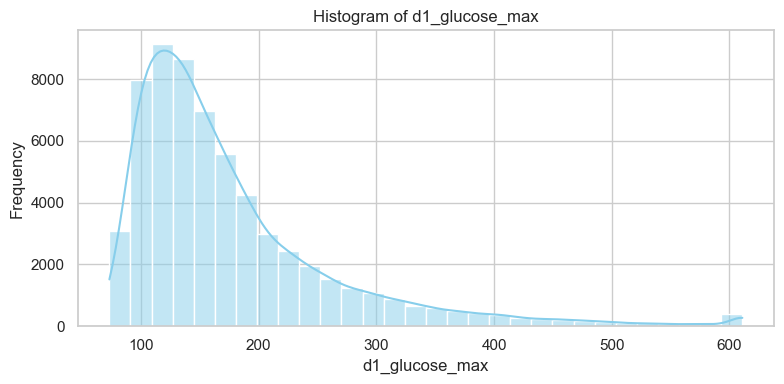

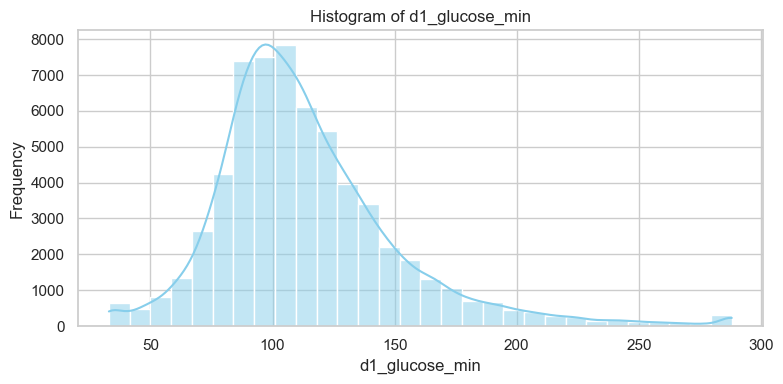

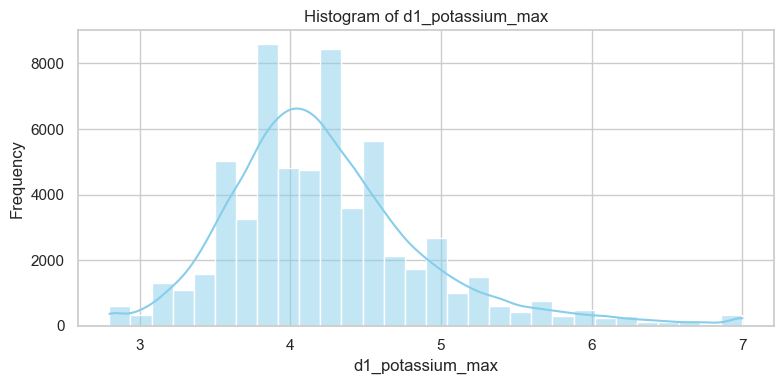

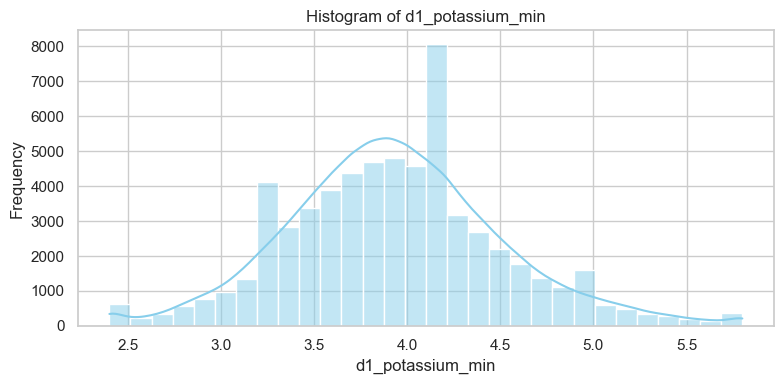

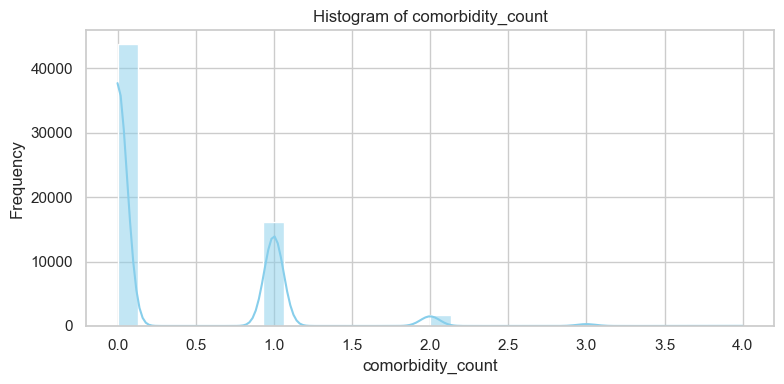

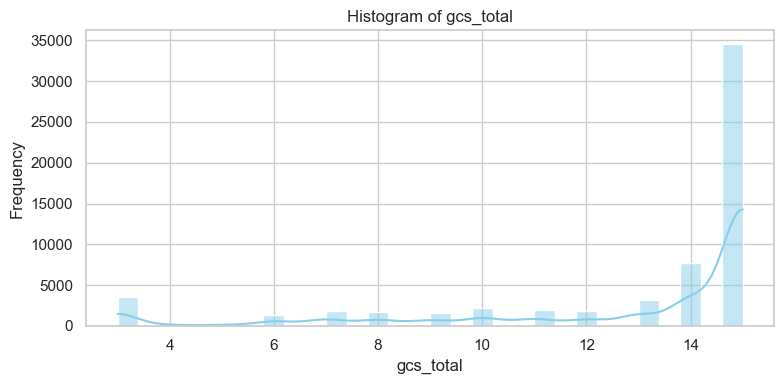

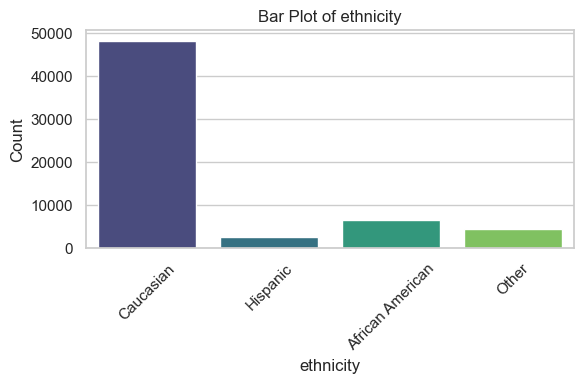

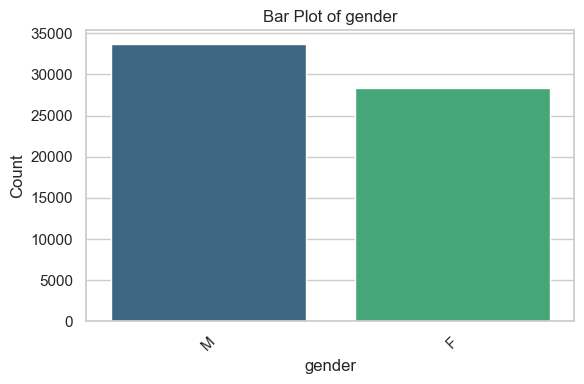

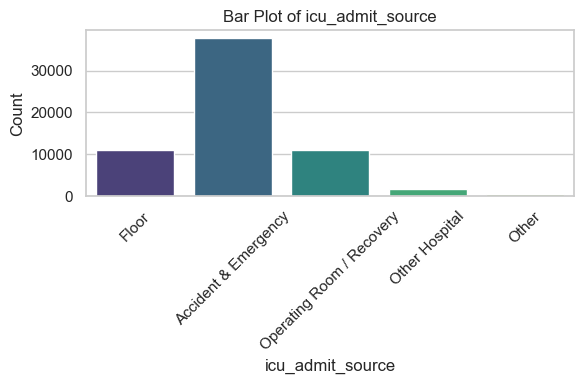

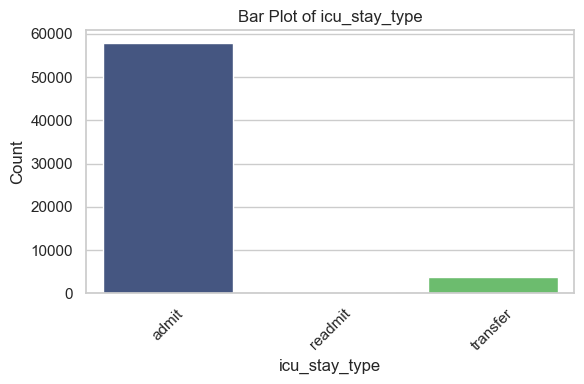

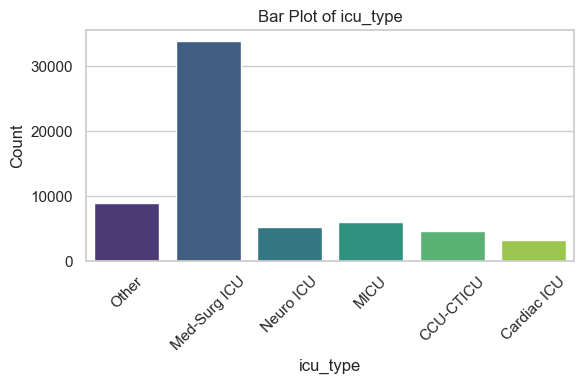

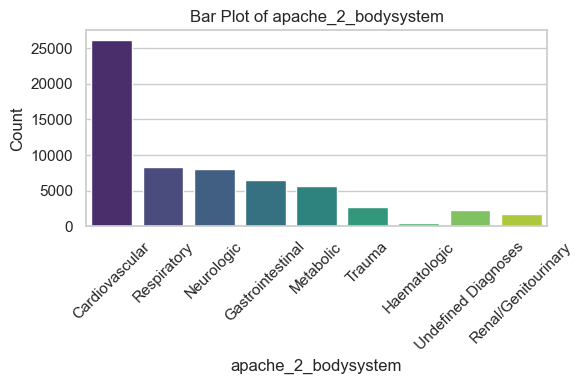

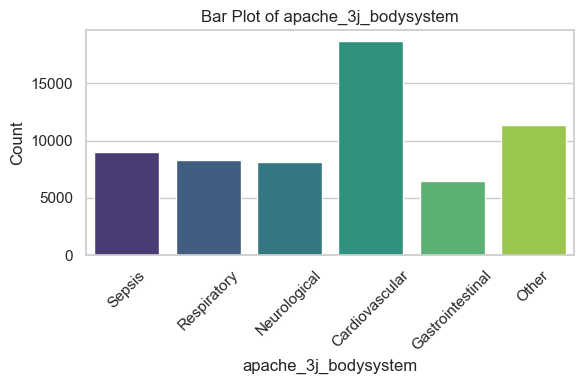

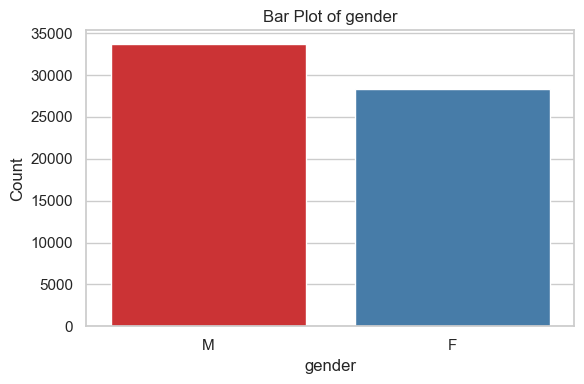

In [777]:
# --- Cell 7: Exploratory Data Analysis (EDA) Graphs ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for plots
sns.set(style="whitegrid")

# **Step 1: Plot Histograms for Continuous Numerical Features**
for col in continuous_numerical_features:
    if col in data.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(data[col], kde=True, bins=30, color='skyblue')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the DataFrame. Skipping histogram.")

# **Step 2: Plot Bar Plots for Categorical Features**
for col in categorical_features:
    if col in data.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=col, data=data, palette='viridis')
        plt.title(f'Bar Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the DataFrame. Skipping bar plot.")

# **Step 3: Plot Bar Plots for Binary Categorical Features**
for col in binary_columns:
    if col in data.columns:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=col, data=data, palette='Set1')
        plt.title(f'Bar Plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' does not exist in the DataFrame. Skipping bar plot.")



Skewness of Continuous Numerical Features:
age                      -0.626256
bmi                       1.424387
elective_surgery          1.861716
height                   -0.106063
pre_icu_los_days          8.322550
weight                    1.074756
apache_2_diagnosis        0.587327
apache_3j_diagnosis       1.111808
apache_post_operative     1.652527
arf_apache                5.483965
heart_rate_apache        -0.311804
intubated_apache          1.934802
map_apache                0.689685
resprate_apache           0.226674
temp_apache              -0.877049
ventilated_apache         0.715650
d1_diasbp_max             0.835660
d1_diasbp_min             0.090830
d1_heartrate_max          0.551853
d1_heartrate_min         -0.036123
d1_mbp_max                0.804259
d1_mbp_min                0.224271
d1_resprate_max           2.521421
d1_resprate_min           0.125245
d1_spo2_max             -12.668732
d1_spo2_min              -4.741901
d1_sysbp_max              0.534414
d1_sysbp_mi

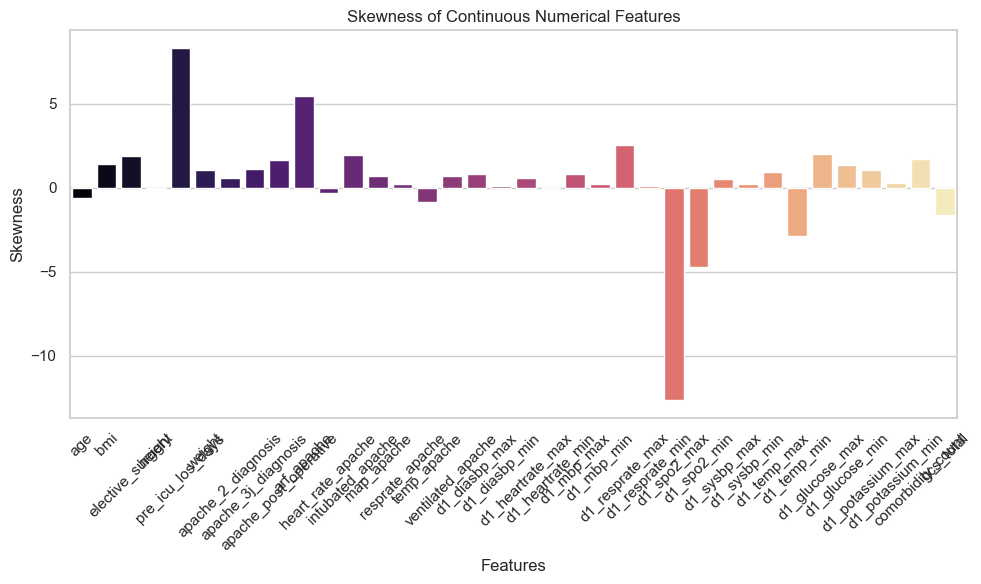

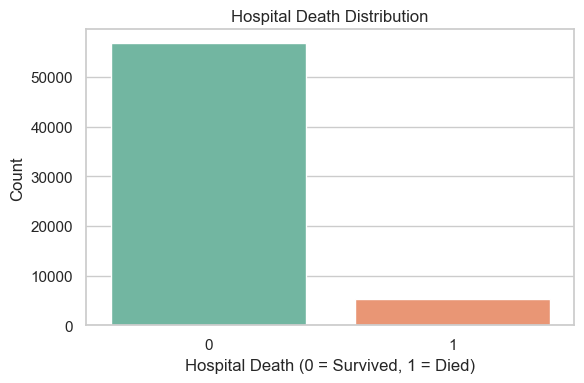


Counts of Hospital Deaths:
0    56741
1     5214
Name: hospital_death, dtype: int64

Percentage Distribution of Hospital Deaths:
0    91.584214
1     8.415786
Name: hospital_death, dtype: float64


In [778]:
# --- Cell 8: Analyze Skewness and Target Variable Distribution ---

from scipy.stats import skew

# **Step 1: Calculate Skewness for Continuous Numerical Features**
skewness = data[continuous_numerical_features].apply(lambda x: skew(x.dropna()))
print("\nSkewness of Continuous Numerical Features:")
print(skewness)

# **Step 2: Plot Skewness Values**
plt.figure(figsize=(10, 6))
sns.barplot(x=skewness.index, y=skewness.values, palette='magma')
plt.title('Skewness of Continuous Numerical Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Step 3: Plot Distribution of the Target Variable**
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_death', data=data, palette='Set2')
plt.title('Hospital Death Distribution')
plt.xlabel('Hospital Death (0 = Survived, 1 = Died)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# **Step 4: Print Counts and Percentage Distribution**
death_counts = data['hospital_death'].value_counts()
print("\nCounts of Hospital Deaths:")
print(death_counts)

print("\nPercentage Distribution of Hospital Deaths:")
print(data['hospital_death'].value_counts(normalize=True) * 100)


In [779]:
# --- Cell 10: Encode Categorical Variables Appropriately ---

from sklearn.preprocessing import LabelEncoder

# Identify categorical features (predefined)
print("Categorical Features to Encode:")
print(categorical_features)

# Initialize LabelEncoders for each categorical column
label_encoders = {}

# Apply Label Encoding to all categorical features
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le  # Save the encoder for future use (e.g., during inference)

# Verify that all categorical features have been encoded
print("\nData Types After Label Encoding:")
print(data.dtypes)


Categorical Features to Encode:
['ethnicity', 'gender', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_2_bodysystem', 'apache_3j_bodysystem']

Data Types After Label Encoding:
age                      float64
bmi                      float64
elective_surgery           int64
ethnicity                  int32
gender                     int32
height                   float64
icu_admit_source           int32
icu_stay_type              int32
icu_type                   int32
pre_icu_los_days         float64
weight                   float64
apache_2_diagnosis       float64
apache_3j_diagnosis      float64
apache_post_operative      int64
arf_apache               float64
heart_rate_apache        float64
intubated_apache         float64
map_apache               float64
resprate_apache          float64
temp_apache              float64
ventilated_apache        float64
d1_diasbp_max            float64
d1_diasbp_min            float64
d1_heartrate_max         float64
d1_heartrate_min      


--- Full Correlation Matrix ---
                            age       bmi  elective_surgery  ethnicity  \
age                    1.000000 -0.082825          0.058122  -0.007580   
bmi                   -0.082825  1.000000          0.004851  -0.037732   
elective_surgery       0.058122  0.004851          1.000000   0.013909   
ethnicity             -0.007580 -0.037732          0.013909   1.000000   
gender                -0.033472 -0.047895          0.021548   0.023212   
height                -0.116585 -0.065355          0.014701  -0.111139   
icu_admit_source       0.055406  0.022762          0.557173   0.009894   
icu_stay_type         -0.010436  0.002617         -0.054385  -0.032186   
icu_type              -0.019914 -0.028890          0.170542   0.039664   
pre_icu_los_days       0.053243 -0.000075          0.123607   0.004969   
weight                -0.125861  0.880153          0.013027  -0.079078   
apache_2_diagnosis     0.021063  0.019156          0.361454   0.009105   
apach

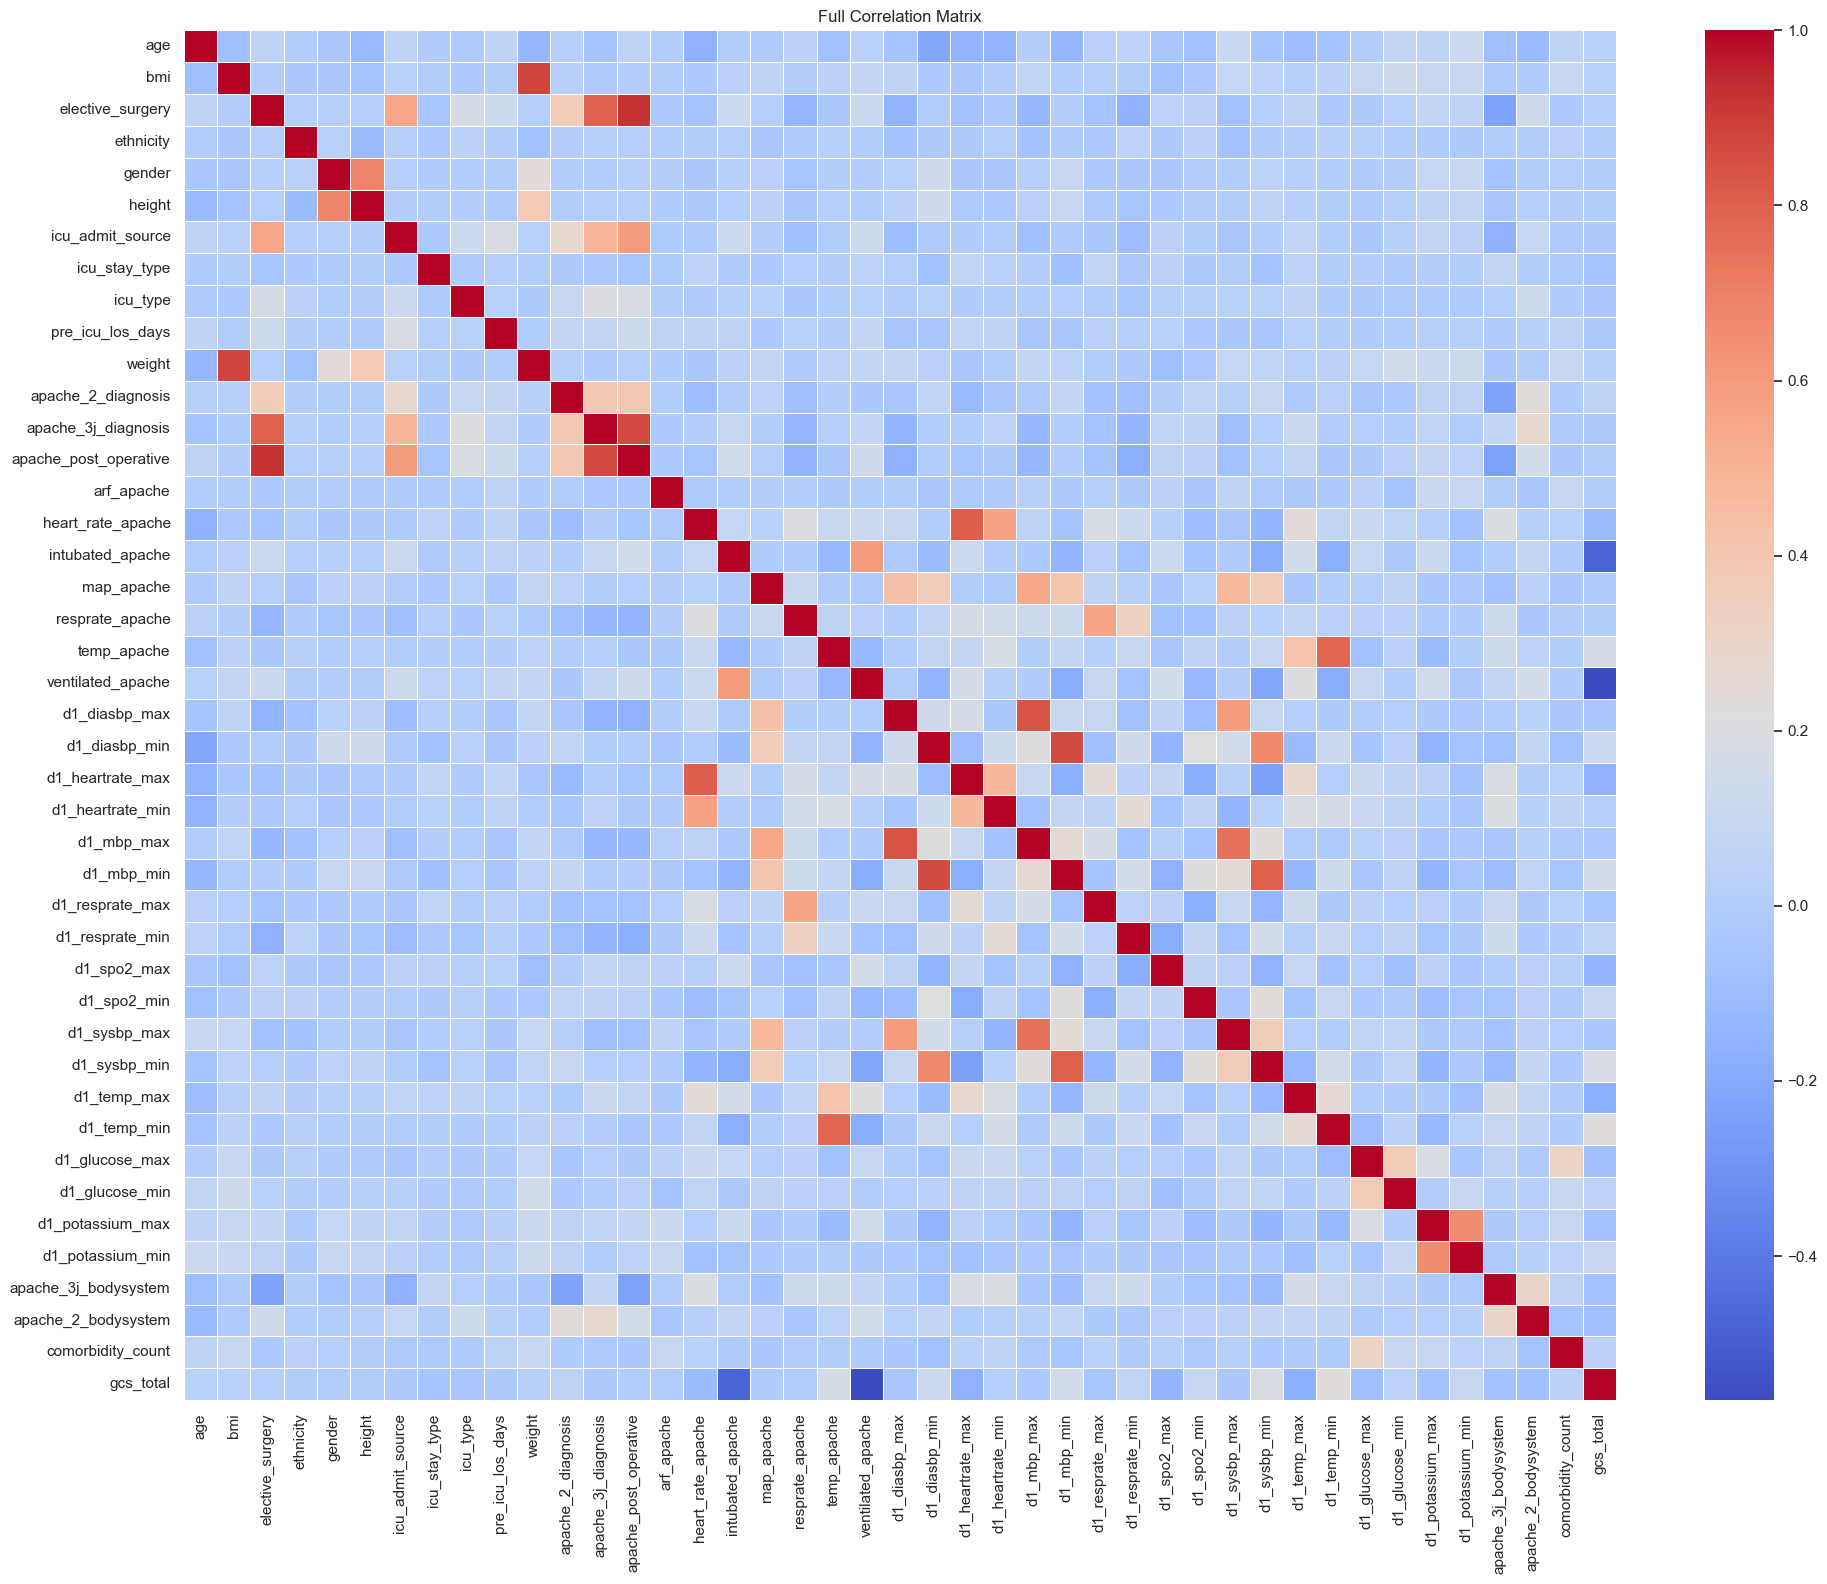


--- Correlation Matrix Subset (First 20 Features) ---
                            age       bmi  elective_surgery  ethnicity  \
age                    1.000000 -0.082825          0.058122  -0.007580   
bmi                   -0.082825  1.000000          0.004851  -0.037732   
elective_surgery       0.058122  0.004851          1.000000   0.013909   
ethnicity             -0.007580 -0.037732          0.013909   1.000000   
gender                -0.033472 -0.047895          0.021548   0.023212   
height                -0.116585 -0.065355          0.014701  -0.111139   
icu_admit_source       0.055406  0.022762          0.557173   0.009894   
icu_stay_type         -0.010436  0.002617         -0.054385  -0.032186   
icu_type              -0.019914 -0.028890          0.170542   0.039664   
pre_icu_los_days       0.053243 -0.000075          0.123607   0.004969   
weight                -0.125861  0.880153          0.013027  -0.079078   
apache_2_diagnosis     0.021063  0.019156          0.3614

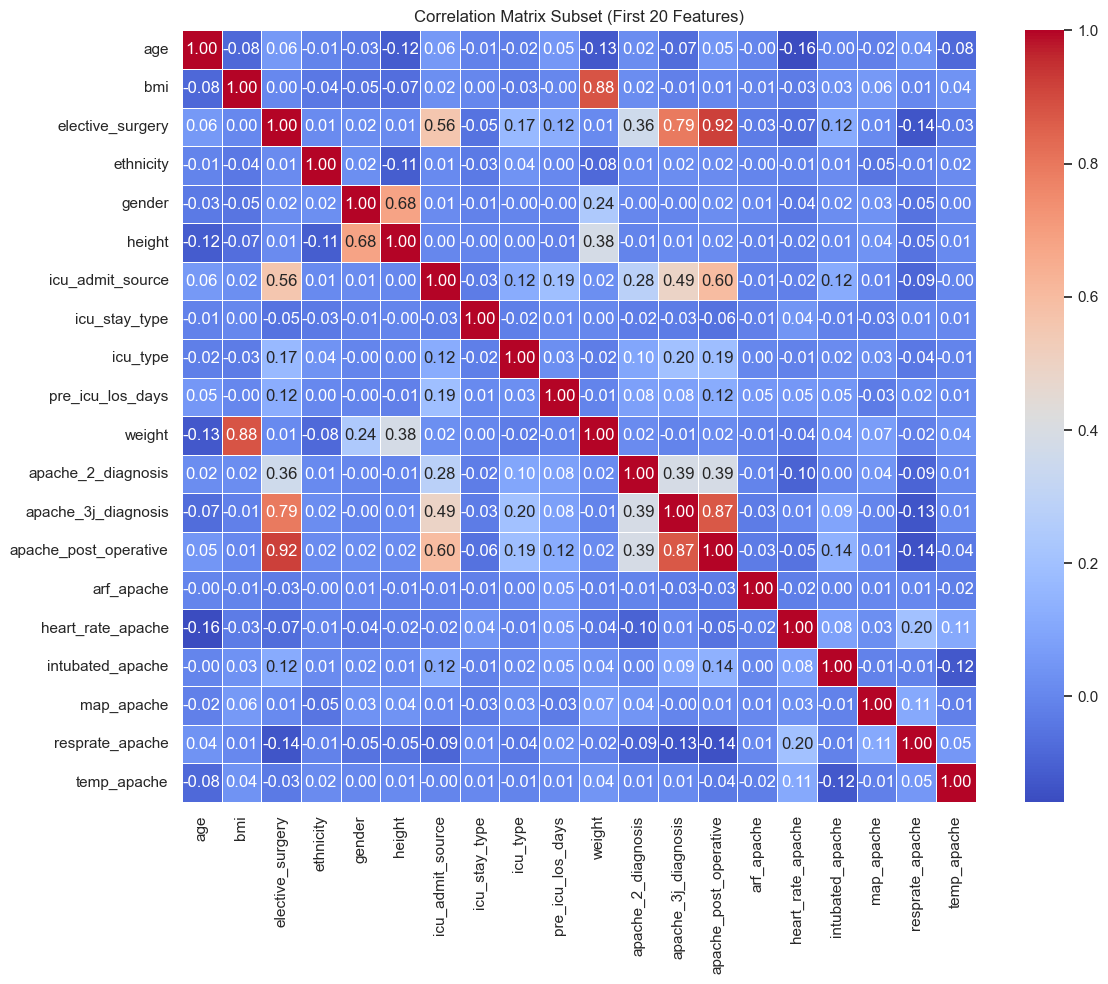

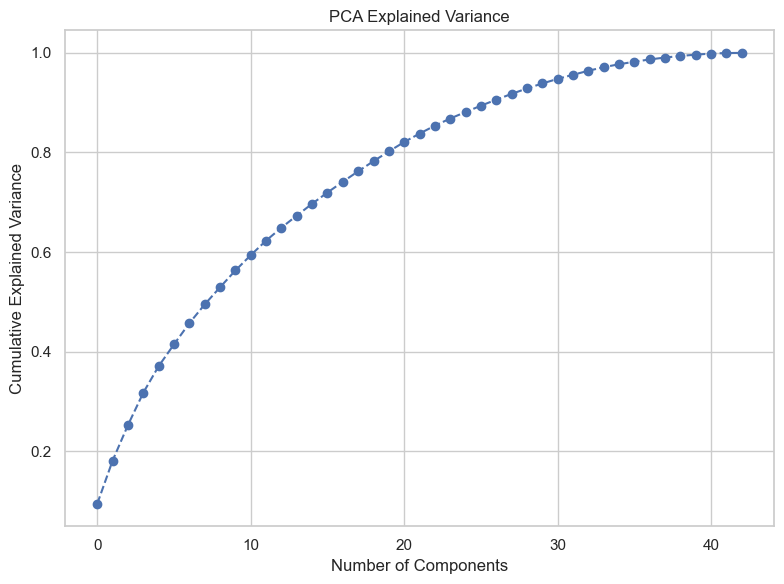


Number of PCA components to explain at least 95% variance: 32


In [780]:
# --- Cell 9: Multicollinearity Analysis and PCA ---

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Step 1: Prepare the Features for Correlation Analysis (Exclude the Target Variable)**
X = data.drop('hospital_death', axis=1)

# **Step 2: Compute and Display the Full Correlation Matrix**
print("\n--- Full Correlation Matrix ---")
corr_matrix = X.corr()
print(corr_matrix)

# **Optional:** Save the correlation matrix to a CSV for external analysis
# corr_matrix.to_csv('full_correlation_matrix.csv', index=True)

# **Step 3: Plot the Full Correlation Matrix Heatmap**
plt.figure(figsize=(20, 16))  # Adjusted size for better readability
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5, annot=False)
plt.title('Full Correlation Matrix')
plt.tight_layout()
plt.show()

# **Step 4: Select and Print a Subset of the Correlation Matrix**
# Define the number of features you want to include in the subset
subset_size = 20  # Change this value as needed
subset_corr_matrix = corr_matrix.iloc[:subset_size, :subset_size]

print(f"\n--- Correlation Matrix Subset (First {subset_size} Features) ---")
print(subset_corr_matrix)

# **Optional:** If you have specific features in mind, define them as a list
# selected_features = ['feature1', 'feature2', 'feature3', ...]
# subset_corr_matrix = corr_matrix.loc[selected_features, selected_features]
# print("\n--- Correlation Matrix Subset (Selected Features) ---")
# print(subset_corr_matrix)

# **Step 5: Plot the Subset Correlation Matrix Heatmap**
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title(f'Correlation Matrix Subset (First {subset_size} Features)')
plt.tight_layout()
plt.show()

# **Step 6: PCA for Dimensionality Reduction**

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA
pca = PCA()
pca.fit(X_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Step 7: Determine the Number of Components to Explain 95% Variance**
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nNumber of PCA components to explain at least 95% variance: {n_components_95}")

# **Note:**  
# PCA exploration and feature dropping have been summarized as per your request.


In [781]:
# --- Cell 11: Label Encoding Explanation and Mappings ---

from sklearn.preprocessing import LabelEncoder

# **Step 1: Explanation of Label Encoding**
print("""
**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them. 
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one. 
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.
""")

# **Step 2: Display Label Encoding Mappings for Each Categorical Feature**
for col, le in label_encoders.items():
    print(f"\n**Feature: {col}**")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    for category, code in mapping.items():
        print(f"  {code}: {category}")



**Label Encoding Explained:**

Label Encoding is a technique used to convert categorical variables into numerical form so that machine learning algorithms can process them. 
Each unique category in a feature is assigned an integer value.

**Example:**
For a feature 'gender' with categories ['Male', 'Female'], Label Encoding might assign:
- 'Male' -> 0
- 'Female' -> 1

**Important Note:**
Label Encoding does not preserve any ordinal relationship unless the categories inherently have one. 
For purely nominal categorical variables, One-Hot Encoding is often preferred to avoid introducing unintended ordinal relationships.

Below, we'll display the mapping of each categorical feature from its original categories to the encoded numerical values.


**Feature: ethnicity**
  0: African American
  1: Caucasian
  2: Hispanic
  3: Other

**Feature: gender**
  0: F
  1: M

**Feature: icu_admit_source**
  0: Accident & Emergency
  1: Floor
  2: Operating Room / Recovery
  3: Other
  4: Other Hospit

In [782]:
# --- Final Cell: Inspect Final Processed Dataset Features ---

# **Step 1: Display the List of Final Features**
print("Final Processed Dataset Columns:")
print(data.columns.tolist())

# **Step 2: Show the First Few Rows of the Processed Dataset**
print("\nFirst 5 Rows of the Final Processed Dataset:")
display(data.head())

# **Step 3: Provide a Summary of the DataFrame**
print("\nSummary of the Final Processed Dataset:")
data.info()


Final Processed Dataset Columns:
['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'apache_post_operative', 'arf_apache', 'heart_rate_apache', 'intubated_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'ventilated_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'hospital_death', 'comorbidity_count', 'gcs_total']

First 5 Rows of the Final Processed Dataset:


age        bmi  elective_surgery  ethnicity  gender  height  \
0   68.0  22.730000                 0          1       1   180.3   
1   77.0  27.420000                 0          1       0   160.0   
5   67.0  27.560000                 0          1       1   190.5   
10  72.0  28.257052                 1          2       0   154.9   
17  46.0  25.845717                 0          2       1   167.6   

    icu_admit_source  icu_stay_type  icu_type  pre_icu_los_days  ...  \
0                  1              0         5          0.541667  ...   
1                  1              0         3          0.927778  ...   
5                  0              0         3          0.000694  ...   
10                 2              0         3          0.004861  ...   
17                 0              0         5          0.000000  ...   

    d1_temp_min  d1_glucose_max  d1_glucose_min  d1_potassium_max  \
0          37.2           168.0           109.0               4.0   
1          35.1           145.0           128.0               4.2   
5          36.6           156.0           125.0               3.9   
10         36.7           158.0           133.0               4.2   
17         36.4           143.0           143.0               4.9   

    d1_potassium_min  apache_3j_bodysystem  apache_2_bodysystem  \
0                3.4                     5                    0   
1                3.8                     4                    6   
5                3.7                     2                    4   
10               4.2                     4                    6   
17               4.9                     4                    6   

    hospital_death  comorbidity_count  gcs_total  
0                0                  1       13.0  
1                0                  1        5.0  
5                0                  1       15.0  
10               0                  1       15.0  
17               0                  0        6.0  

[5 rows x 44 columns]


Summary of the Final Processed Dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61955 entries, 0 to 91712
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    61955 non-null  float64
 1   bmi                    61955 non-null  float64
 2   elective_surgery       61955 non-null  int64  
 3   ethnicity              61955 non-null  int32  
 4   gender                 61955 non-null  int32  
 5   height                 61955 non-null  float64
 6   icu_admit_source       61955 non-null  int32  
 7   icu_stay_type          61955 non-null  int32  
 8   icu_type               61955 non-null  int32  
 9   pre_icu_los_days       61955 non-null  float64
 10  weight                 61955 non-null  float64
 11  apache_2_diagnosis     61955 non-null  float64
 12  apache_3j_diagnosis    61955 non-null  float64
 13  apache_post_operative  61955 non-null  int64  
 14  arf_apache   

In [783]:
# what to do with missing values
# problem if missing data is not random, then data will be skewed 

# keep correlated varibales? 

# i need to scale for almost anything not tree? (numeric values) 

# use PCA to only choose a subset of the blood pressure features (look at scree plot) 

# are there any models where I should not use SMOTE?
# if the truth becomes 50 - 50
# try without smote first 
# think about where the threshold should be 

# create an invasive variable if data is diff
# deal with all this blood stuff

# captum shap values
# LIME is outdated 
# benchmark against existing scores

# vif is only for linear!!

## DATA SPLITTING AND IMPORTANCE TREE


=== Feature Importances ===
                  Feature  Importance
0               gcs_total    0.043933
1            d1_sysbp_min    0.041725
2     apache_3j_diagnosis    0.040838
3             d1_spo2_min    0.038013
4        d1_heartrate_min    0.037149
5              d1_mbp_min    0.035473
6             d1_temp_min    0.035033
7          d1_glucose_min    0.034390
8             temp_apache    0.034250
9        pre_icu_los_days    0.033937
10                    age    0.031642
11            d1_temp_max    0.031555
12       d1_heartrate_max    0.031338
13             map_apache    0.030455
14                    bmi    0.030007
15      heart_rate_apache    0.029792
16          d1_diasbp_min    0.029239
17         d1_glucose_max    0.029107
18           d1_sysbp_max    0.028625
19                 weight    0.028045
20        d1_resprate_min    0.027106
21        d1_resprate_max    0.026396
22             d1_mbp_max    0.026210
23       d1_potassium_min    0.025540
24       d1_potassium

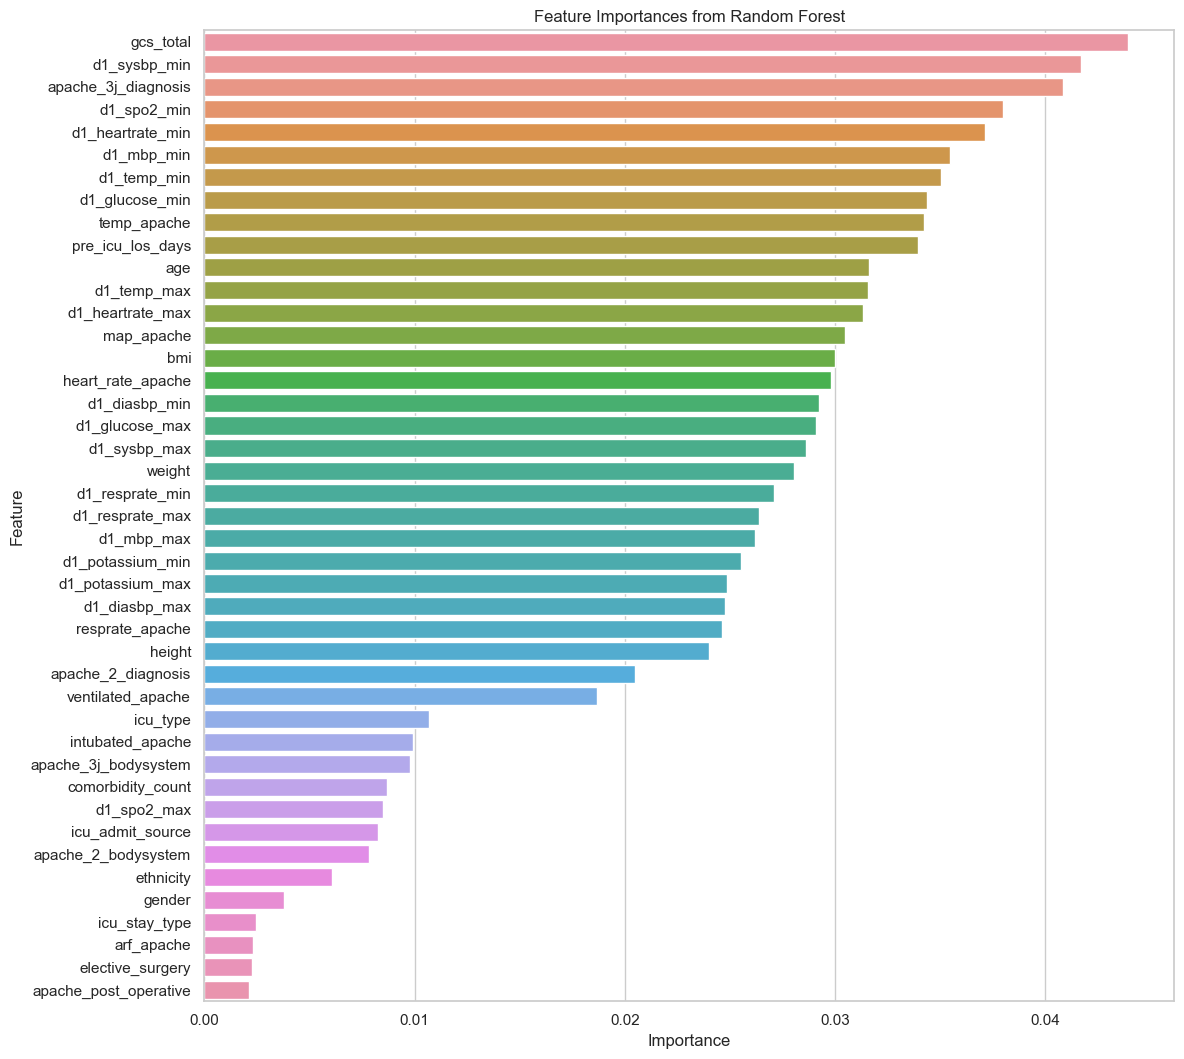


Datasets ready for modeling:
1. X_train_ns_ns, y_train_ns_ns (No Scaling, No SMOTE)
2. X_test_ns_ns, y_test_ns_ns
3. X_train_s_ns, y_train_s_ns (Scaling, No SMOTE)
4. X_test_s_ns, y_test_s_ns
5. X_train_ns_s, y_train_ns_s (No Scaling, SMOTENC)
6. X_test_ns_s, y_test_ns_s
7. X_train_s_s, y_train_s_s (Scaling, SMOTENC)
8. X_test_s_s, y_test_s_s


In [784]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(18)
random.seed(18)

# Assuming 'data' is your preprocessed DataFrame with encoded categorical variables and no missing values

# Separate features and target variable
X = data.drop('hospital_death', axis=1)
y = data['hospital_death']

# --- 1. Split the Data into Training and Test Sets ---
# Use stratified sampling to maintain class distribution
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Identify Numerical and Categorical Features ---
# Since encoding is already done, we can identify features based on data types

# Identify numerical features (excluding the target variable)
numerical_features = X_train_full.select_dtypes(include=[np.number]).columns.tolist()

# Identify categorical features
categorical_features = X_train_full.select_dtypes(exclude=[np.number]).columns.tolist()

# If any binary categorical features were encoded as numerical, add them to categorical_features
# Assuming you have a list of original binary categorical features
binary_categorical_features = [
    'elective_surgery', 'apache_post_operative', 'arf_apache', 'intubated_apache',
    'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

for col in binary_categorical_features:
    if col in numerical_features:
        numerical_features.remove(col)
        categorical_features.append(col)

# --- 3. Compute Feature Importances Using Random Forest ---

# Set pandas option to display all rows
pd.set_option('display.max_rows', None)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train_full, y_train)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_full.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Reset index for better display
feature_importance_df = feature_importance_df.reset_index(drop=True)

# Display the full list of features with their importance scores
print("\n=== Feature Importances ===")
print(feature_importance_df)

# Reset pandas option to default after printing
pd.reset_option('display.max_rows')

# Optional: Visualize Feature Importances
plt.figure(figsize=(12, len(feature_names) * 0.25))  # Adjust height based on number of features
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

# --- 4. Create Copies for Each Scenario ---

# a. No Scaling, No SMOTE
X_train_ns_ns = X_train_full.copy()
X_test_ns_ns = X_test_full.copy()
y_train_ns_ns = y_train.copy()
y_test_ns_ns = y_test.copy()

# b. Scaling, No SMOTE
X_train_s_ns = X_train_full.copy()
X_test_s_ns = X_test_full.copy()
y_train_s_ns = y_train.copy()
y_test_s_ns = y_test.copy()

# c. No Scaling, SMOTENC
X_train_ns_s = X_train_full.copy()
X_test_ns_s = X_test_full.copy()
y_train_ns_s = y_train.copy()
y_test_ns_s = y_test.copy()

# d. Scaling, SMOTENC
X_train_s_s = X_train_full.copy()
X_test_s_s = X_test_full.copy()
y_train_s_s = y_train.copy()
y_test_s_s = y_test.copy()

# --- 5. Apply Scaling Where Appropriate ---

# a. Scaling, No SMOTE
scaler_s_ns = StandardScaler()
X_train_s_ns[numerical_features] = scaler_s_ns.fit_transform(X_train_s_ns[numerical_features])
X_test_s_ns[numerical_features] = scaler_s_ns.transform(X_test_s_ns[numerical_features])

# b. Scaling, SMOTENC
scaler_s_s = StandardScaler()
X_train_s_s[numerical_features] = scaler_s_s.fit_transform(X_train_s_s[numerical_features])
X_test_s_s[numerical_features] = scaler_s_s.transform(X_test_s_s[numerical_features])

# --- 6. Apply SMOTE Where Appropriate ---

# Get categorical feature indices for SMOTENC
categorical_indices_ns_s = [X_train_ns_s.columns.get_loc(col) for col in categorical_features]
categorical_indices_s_s = [X_train_s_s.columns.get_loc(col) for col in categorical_features]

# a. No Scaling, SMOTENC
smotenc_ns_s = SMOTENC(categorical_features=categorical_indices_ns_s, random_state=42)
X_train_ns_s, y_train_ns_s = smotenc_ns_s.fit_resample(X_train_ns_s, y_train_ns_s)

# b. Scaling, SMOTENC
smotenc_s_s = SMOTENC(categorical_features=categorical_indices_s_s, random_state=42)
X_train_s_s, y_train_s_s = smotenc_s_s.fit_resample(X_train_s_s, y_train_s_s)

# --- 7. Datasets Ready for Modeling ---

print("\nDatasets ready for modeling:")
print("1. X_train_ns_ns, y_train_ns_ns (No Scaling, No SMOTE)")
print("2. X_test_ns_ns, y_test_ns_ns")
print("3. X_train_s_ns, y_train_s_ns (Scaling, No SMOTE)")
print("4. X_test_s_ns, y_test_s_ns")
print("5. X_train_ns_s, y_train_ns_s (No Scaling, SMOTENC)")
print("6. X_test_ns_s, y_test_ns_s")
print("7. X_train_s_s, y_train_s_s (Scaling, SMOTENC)")
print("8. X_test_s_s, y_test_s_s")


# MODELING

## Log reg 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 0.1}

=== Logistic Regression Without SMOTENC (Lasso Regression with Hyperparameter Tuning) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9297    0.9877    0.9578     11348
           1     0.5833    0.1879    0.2843      1043

    accuracy                         0.9203     12391
   macro avg     0.7565    0.5878    0.6210     12391
weighted avg     0.9006    0.9203    0.9011     12391

Confusion Matrix:
[[11208   140]
 [  847   196]]
ROC AUC Score: 0.8527


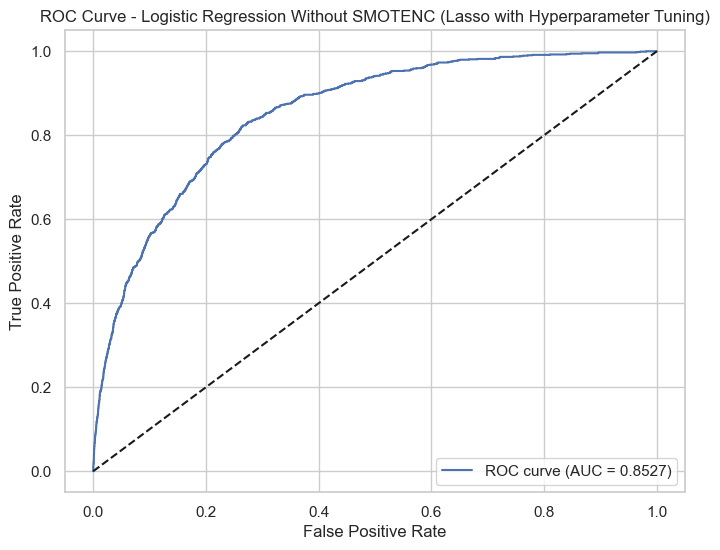

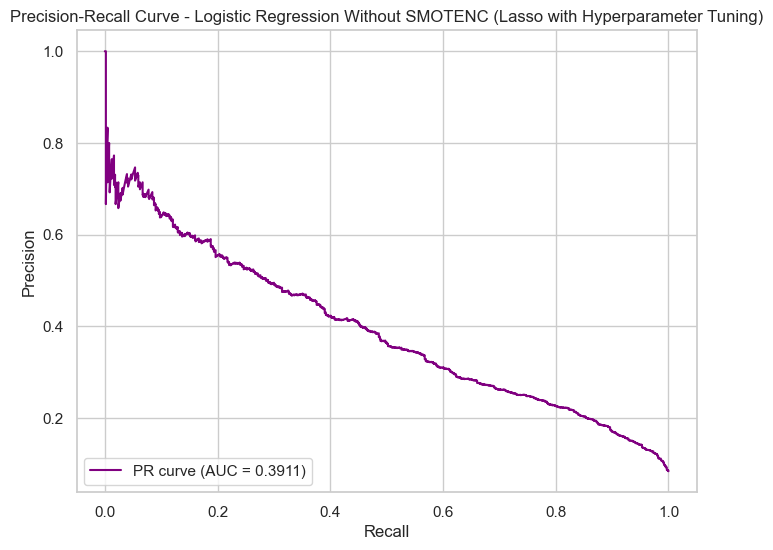

PR AUC Score: 0.3911


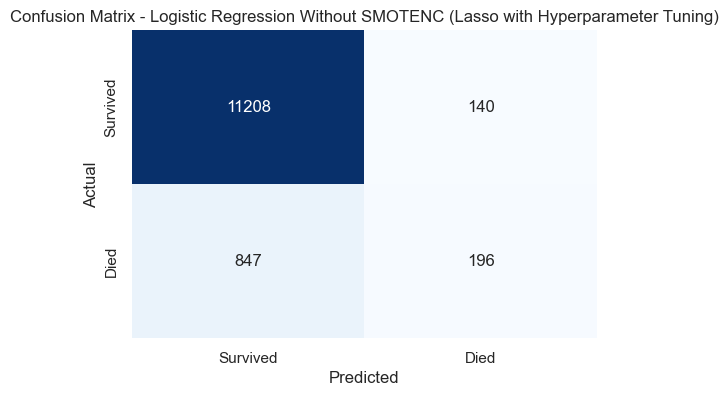

In [785]:
# --- Logistic Regression Without SMOTENC (Lasso Regression with Hyperparameter Tuning and Cross-Validation) ---

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Parameter Grid with Fewer Values ---
param_grid = {
    'C': np.logspace(-2, 2, 5),  # Testing 5 values between 0.01 and 100
}

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Initialize the Logistic Regression Model with L1 Regularization ---
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# --- 4. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# --- 5. Train the Model ---
grid_search.fit(X_train_s_ns, y_train_s_ns)

# --- 6. Get the Best Model ---
best_logreg_ns = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# --- 7. Predict on the Test Set ---
y_pred_proba_ns = best_logreg_ns.predict_proba(X_test_s_ns)[:, 1]
y_pred_ns = best_logreg_ns.predict(X_test_s_ns)

# --- 8. Evaluate the Model ---
print("\n=== Logistic Regression Without SMOTENC (Lasso Regression with Hyperparameter Tuning) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_ns, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_ns))
roc_auc_ns = roc_auc_score(y_test_s_ns, y_pred_proba_ns)
print(f"ROC AUC Score: {roc_auc_ns:.4f}")

# --- 9. Plot ROC Curve ---
fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test_s_ns, y_pred_proba_ns)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ns, tpr_ns, label=f'ROC curve (AUC = {roc_auc_ns:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Without SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 10. Plot Precision-Recall Curve ---
precision_ns, recall_ns, thresholds_pr_ns = precision_recall_curve(y_test_s_ns, y_pred_proba_ns)
pr_auc_ns = auc(recall_ns, precision_ns)
plt.figure(figsize=(8, 6))
plt.plot(recall_ns, precision_ns, label=f'PR curve (AUC = {pr_auc_ns:.4f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression Without SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_ns:.4f}")

# --- 11. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_s_ns,
    y_pred_ns,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - Logistic Regression Without SMOTENC (Lasso with Hyperparameter Tuning)'
)


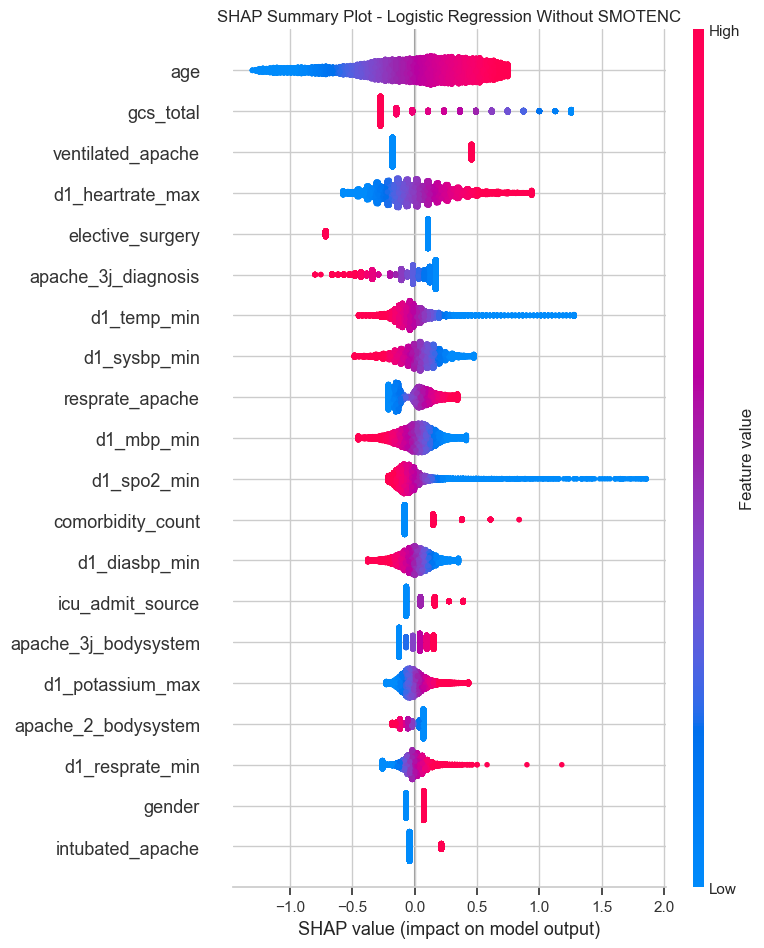

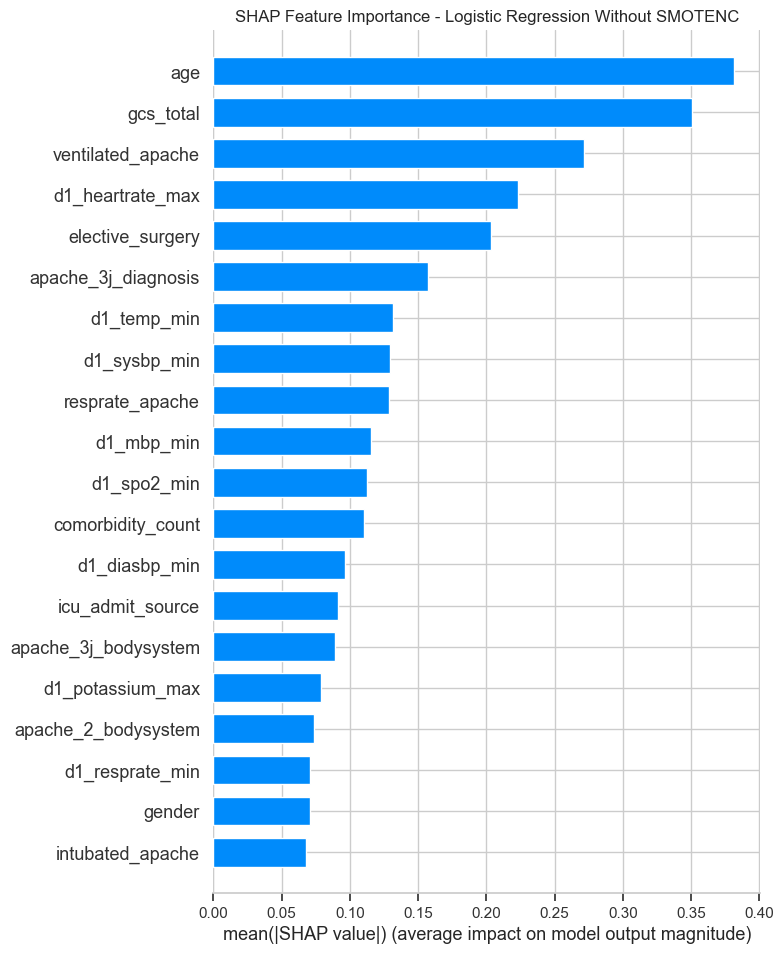

In [786]:
# --- SHAP Analysis for Logistic Regression Without SMOTENC ---

import shap
import matplotlib.pyplot as plt

# --- 1. Create a SHAP Explainer ---
# Since Logistic Regression is a linear model, we can use the LinearExplainer
explainer_ns = shap.LinearExplainer(best_logreg_ns, X_train_s_ns, feature_perturbation="interventional")

# --- 2. Calculate SHAP Values for Test Set ---
shap_values_ns = explainer_ns.shap_values(X_test_s_ns)

# --- 3. Plot Summary Plot ---
# Get feature names from your dataset
feature_names = X_test_s_ns.columns

# Convert shap_values and data to DataFrame for better handling
shap_values_df_ns = pd.DataFrame(shap_values_ns, columns=feature_names)
X_test_df_ns = pd.DataFrame(X_test_s_ns, columns=feature_names)

# Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_ns, X_test_s_ns, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Logistic Regression Without SMOTENC')
plt.show()

# --- 4. Plot Feature Importance Bar Plot ---
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_ns, X_test_s_ns, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Feature Importance - Logistic Regression Without SMOTENC')
plt.show()


### LOG REG WITH SMOTENC

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 0.1}

=== Logistic Regression With SMOTENC (Lasso Regression with Hyperparameter Tuning) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9715    0.7823    0.8667     11348
           1     0.2407    0.7507    0.3645      1043

    accuracy                         0.7797     12391
   macro avg     0.6061    0.7665    0.6156     12391
weighted avg     0.9100    0.7797    0.8245     12391

Confusion Matrix:
[[8878 2470]
 [ 260  783]]
ROC AUC Score: 0.8459


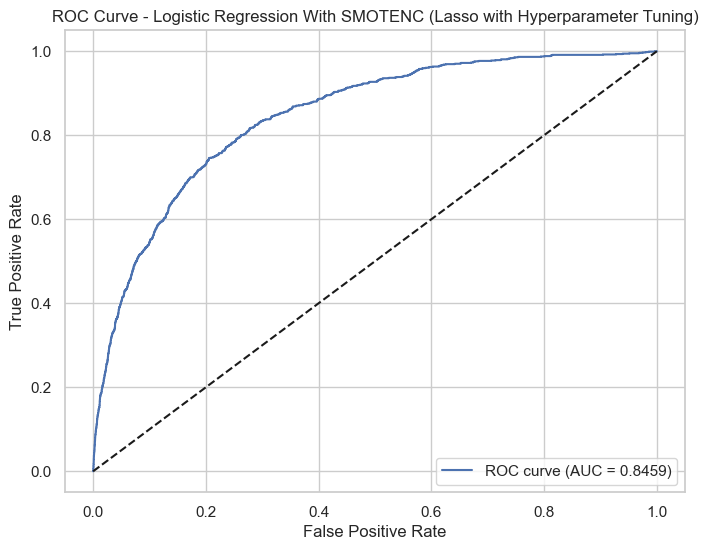

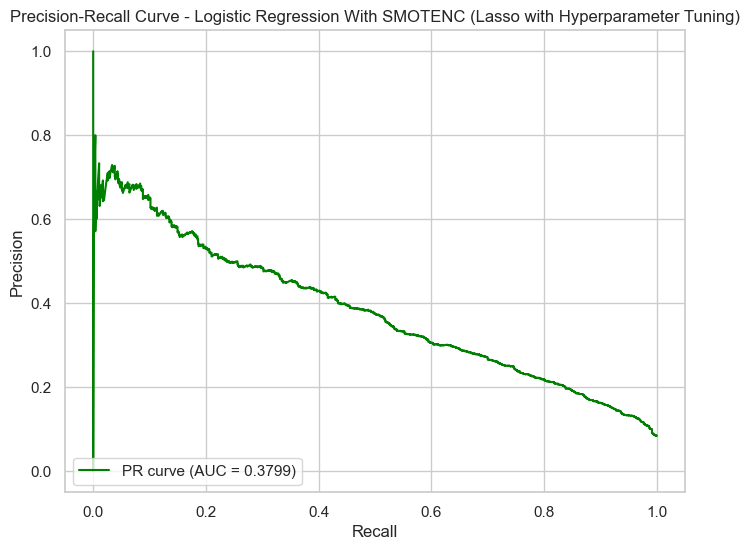

PR AUC Score: 0.3799


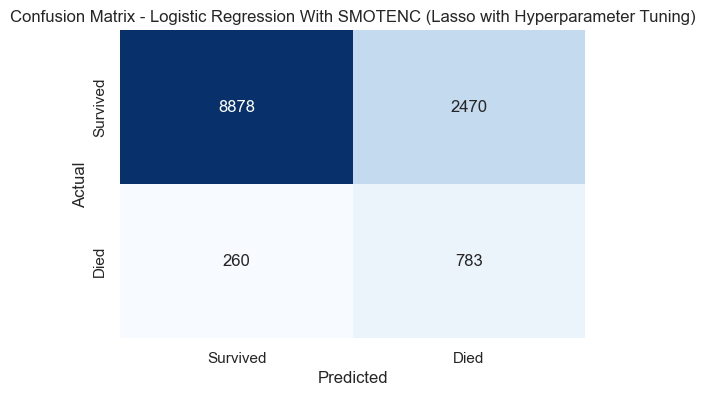

In [787]:
# --- Logistic Regression With SMOTENC (Lasso Regression with Hyperparameter Tuning and Cross-Validation) ---

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Parameter Grid with Fewer Values ---
param_grid = {
    'C': np.logspace(-2, 2, 5),
}

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Initialize the Logistic Regression Model with L1 Regularization ---
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)

# --- 4. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# --- 5. Train the Model ---
grid_search.fit(X_train_s_s, y_train_s_s)

# --- 6. Get the Best Model ---
best_logreg_s = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# --- 7. Predict on the Test Set ---
y_pred_proba_s = best_logreg_s.predict_proba(X_test_s_s)[:, 1]
y_pred_s = best_logreg_s.predict(X_test_s_s)

# --- 8. Evaluate the Model ---
print("\n=== Logistic Regression With SMOTENC (Lasso Regression with Hyperparameter Tuning) ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_s, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_s))
roc_auc_s = roc_auc_score(y_test_s_s, y_pred_proba_s)
print(f"ROC AUC Score: {roc_auc_s:.4f}")

# --- 9. Plot ROC Curve ---
fpr_s, tpr_s, thresholds_s = roc_curve(y_test_s_s, y_pred_proba_s)
plt.figure(figsize=(8, 6))
plt.plot(fpr_s, tpr_s, label=f'ROC curve (AUC = {roc_auc_s:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 10. Plot Precision-Recall Curve ---
precision_s, recall_s, thresholds_pr_s = precision_recall_curve(y_test_s_s, y_pred_proba_s)
pr_auc_s = auc(recall_s, precision_s)
plt.figure(figsize=(8, 6))
plt.plot(recall_s, precision_s, label=f'PR curve (AUC = {pr_auc_s:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_s:.4f}")

# --- 11. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_s_s,
    y_pred_s,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)'
)



Threshold for desired recall of 90%: 0.26
Precision: 0.1609, Recall: 0.9032, F1-score: 0.2732

=== Logistic Regression With SMOTENC (Threshold: 0.26) (Lasso Regression) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9845    0.5671    0.7197     11348
           1     0.1609    0.9032    0.2732      1043

    accuracy                         0.5954     12391
   macro avg     0.5727    0.7352    0.4964     12391
weighted avg     0.9152    0.5954    0.6821     12391

Confusion Matrix:
[[6436 4912]
 [ 101  942]]
ROC AUC Score: 0.8459


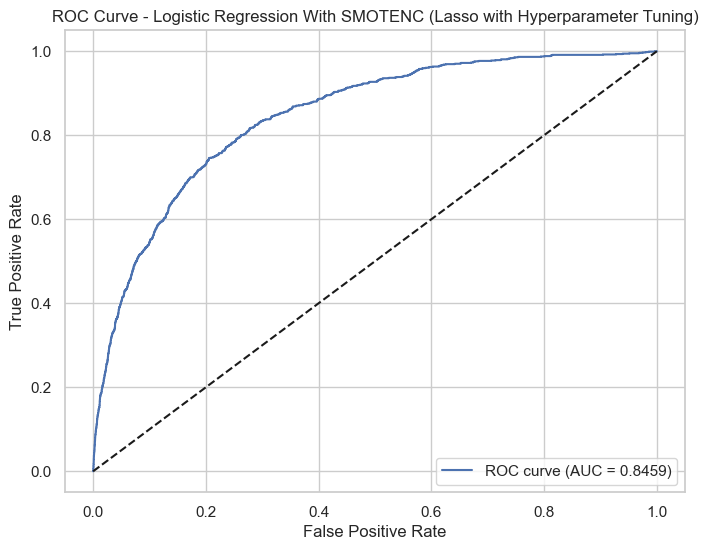

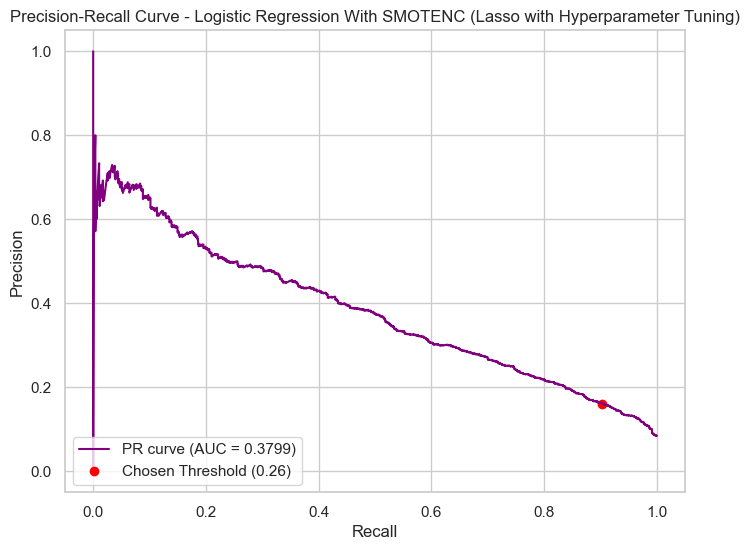

PR AUC Score: 0.3799


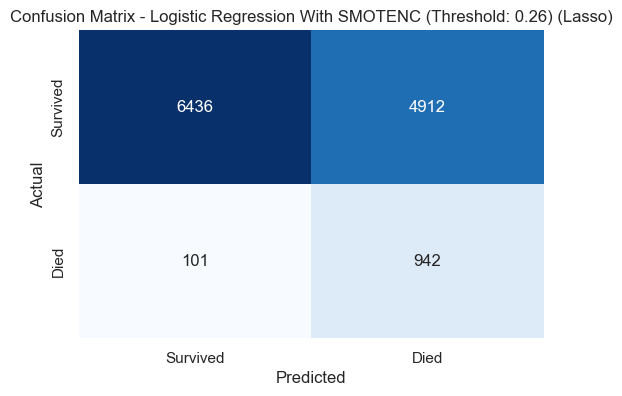

In [788]:
# --- Logistic Regression With SMOTENC (Adjusting Threshold for Desired Recall) (Lasso Regression) ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# --- Assuming model_lr_s is already trained and y_pred_proba_s is computed ---

# --- 1. Compute Precision-Recall Curve ---
precision_s, recall_s, thresholds_pr_s = precision_recall_curve(y_test_s_s, y_pred_proba_s)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_s = evaluate_thresholds(y_test_s_s, y_pred_proba_s, thresholds_to_evaluate)

# Convert to DataFrame for easy analysis
metrics_df_s = pd.DataFrame(metrics_s)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
# Find the threshold closest to the desired recall
metrics_df_s['recall_diff'] = metrics_df_s['recall'] - desired_recall
metrics_df_s['recall_diff'] = metrics_df_s['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_s['recall_diff'].idxmin()
if not np.isnan(optimal_index):
    optimal_threshold_s = metrics_df_s.loc[optimal_index, 'threshold']
    precision_at_desired_recall = metrics_df_s.loc[optimal_index, 'precision']
    recall_at_desired_recall = metrics_df_s.loc[optimal_index, 'recall']
    f1_at_desired_recall = metrics_df_s.loc[optimal_index, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_s:.2f}")
    print(f"Precision: {precision_at_desired_recall:.4f}, Recall: {recall_at_desired_recall:.4f}, F1-score: {f1_at_desired_recall:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_s = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_s = (y_pred_proba_s >= optimal_threshold_s).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Logistic Regression With SMOTENC (Threshold: {optimal_threshold_s:.2f}) (Lasso Regression) ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_optimal_s, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_optimal_s))
roc_auc_s = roc_auc_score(y_test_s_s, y_pred_proba_s)
print(f"ROC AUC Score: {roc_auc_s:.4f}")

# --- 6. Plot ROC Curve ---
fpr_s, tpr_s, thresholds_s = roc_curve(y_test_s_s, y_pred_proba_s)
plt.figure(figsize=(8, 6))
plt.plot(fpr_s, tpr_s, label=f'ROC curve (AUC = {roc_auc_s:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_curve_s, recall_curve_s, thresholds_pr_s = precision_recall_curve(y_test_s_s, y_pred_proba_s)
pr_auc_s = auc(recall_curve_s, precision_curve_s)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_s, precision_curve_s, label=f'PR curve (AUC = {pr_auc_s:.4f})', color='purple')
plt.scatter(recall_at_desired_recall, precision_at_desired_recall, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_s:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Logistic Regression With SMOTENC (Lasso with Hyperparameter Tuning)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_s:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_s_s,
    y_pred_optimal_s,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - Logistic Regression With SMOTENC (Threshold: {:.2f}) (Lasso)'.format(optimal_threshold_s)
)


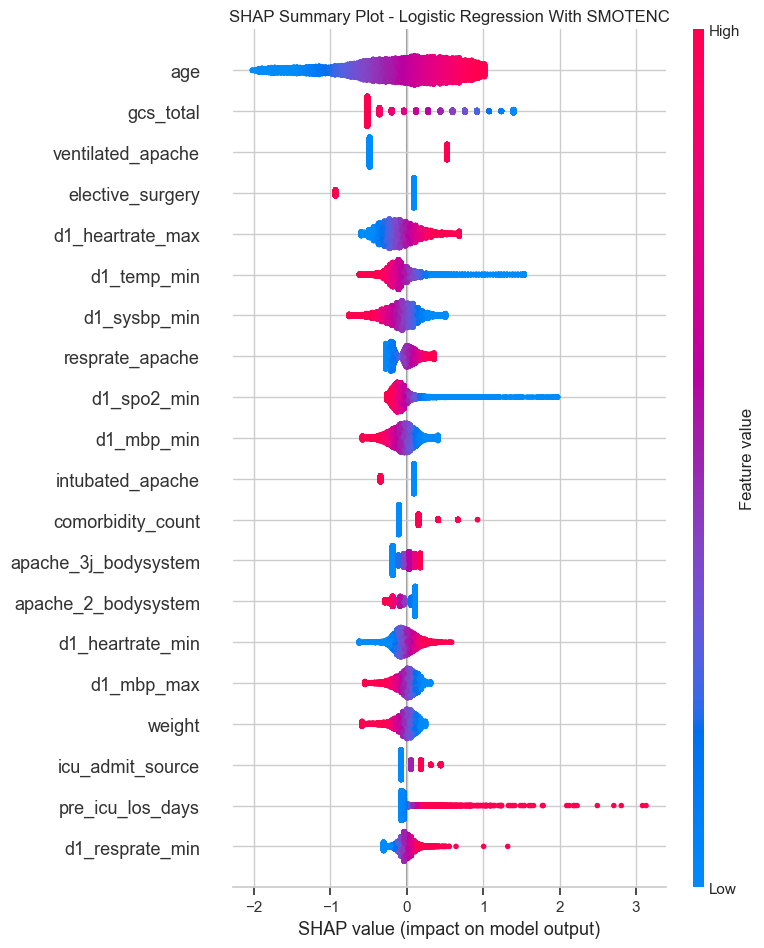

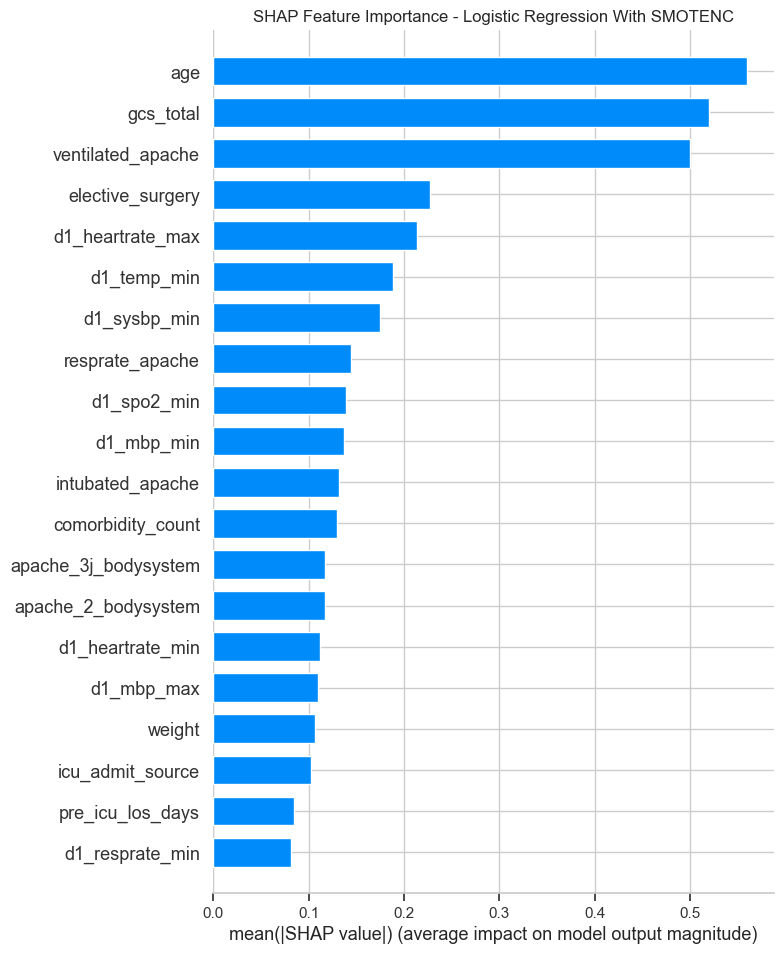

In [789]:
# --- SHAP Analysis for Logistic Regression With SMOTENC ---

import shap
import matplotlib.pyplot as plt

# --- 1. Create a SHAP Explainer ---
explainer_s = shap.LinearExplainer(best_logreg_s, X_train_s_s, feature_perturbation="interventional")

# --- 2. Calculate SHAP Values for Test Set ---
shap_values_s = explainer_s.shap_values(X_test_s_s)

# --- 3. Plot Summary Plot ---
feature_names = X_test_s_s.columns

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_s, X_test_s_s, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Logistic Regression With SMOTENC')
plt.show()

# --- 4. Plot Feature Importance Bar Plot ---
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_s, X_test_s_s, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Feature Importance - Logistic Regression With SMOTENC')
plt.show()


### Logistic Regression Without SMOTENC Using class_weight

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Hyperparameters: {'C': 0.1}

=== Logistic Regression with class_weight='balanced' (Lasso Regression with Hyperparameter Tuning) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9733    0.7827    0.8676     11348
           1     0.2447    0.7661    0.3709      1043

    accuracy                         0.7813     12391
   macro avg     0.6090    0.7744    0.6193     12391
weighted avg     0.9119    0.7813    0.8258     12391

Confusion Matrix:
[[8882 2466]
 [ 244  799]]
ROC AUC Score: 0.8543


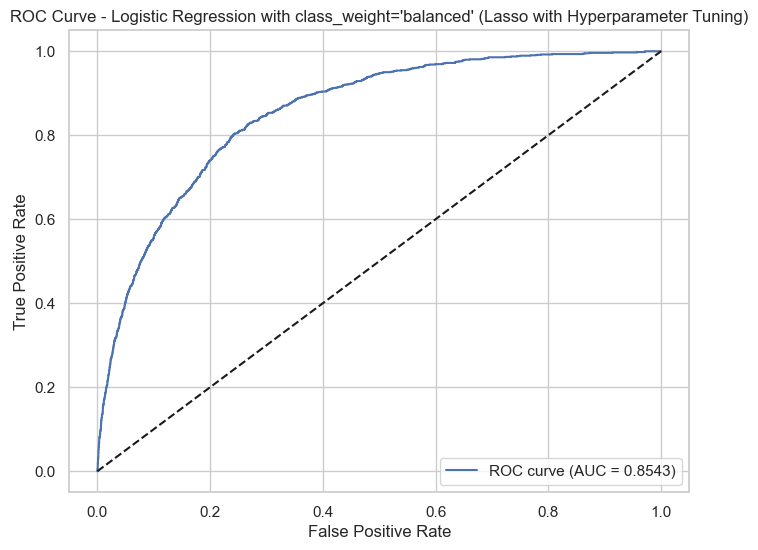

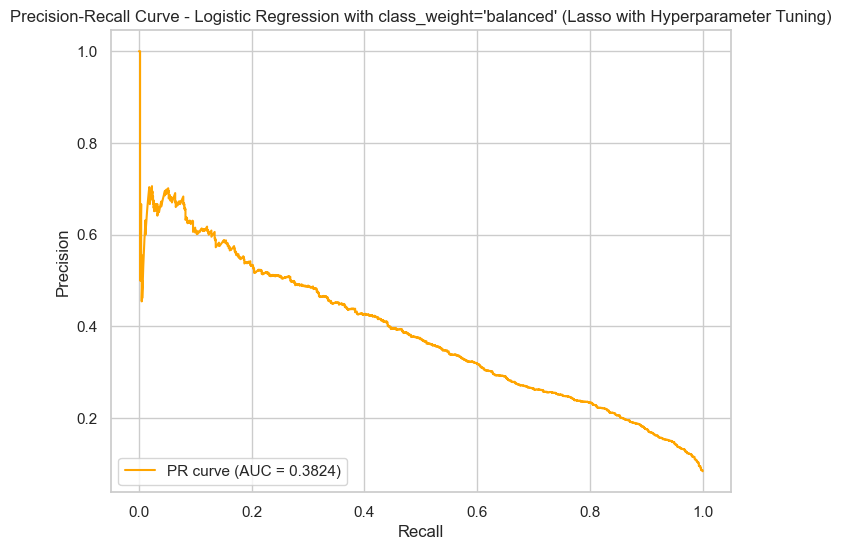

PR AUC Score: 0.3824


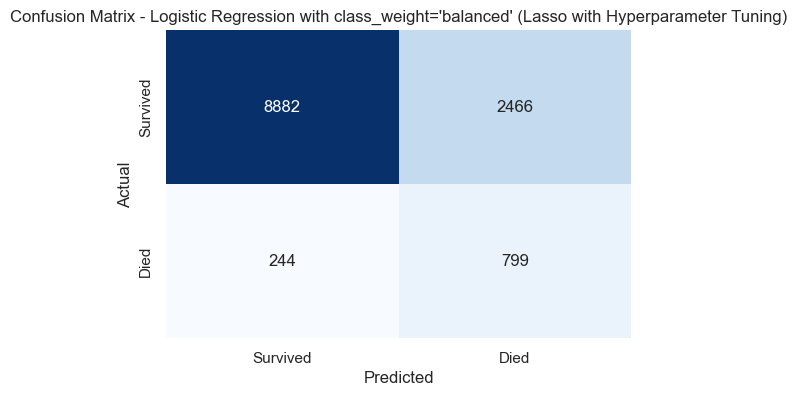

In [790]:
# --- Logistic Regression with class_weight='balanced' (Lasso Regression with Hyperparameter Tuning and Cross-Validation) ---

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Parameter Grid with Fewer Values ---
param_grid = {
    'C': np.logspace(-2, 2, 5),
}

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Initialize the Logistic Regression Model with L1 Regularization and class_weight='balanced' ---
logreg = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

# --- 4. Set up GridSearchCV ---
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# --- 5. Train the Model ---
grid_search.fit(X_train_s_ns, y_train_s_ns)

# --- 6. Get the Best Model ---
best_logreg_balanced = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# --- 7. Predict on the Test Set ---
y_pred_proba_balanced = best_logreg_balanced.predict_proba(X_test_s_ns)[:, 1]
y_pred_balanced = best_logreg_balanced.predict(X_test_s_ns)

# --- 8. Evaluate the Model ---
print("\n=== Logistic Regression with class_weight='balanced' (Lasso Regression with Hyperparameter Tuning) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_balanced, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_balanced))
roc_auc_balanced = roc_auc_score(y_test_s_ns, y_pred_proba_balanced)
print(f"ROC AUC Score: {roc_auc_balanced:.4f}")

# --- 9. Plot ROC Curve ---
fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test_s_ns, y_pred_proba_balanced)
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f'ROC curve (AUC = {roc_auc_balanced:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Logistic Regression with class_weight='balanced' (Lasso with Hyperparameter Tuning)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 10. Plot Precision-Recall Curve ---
precision_balanced, recall_balanced, thresholds_pr_balanced = precision_recall_curve(y_test_s_ns, y_pred_proba_balanced)
pr_auc_balanced = auc(recall_balanced, precision_balanced)
plt.figure(figsize=(8, 6))
plt.plot(recall_balanced, precision_balanced, label=f'PR curve (AUC = {pr_auc_balanced:.4f})', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve - Logistic Regression with class_weight='balanced' (Lasso with Hyperparameter Tuning)")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_balanced:.4f}")

# --- 11. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_balanced,
    classes=['Survived', 'Died'],
    title="Confusion Matrix - Logistic Regression with class_weight='balanced' (Lasso with Hyperparameter Tuning)"
)



Threshold for desired recall of 90%: 0.31
Precision: 0.1728, Recall: 0.9041, F1-score: 0.2902

=== Logistic Regression with class_weight='balanced' (Threshold: 0.31) (Lasso Regression) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9856    0.6022    0.7476     11348
           1     0.1728    0.9041    0.2902      1043

    accuracy                         0.6276     12391
   macro avg     0.5792    0.7532    0.5189     12391
weighted avg     0.9172    0.6276    0.7091     12391

Confusion Matrix:
[[6834 4514]
 [ 100  943]]
ROC AUC Score: 0.8543


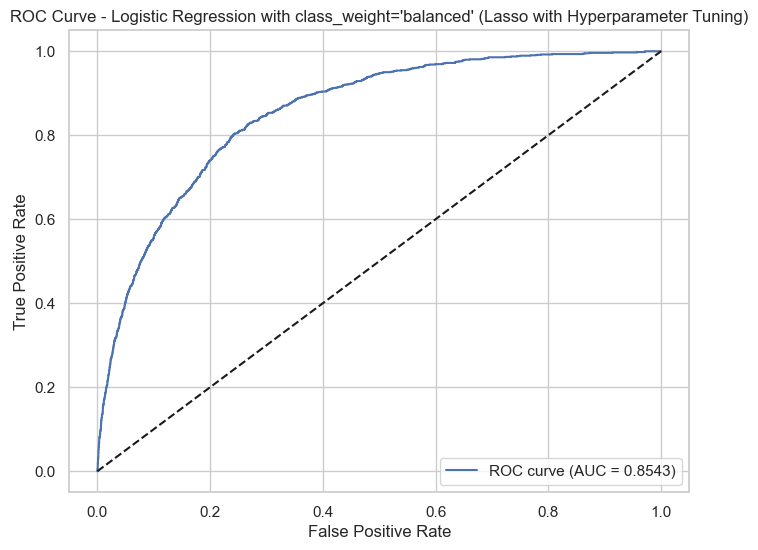

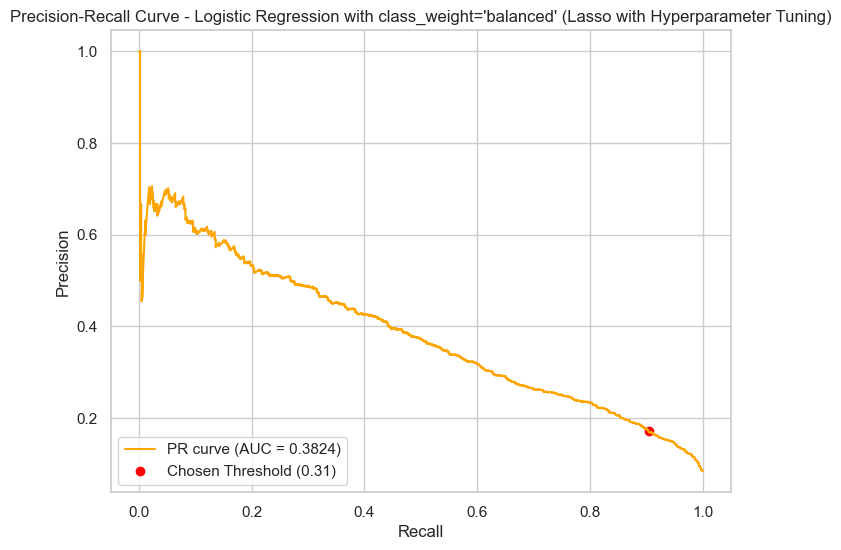

PR AUC Score: 0.3824


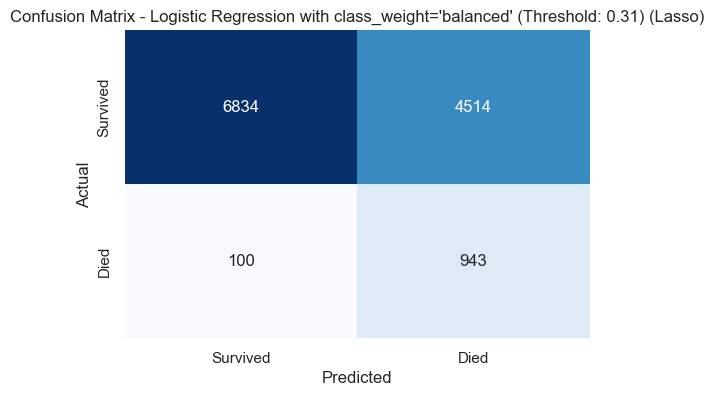

In [791]:
# --- Logistic Regression with class_weight='balanced' (Adjusting Threshold for Desired Recall) (Lasso Regression) ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# --- Assuming model_lr_balanced is already trained and y_pred_proba_balanced is computed ---

# --- 1. Compute Precision-Recall Curve ---
precision_balanced, recall_balanced, thresholds_pr_balanced = precision_recall_curve(y_test_s_ns, y_pred_proba_balanced)

# --- 2. Evaluate Metrics at Various Thresholds ---
metrics_balanced = evaluate_thresholds(y_test_s_ns, y_pred_proba_balanced, thresholds_to_evaluate)
metrics_df_balanced = pd.DataFrame(metrics_balanced)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
metrics_df_balanced['recall_diff'] = metrics_df_balanced['recall'] - desired_recall
metrics_df_balanced['recall_diff'] = metrics_df_balanced['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_balanced = metrics_df_balanced['recall_diff'].idxmin()
if not np.isnan(optimal_index_balanced):
    optimal_threshold_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'threshold']
    precision_at_desired_recall_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'precision']
    recall_at_desired_recall_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'recall']
    f1_at_desired_recall_balanced = metrics_df_balanced.loc[optimal_index_balanced, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_balanced:.2f}")
    print(f"Precision: {precision_at_desired_recall_balanced:.4f}, Recall: {recall_at_desired_recall_balanced:.4f}, F1-score: {f1_at_desired_recall_balanced:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_balanced = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_balanced = (y_pred_proba_balanced >= optimal_threshold_balanced).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Logistic Regression with class_weight='balanced' (Threshold: {optimal_threshold_balanced:.2f}) (Lasso Regression) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_optimal_balanced, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_optimal_balanced))
roc_auc_balanced = roc_auc_score(y_test_s_ns, y_pred_proba_balanced)
print(f"ROC AUC Score: {roc_auc_balanced:.4f}")

# --- 6. Plot ROC Curve ---
fpr_balanced, tpr_balanced, thresholds_balanced = roc_curve(y_test_s_ns, y_pred_proba_balanced)
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, label=f'ROC curve (AUC = {roc_auc_balanced:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Logistic Regression with class_weight='balanced' (Lasso with Hyperparameter Tuning)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_curve_balanced, recall_curve_balanced, thresholds_pr_balanced = precision_recall_curve(y_test_s_ns, y_pred_proba_balanced)
pr_auc_balanced = auc(recall_curve_balanced, precision_curve_balanced)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_balanced, precision_curve_balanced, label=f'PR curve (AUC = {pr_auc_balanced:.4f})', color='orange')
plt.scatter(recall_at_desired_recall_balanced, precision_at_desired_recall_balanced, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_balanced:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall Curve - Logistic Regression with class_weight='balanced' (Lasso with Hyperparameter Tuning)")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_balanced:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_s_ns,
    y_pred_optimal_balanced,
    classes=['Survived', 'Died'],
    title=f"Confusion Matrix - Logistic Regression with class_weight='balanced' (Threshold: {optimal_threshold_balanced:.2f}) (Lasso)"
)


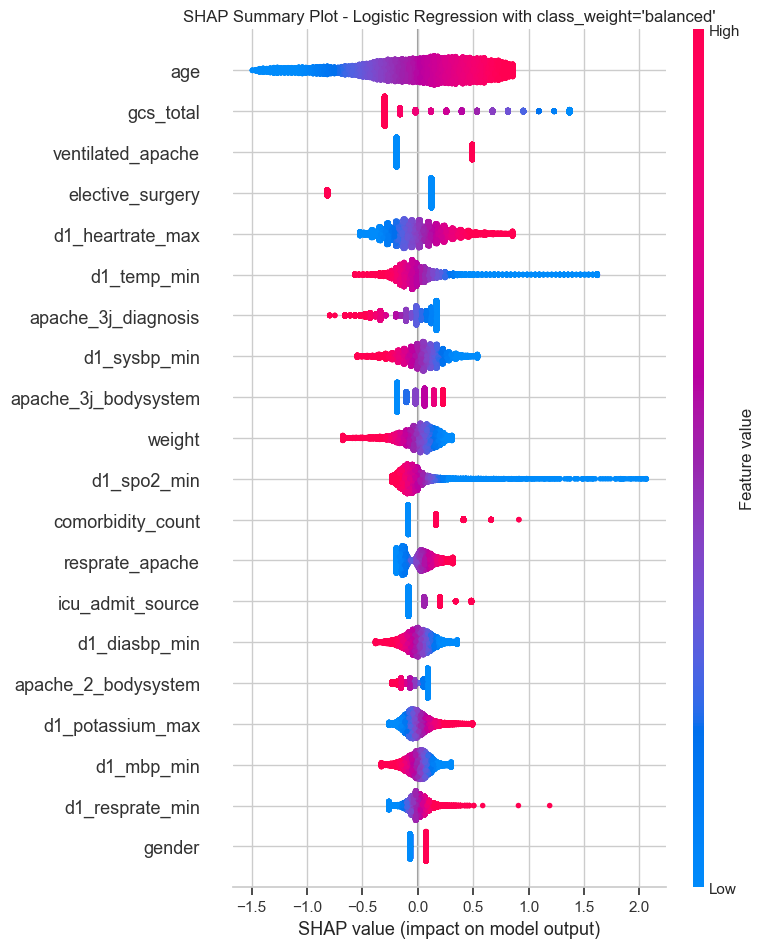

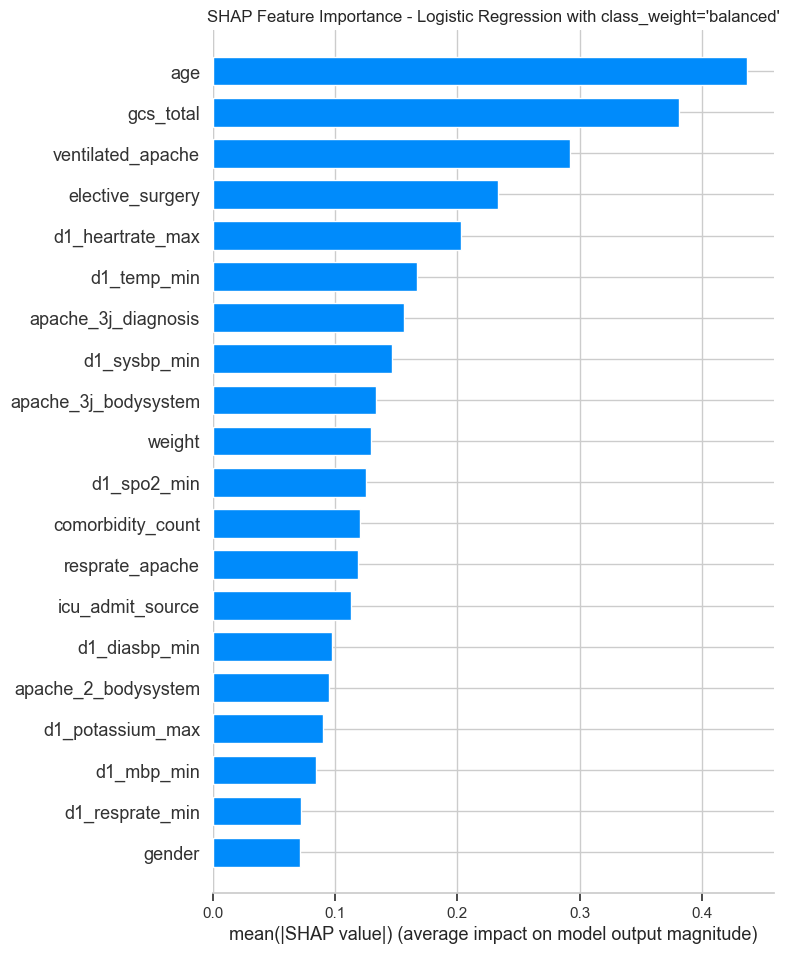

In [792]:
# --- SHAP Analysis for Logistic Regression with class_weight='balanced' ---

import shap
import matplotlib.pyplot as plt

# --- 1. Create a SHAP Explainer ---
explainer_balanced = shap.LinearExplainer(best_logreg_balanced, X_train_s_ns, feature_perturbation="interventional")

# --- 2. Calculate SHAP Values for Test Set ---
shap_values_balanced = explainer_balanced.shap_values(X_test_s_ns)

# --- 3. Plot Summary Plot ---
feature_names = X_test_s_ns.columns

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_balanced, X_test_s_ns, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Logistic Regression with class_weight=\'balanced\'')
plt.show()

# --- 4. Plot Feature Importance Bar Plot ---
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_balanced, X_test_s_ns, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Feature Importance - Logistic Regression with class_weight=\'balanced\'')
plt.show()


Interpretation:
Model 3 achieves the highest recall for deaths but at the cost of a high number of false positives and low precision.
Model 2 balances recall and precision for deaths better than Model 3 but still has many false positives.
Model 1 has high precision for deaths but very low recall, meaning it fails to identify most deaths.



### Random Forest


=== Random Forest Without Scaling and Without SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9284    0.9922    0.9592     11348
           1     0.6641    0.1668    0.2667      1043

    accuracy                         0.9228     12391
   macro avg     0.7962    0.5795    0.6130     12391
weighted avg     0.9061    0.9228    0.9009     12391

Confusion Matrix:
[[11260    88]
 [  869   174]]
ROC AUC Score: 0.8530


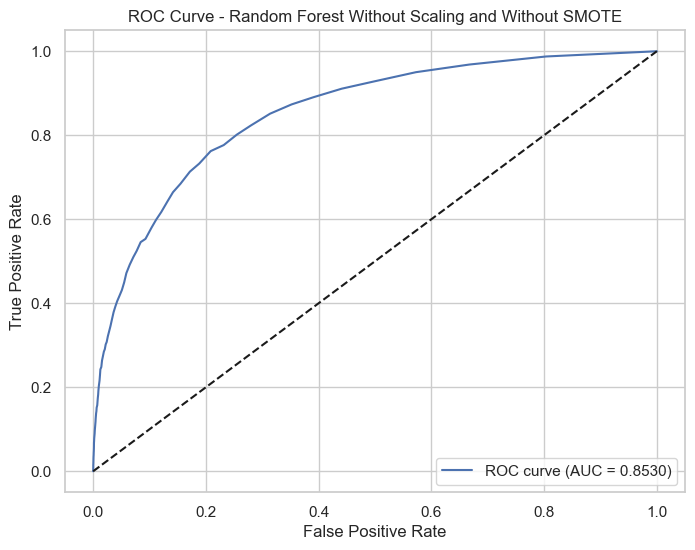

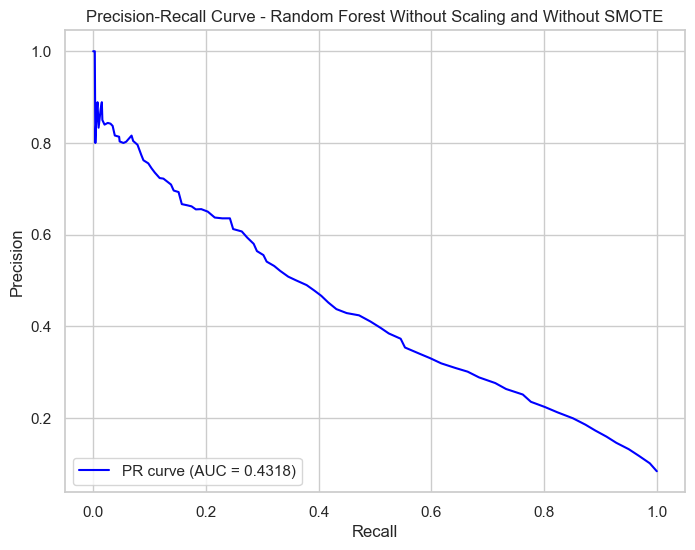

PR AUC Score: 0.4318


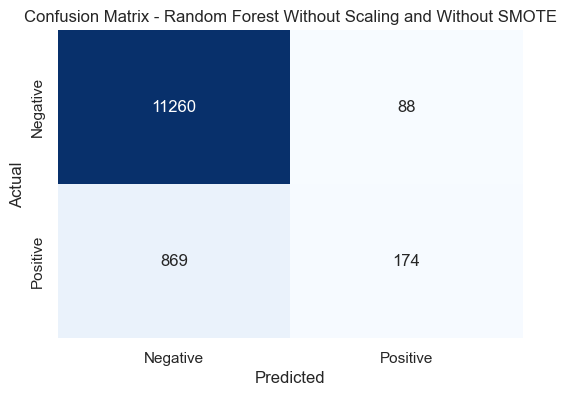

In [793]:
# --- Random Forest Without Scaling and Without SMOTE ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the Random Forest Model ---
rf_model1 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# --- 2. Train the Model ---
rf_model1.fit(X_train_ns_ns, y_train_ns_ns)

# --- 3. Predict on the Test Set ---
y_pred_proba_model1 = rf_model1.predict_proba(X_test_ns_ns)[:, 1]
y_pred_model1 = rf_model1.predict(X_test_ns_ns)

# --- 4. Evaluate the Model ---
print("\n=== Random Forest Without Scaling and Without SMOTE ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_model1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_model1))
roc_auc_model1 = roc_auc_score(y_test_ns_ns, y_pred_proba_model1)
print(f"ROC AUC Score: {roc_auc_model1:.4f}")

# --- 5. Plot ROC Curve ---
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test_ns_ns, y_pred_proba_model1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label=f'ROC curve (AUC = {roc_auc_model1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Without Scaling and Without SMOTE')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 6. Plot Precision-Recall Curve ---
precision_model1, recall_model1, thresholds_pr_model1 = precision_recall_curve(y_test_ns_ns, y_pred_proba_model1)
pr_auc_model1 = auc(recall_model1, precision_model1)
plt.figure(figsize=(8, 6))
plt.plot(recall_model1, precision_model1, label=f'PR curve (AUC = {pr_auc_model1:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Without Scaling and Without SMOTE')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model1:.4f}")

# --- 7. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_model1,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Random Forest Without Scaling and Without SMOTE'
)


Cross-Validated ROC AUC Scores: [0.9893624  0.98914296 0.98930752 0.98976703 0.98951331]
Mean ROC AUC Score: 0.9894

=== Random Forest Without Scaling and With SMOTE ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9441    0.9459    0.9450     11348
           1     0.3992    0.3912    0.3952      1043

    accuracy                         0.8992     12391
   macro avg     0.6717    0.6685    0.6701     12391
weighted avg     0.8983    0.8992    0.8987     12391

Confusion Matrix:
[[10734   614]
 [  635   408]]
ROC AUC Score: 0.8511


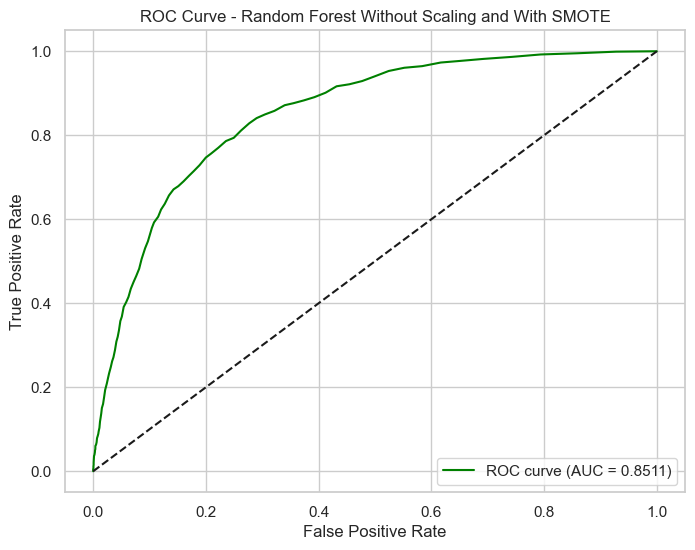

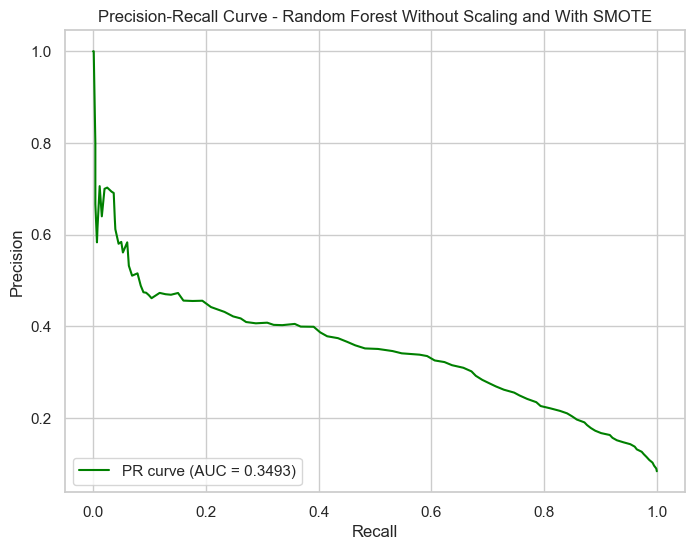

PR AUC Score: 0.3493


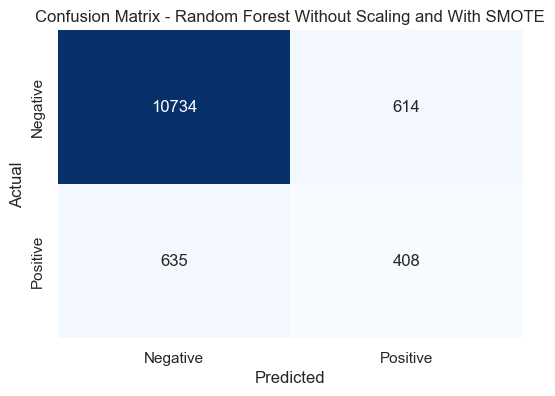

In [794]:
# --- Random Forest Without Scaling and With SMOTE with K-Fold Cross-Validation ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the Random Forest Model ---
rf_model2 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Perform Cross-Validation ---
cv_scores = cross_val_score(
    rf_model2,
    X_train_ns_s,
    y_train_ns_s,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 4. Train the Model on the Full Training Data ---
rf_model2.fit(X_train_ns_s, y_train_ns_s)

# --- 5. Predict on the Test Set ---
y_pred_proba_model2 = rf_model2.predict_proba(X_test_ns_s)[:, 1]
y_pred_model2 = rf_model2.predict(X_test_ns_s)

# --- 6. Evaluate the Model ---
print("\n=== Random Forest Without Scaling and With SMOTE ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_model2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_model2))
roc_auc_model2 = roc_auc_score(y_test_ns_s, y_pred_proba_model2)
print(f"ROC AUC Score: {roc_auc_model2:.4f}")

# --- 7. Plot ROC Curve ---
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_test_ns_s, y_pred_proba_model2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model2, tpr_model2, label=f'ROC curve (AUC = {roc_auc_model2:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Without Scaling and With SMOTE')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Plot Precision-Recall Curve ---
precision_model2, recall_model2, thresholds_pr_model2 = precision_recall_curve(y_test_ns_s, y_pred_proba_model2)
pr_auc_model2 = auc(recall_model2, precision_model2)
plt.figure(figsize=(8, 6))
plt.plot(recall_model2, precision_model2, label=f'PR curve (AUC = {pr_auc_model2:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Without Scaling and With SMOTE')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model2:.4f}")

# --- 9. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_s,
    y_pred_model2,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Random Forest Without Scaling and With SMOTE'
)


Cross-Validated ROC AUC Scores: [0.85287325 0.85999182 0.86397893 0.85403984 0.85822168]
Mean ROC AUC Score: 0.8578

=== Random Forest Without Scaling, Without SMOTE, With Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9236    0.9965    0.9586     11348
           1     0.7279    0.1026    0.1798      1043

    accuracy                         0.9212     12391
   macro avg     0.8257    0.5495    0.5692     12391
weighted avg     0.9071    0.9212    0.8931     12391

Confusion Matrix:
[[11308    40]
 [  936   107]]
ROC AUC Score: 0.8530


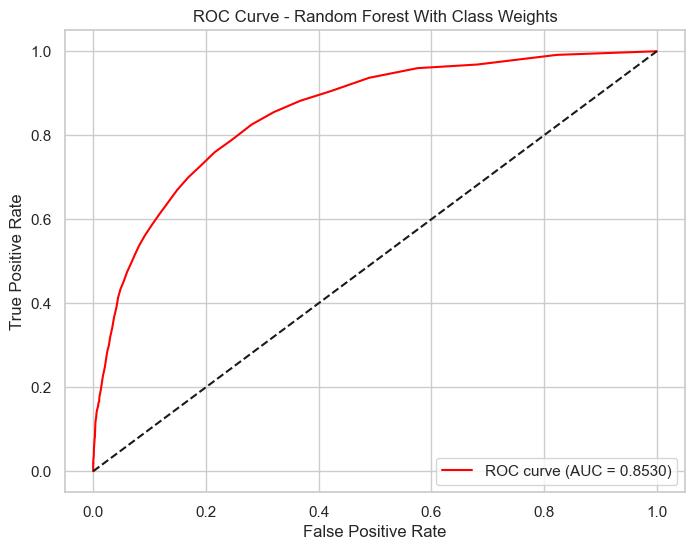

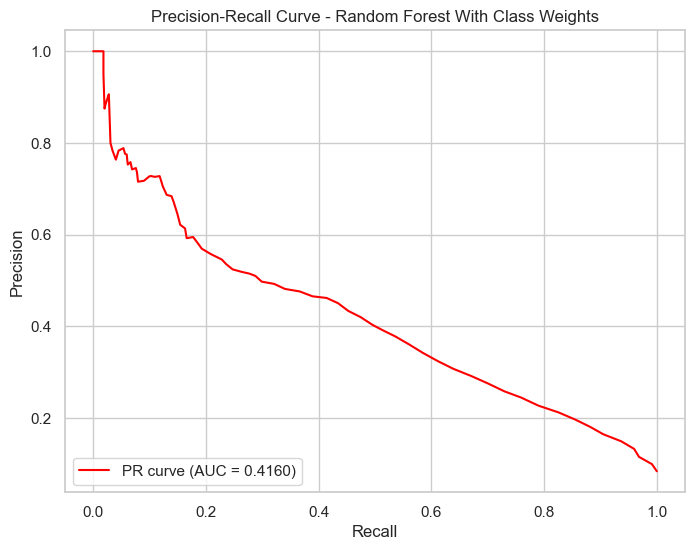

PR AUC Score: 0.4160


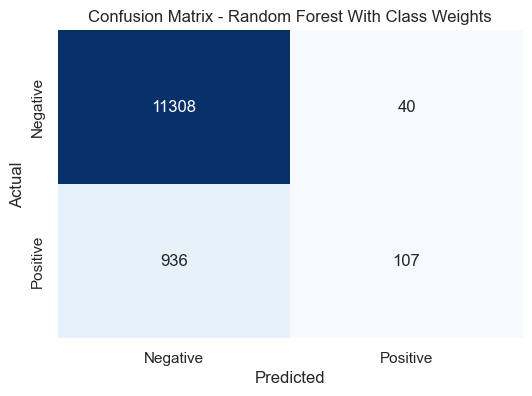

In [795]:
# --- Random Forest Without Scaling, Without SMOTE, With Class Weights and K-Fold Cross-Validation ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the Random Forest Model with class_weight='balanced' ---
rf_model3 = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# --- 2. Set up Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 3. Perform Cross-Validation ---
cv_scores = cross_val_score(
    rf_model3,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 4. Train the Model on the Full Training Data ---
rf_model3.fit(X_train_ns_ns, y_train_ns_ns)

# --- 5. Predict on the Test Set ---
y_pred_proba_model3 = rf_model3.predict_proba(X_test_ns_ns)[:, 1]
y_pred_model3 = rf_model3.predict(X_test_ns_ns)

# --- 6. Evaluate the Model ---
print("\n=== Random Forest Without Scaling, Without SMOTE, With Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_model3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_model3))
roc_auc_model3 = roc_auc_score(y_test_ns_ns, y_pred_proba_model3)
print(f"ROC AUC Score: {roc_auc_model3:.4f}")

# --- 7. Plot ROC Curve ---
fpr_model3, tpr_model3, thresholds_model3 = roc_curve(y_test_ns_ns, y_pred_proba_model3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model3, tpr_model3, label=f'ROC curve (AUC = {roc_auc_model3:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest With Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Plot Precision-Recall Curve ---
precision_model3, recall_model3, thresholds_pr_model3 = precision_recall_curve(y_test_ns_ns, y_pred_proba_model3)
pr_auc_model3 = auc(recall_model3, precision_model3)
plt.figure(figsize=(8, 6))
plt.plot(recall_model3, precision_model3, label=f'PR curve (AUC = {pr_auc_model3:.4f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest With Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model3:.4f}")

# --- 9. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_model3,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Random Forest With Class Weights'
)



Threshold for desired recall of 90%: 0.15
Precision: 0.1673, Recall: 0.9012, F1-score: 0.2822

=== Model with Adjusted Threshold (0.15) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9848    0.5878    0.7362     11348
           1     0.1673    0.9012    0.2822      1043

    accuracy                         0.6142     12391
   macro avg     0.5761    0.7445    0.5092     12391
weighted avg     0.9160    0.6142    0.6980     12391

Confusion Matrix:
[[6670 4678]
 [ 103  940]]
ROC AUC Score: 0.8511


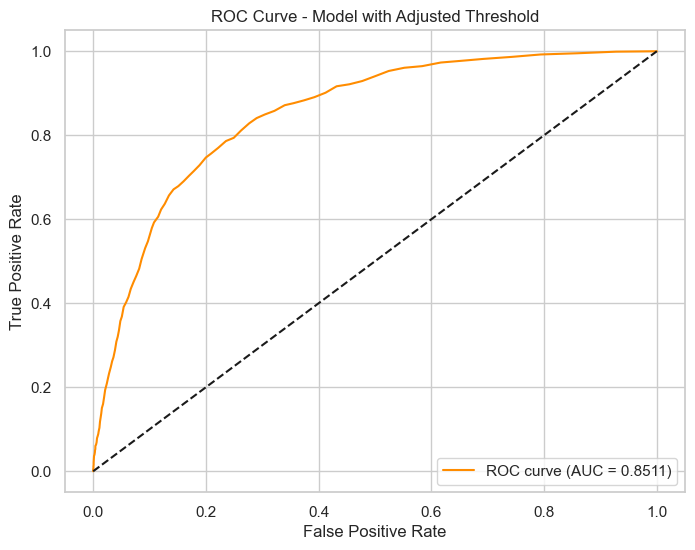

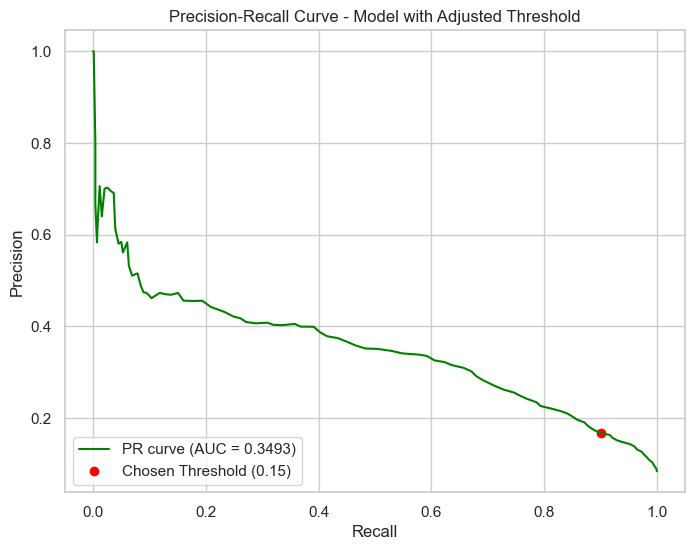

PR AUC Score: 0.3493


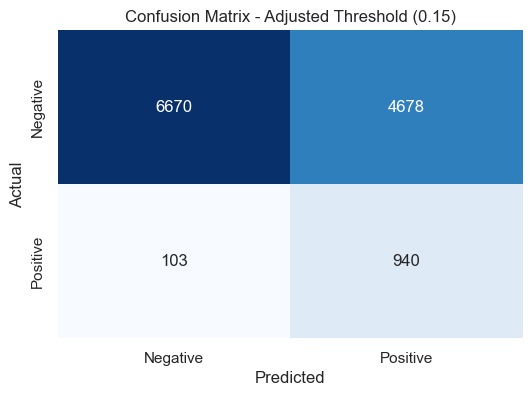

In [796]:
# --- Adjusting Threshold for Desired Recall ---

from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Variables to Change for Different Models ---
# Replace these variables with the corresponding variables from the model you want to adjust
# Example for rf_model2:
# y_test = y_test_ns_s
# y_pred_proba = y_pred_proba_model2

# Example for rf_model3:
# y_test = y_test_ns_ns
# y_pred_proba = y_pred_proba_model3

# For demonstration, let's assume we're adjusting rf_model2
y_test = y_test_ns_s
y_pred_proba = y_pred_proba_model2

# --- 1. Compute Precision-Recall Curve ---
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision_ = precision_score(y_true, y_pred, zero_division=0)
        recall_ = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision_,
            'recall': recall_,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics = evaluate_thresholds(y_test, y_pred_proba, thresholds_to_evaluate)

# Convert to DataFrame for easy analysis
metrics_df = pd.DataFrame(metrics)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
metrics_df['recall_diff'] = metrics_df['recall'] - desired_recall
metrics_df['recall_diff'] = metrics_df['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df['recall_diff'].idxmin()
if not np.isnan(optimal_index):
    optimal_threshold = metrics_df.loc[optimal_index, 'threshold']
    precision_at_desired_recall = metrics_df.loc[optimal_index, 'precision']
    recall_at_desired_recall = metrics_df.loc[optimal_index, 'recall']
    f1_at_desired_recall = metrics_df.loc[optimal_index, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_desired_recall:.4f}, Recall: {recall_at_desired_recall:.4f}, F1-score: {f1_at_desired_recall:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Model with Adjusted Threshold ({optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test, y_pred_optimal, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# --- 6. Plot ROC Curve ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model with Adjusted Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.4f})', color='green')
plt.scatter(recall_at_desired_recall, precision_at_desired_recall, color='red', 
            label=f'Chosen Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Model with Adjusted Threshold')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test,
    y_pred_optimal,
    classes=['Negative', 'Positive'],
    title=f'Confusion Matrix - Adjusted Threshold ({optimal_threshold:.2f})'
)


## DT

### NO SMOTENEC (Not Scaled)

Cross-Validated ROC AUC Scores: [0.62261172 0.62155281 0.62448906 0.62062359 0.62801444]
Mean ROC AUC Score: 0.6235

=== Decision Tree Without SMOTENC and Without Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9360    0.9261    0.9310     11348
           1     0.2786    0.3106    0.2937      1043

    accuracy                         0.8743     12391
   macro avg     0.6073    0.6184    0.6124     12391
weighted avg     0.8806    0.8743    0.8773     12391

Confusion Matrix:
[[10509   839]
 [  719   324]]
ROC AUC Score: 0.6184


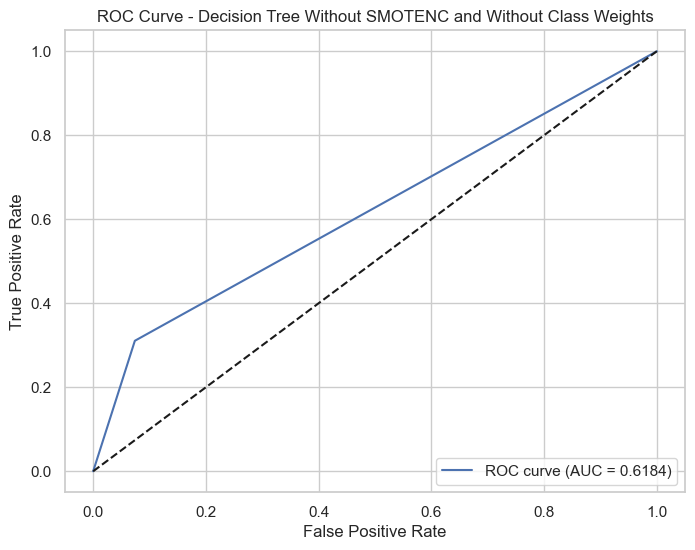

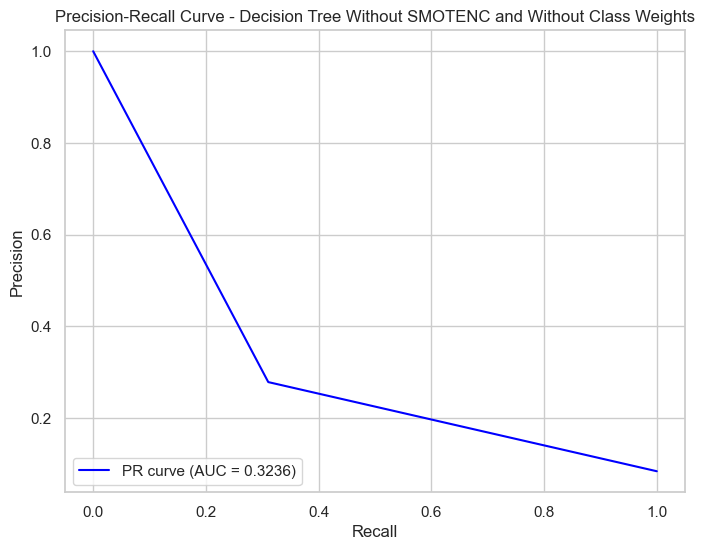

PR AUC Score: 0.3236


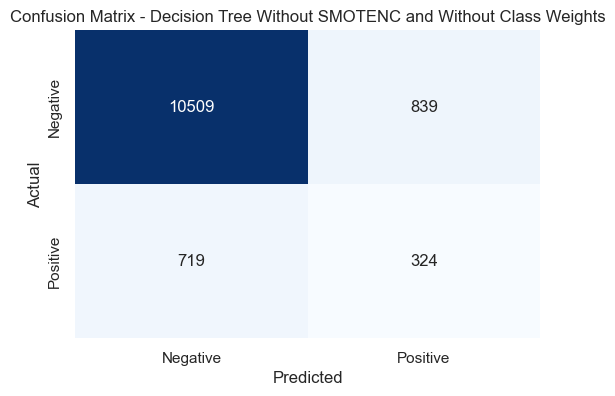

In [797]:
# --- Decision Tree Without SMOTENC and Without Class Weights ---

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the Decision Tree Classifier ---
dt_model1 = DecisionTreeClassifier(
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    dt_model1,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 3. Train the Model on the Full Training Data ---
dt_model1.fit(X_train_ns_ns, y_train_ns_ns)

# --- 4. Predict on the Test Set ---
y_pred_proba_model1 = dt_model1.predict_proba(X_test_ns_ns)[:, 1]
y_pred_model1 = dt_model1.predict(X_test_ns_ns)

# --- 5. Evaluate the Model ---
print("\n=== Decision Tree Without SMOTENC and Without Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_model1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_model1))
roc_auc_model1 = roc_auc_score(y_test_ns_ns, y_pred_proba_model1)
print(f"ROC AUC Score: {roc_auc_model1:.4f}")

# --- 6. Plot ROC Curve ---
fpr_model1, tpr_model1, thresholds_model1 = roc_curve(y_test_ns_ns, y_pred_proba_model1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label=f'ROC curve (AUC = {roc_auc_model1:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Without SMOTENC and Without Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_model1, recall_model1, thresholds_pr_model1 = precision_recall_curve(y_test_ns_ns, y_pred_proba_model1)
pr_auc_model1 = auc(recall_model1, precision_model1)
plt.figure(figsize=(8, 6))
plt.plot(recall_model1, precision_model1, label=f'PR curve (AUC = {pr_auc_model1:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree Without SMOTENC and Without Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model1:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_model1,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Decision Tree Without SMOTENC and Without Class Weights'
)



Threshold for desired recall of 90%: 0.00
Precision: 0.0842, Recall: 1.0000, F1-score: 0.1553

=== Decision Tree Model 1 (Threshold: 0.00) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     11348
           1     0.0842    1.0000    0.1553      1043

    accuracy                         0.0842     12391
   macro avg     0.0421    0.5000    0.0776     12391
weighted avg     0.0071    0.0842    0.0131     12391

Confusion Matrix:
[[    0 11348]
 [    0  1043]]


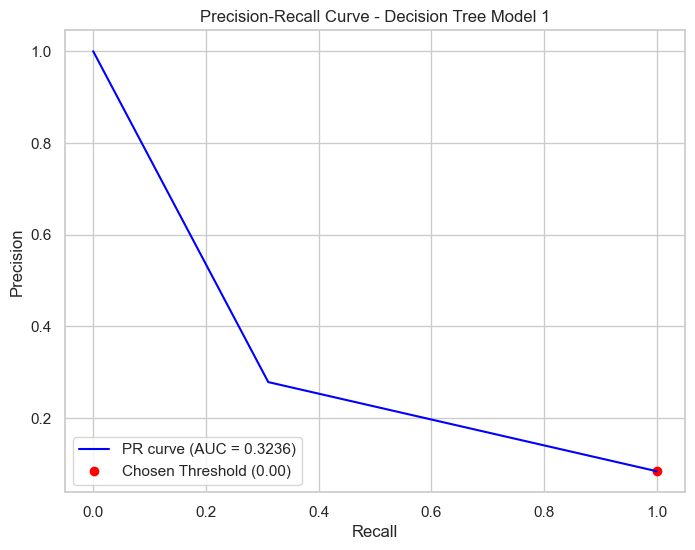

PR AUC Score: 0.3236


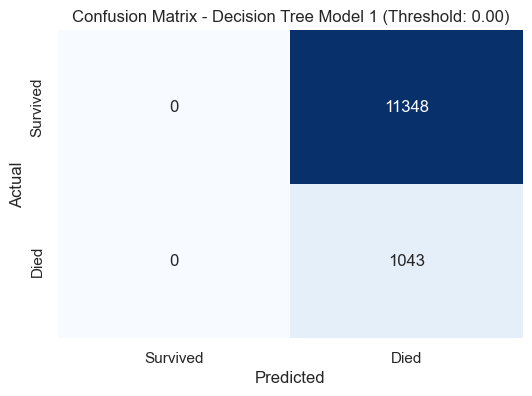

In [798]:
# --- Threshold Adjustment for Decision Tree Model 1 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_dt1, recall_dt1, thresholds_pr_dt1 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_model1, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_dt1(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_dt1 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_dt1 = evaluate_thresholds_dt1(y_test_ns_ns, y_pred_proba_model1, thresholds_to_evaluate_dt1)

# Convert to DataFrame for easy analysis
metrics_df_dt1 = pd.DataFrame(metrics_dt1)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_dt1['recall_diff'] = metrics_df_dt1['recall'] - desired_recall
metrics_df_dt1['recall_diff'] = metrics_df_dt1['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_dt1 = metrics_df_dt1['recall_diff'].idxmin()

if not np.isnan(optimal_index_dt1):
    optimal_threshold_dt1 = metrics_df_dt1.loc[optimal_index_dt1, 'threshold']
    precision_at_desired_recall_dt1 = metrics_df_dt1.loc[optimal_index_dt1, 'precision']
    recall_at_desired_recall_dt1 = metrics_df_dt1.loc[optimal_index_dt1, 'recall']
    f1_at_desired_recall_dt1 = metrics_df_dt1.loc[optimal_index_dt1, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_dt1:.2f}")
    print(f"Precision: {precision_at_desired_recall_dt1:.4f}, Recall: {recall_at_desired_recall_dt1:.4f}, F1-score: {f1_at_desired_recall_dt1:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_dt1 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_dt1 = (y_pred_proba_model1 >= optimal_threshold_dt1).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Decision Tree Model 1 (Threshold: {optimal_threshold_dt1:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_optimal_dt1, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_optimal_dt1))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_dt1, recall_curve_dt1, thresholds_pr_dt1 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_model1, pos_label=1
)
pr_auc_dt1 = auc(recall_curve_dt1, precision_curve_dt1)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_dt1, precision_curve_dt1, label=f'PR curve (AUC = {pr_auc_dt1:.4f})', color='blue')
plt.scatter(recall_at_desired_recall_dt1, precision_at_desired_recall_dt1, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_dt1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree Model 1')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_dt1:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_optimal_dt1,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - Decision Tree Model 1 (Threshold: {optimal_threshold_dt1:.2f})'
)


### SMOTENC (Not Scaled)

Cross-Validated ROC AUC Scores: [0.89321511 0.89106207 0.89001589 0.89772478 0.88979367]
Mean ROC AUC Score: 0.8924

=== Decision Tree With SMOTENC ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9394    0.8844    0.9111     11348
           1     0.2319    0.3797    0.2879      1043

    accuracy                         0.8419     12391
   macro avg     0.5856    0.6320    0.5995     12391
weighted avg     0.8799    0.8419    0.8586     12391

Confusion Matrix:
[[10036  1312]
 [  647   396]]
ROC AUC Score: 0.6320


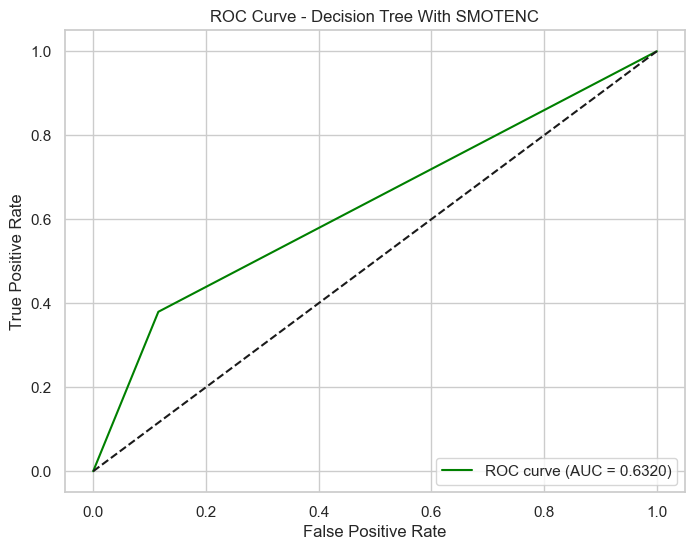

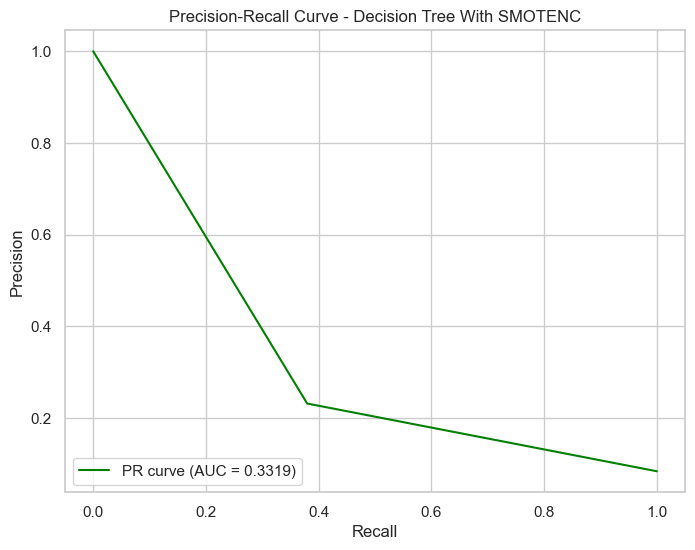

PR AUC Score: 0.3319


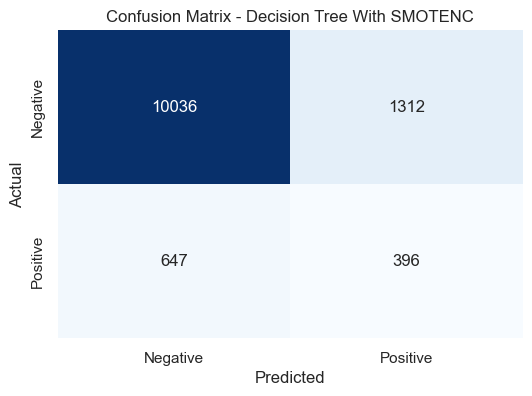

In [799]:
# --- Decision Tree With SMOTENC ---

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the Decision Tree Classifier ---
dt_model2 = DecisionTreeClassifier(
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    dt_model2,
    X_train_ns_s,
    y_train_ns_s,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 3. Train the Model on the Full Training Data ---
dt_model2.fit(X_train_ns_s, y_train_ns_s)

# --- 4. Predict on the Test Set ---
y_pred_proba_model2 = dt_model2.predict_proba(X_test_ns_s)[:, 1]
y_pred_model2 = dt_model2.predict(X_test_ns_s)

# --- 5. Evaluate the Model ---
print("\n=== Decision Tree With SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_model2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_model2))
roc_auc_model2 = roc_auc_score(y_test_ns_s, y_pred_proba_model2)
print(f"ROC AUC Score: {roc_auc_model2:.4f}")

# --- 6. Plot ROC Curve ---
fpr_model2, tpr_model2, thresholds_model2 = roc_curve(y_test_ns_s, y_pred_proba_model2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model2, tpr_model2, label=f'ROC curve (AUC = {roc_auc_model2:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree With SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_model2, recall_model2, thresholds_pr_model2 = precision_recall_curve(y_test_ns_s, y_pred_proba_model2)
pr_auc_model2 = auc(recall_model2, precision_model2)
plt.figure(figsize=(8, 6))
plt.plot(recall_model2, precision_model2, label=f'PR curve (AUC = {pr_auc_model2:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree With SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model2:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_s,
    y_pred_model2,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Decision Tree With SMOTENC'
)



Threshold for desired recall of 90%: 0.00
Precision: 0.0842, Recall: 1.0000, F1-score: 0.1553

=== Decision Tree Model 2 (Threshold: 0.00) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     11348
           1     0.0842    1.0000    0.1553      1043

    accuracy                         0.0842     12391
   macro avg     0.0421    0.5000    0.0776     12391
weighted avg     0.0071    0.0842    0.0131     12391

Confusion Matrix:
[[    0 11348]
 [    0  1043]]


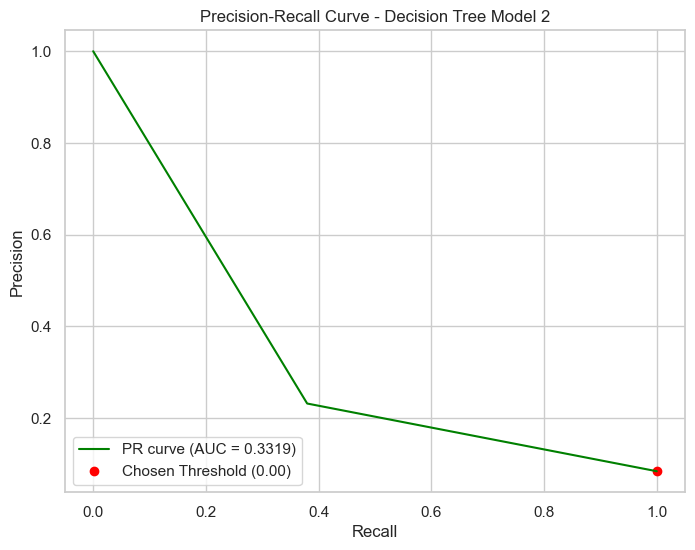

PR AUC Score: 0.3319


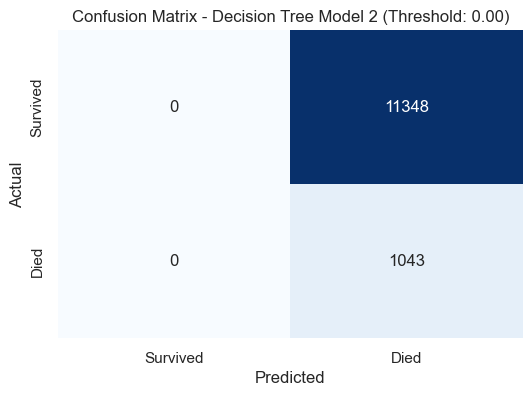

In [800]:
# --- Threshold Adjustment for Decision Tree Model 2 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_dt2, recall_dt2, thresholds_pr_dt2 = precision_recall_curve(
    y_test_ns_s, y_pred_proba_model2, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_dt2(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_dt2 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_dt2 = evaluate_thresholds_dt2(y_test_ns_s, y_pred_proba_model2, thresholds_to_evaluate_dt2)

# Convert to DataFrame for easy analysis
metrics_df_dt2 = pd.DataFrame(metrics_dt2)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_dt2['recall_diff'] = metrics_df_dt2['recall'] - desired_recall
metrics_df_dt2['recall_diff'] = metrics_df_dt2['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_dt2 = metrics_df_dt2['recall_diff'].idxmin()

if not np.isnan(optimal_index_dt2):
    optimal_threshold_dt2 = metrics_df_dt2.loc[optimal_index_dt2, 'threshold']
    precision_at_desired_recall_dt2 = metrics_df_dt2.loc[optimal_index_dt2, 'precision']
    recall_at_desired_recall_dt2 = metrics_df_dt2.loc[optimal_index_dt2, 'recall']
    f1_at_desired_recall_dt2 = metrics_df_dt2.loc[optimal_index_dt2, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_dt2:.2f}")
    print(f"Precision: {precision_at_desired_recall_dt2:.4f}, Recall: {recall_at_desired_recall_dt2:.4f}, F1-score: {f1_at_desired_recall_dt2:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_dt2 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_dt2 = (y_pred_proba_model2 >= optimal_threshold_dt2).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Decision Tree Model 2 (Threshold: {optimal_threshold_dt2:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_optimal_dt2, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_optimal_dt2))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_dt2, recall_curve_dt2, thresholds_pr_dt2 = precision_recall_curve(
    y_test_ns_s, y_pred_proba_model2, pos_label=1
)
pr_auc_dt2 = auc(recall_curve_dt2, precision_curve_dt2)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_dt2, precision_curve_dt2, label=f'PR curve (AUC = {pr_auc_dt2:.4f})', color='green')
plt.scatter(recall_at_desired_recall_dt2, precision_at_desired_recall_dt2, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_dt2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree Model 2')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_dt2:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_s,
    y_pred_optimal_dt2,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - Decision Tree Model 2 (Threshold: {optimal_threshold_dt2:.2f})'
)


### Class weight (not scaled)

Cross-Validated ROC AUC Scores: [0.59882749 0.59943817 0.59170575 0.57930761 0.5907784 ]
Mean ROC AUC Score: 0.5920

=== Decision Tree Without SMOTENC but With Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9315    0.9317    0.9316     11348
           1     0.2555    0.2550    0.2553      1043

    accuracy                         0.8747     12391
   macro avg     0.5935    0.5934    0.5935     12391
weighted avg     0.8746    0.8747    0.8747     12391

Confusion Matrix:
[[10573   775]
 [  777   266]]
ROC AUC Score: 0.5934


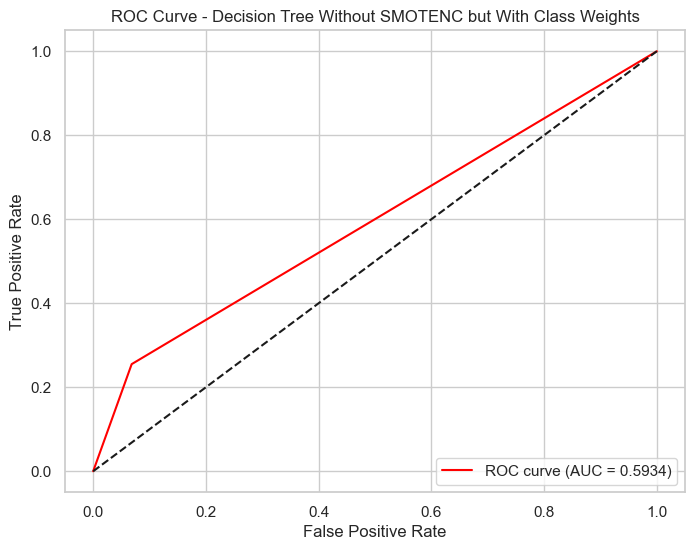

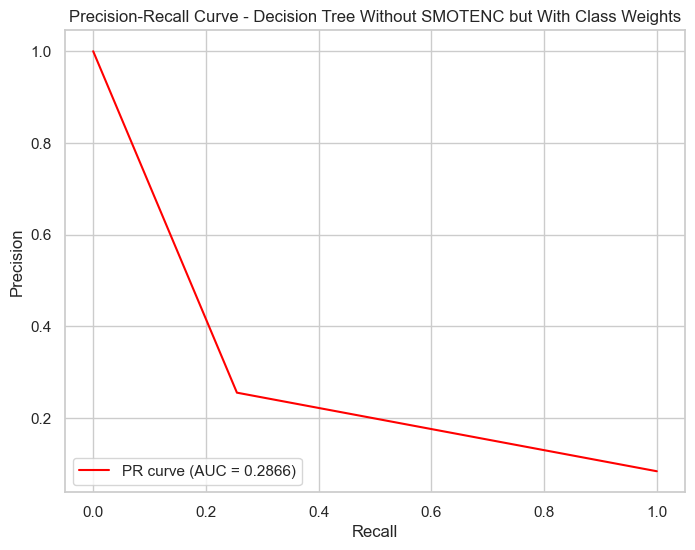

PR AUC Score: 0.2866


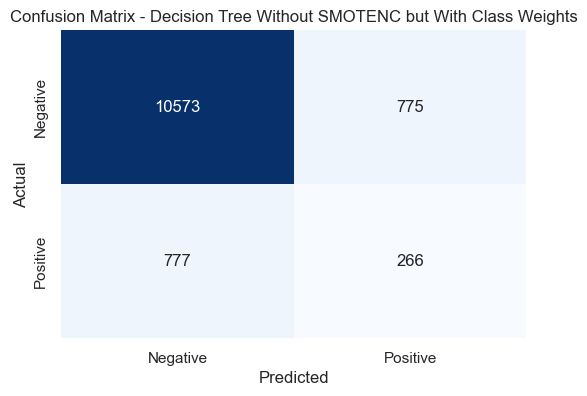

In [801]:
# --- Decision Tree Without SMOTENC but With Class Weights ---

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the Decision Tree Classifier with class_weight='balanced' ---
dt_model3 = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    dt_model3,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 3. Train the Model on the Full Training Data ---
dt_model3.fit(X_train_ns_ns, y_train_ns_ns)

# --- 4. Predict on the Test Set ---
y_pred_proba_model3 = dt_model3.predict_proba(X_test_ns_ns)[:, 1]
y_pred_model3 = dt_model3.predict(X_test_ns_ns)

# --- 5. Evaluate the Model ---
print("\n=== Decision Tree Without SMOTENC but With Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_model3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_model3))
roc_auc_model3 = roc_auc_score(y_test_ns_ns, y_pred_proba_model3)
print(f"ROC AUC Score: {roc_auc_model3:.4f}")

# --- 6. Plot ROC Curve ---
fpr_model3, tpr_model3, thresholds_model3 = roc_curve(y_test_ns_ns, y_pred_proba_model3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_model3, tpr_model3, label=f'ROC curve (AUC = {roc_auc_model3:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree Without SMOTENC but With Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_model3, recall_model3, thresholds_pr_model3 = precision_recall_curve(y_test_ns_ns, y_pred_proba_model3)
pr_auc_model3 = auc(recall_model3, precision_model3)
plt.figure(figsize=(8, 6))
plt.plot(recall_model3, precision_model3, label=f'PR curve (AUC = {pr_auc_model3:.4f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree Without SMOTENC but With Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model3:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_model3,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - Decision Tree Without SMOTENC but With Class Weights'
)



Threshold for desired recall of 90%: 0.00
Precision: 0.0842, Recall: 1.0000, F1-score: 0.1553

=== Decision Tree Model 3 (Threshold: 0.00) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     11348
           1     0.0842    1.0000    0.1553      1043

    accuracy                         0.0842     12391
   macro avg     0.0421    0.5000    0.0776     12391
weighted avg     0.0071    0.0842    0.0131     12391

Confusion Matrix:
[[    0 11348]
 [    0  1043]]


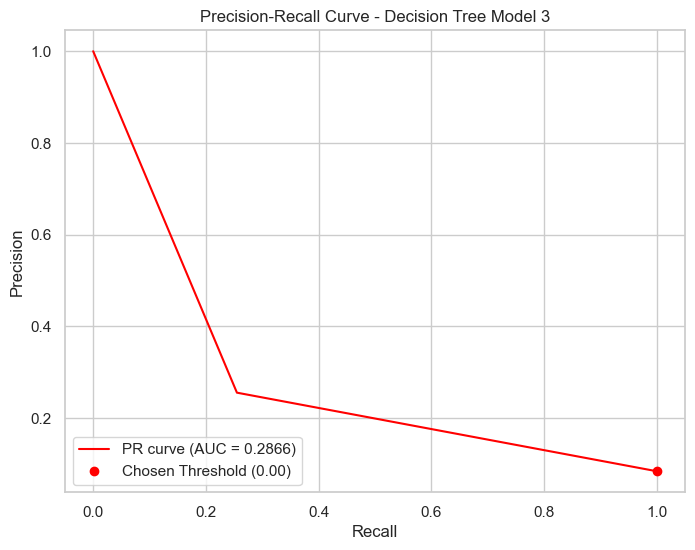

PR AUC Score: 0.2866


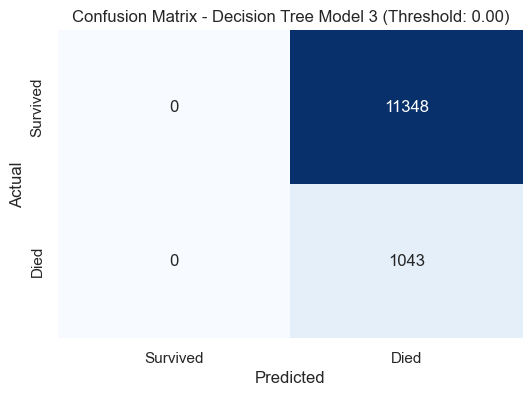

In [802]:
# --- Threshold Adjustment for Decision Tree Model 3 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_dt3, recall_dt3, thresholds_pr_dt3 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_model3, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_dt3(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_dt3 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_dt3 = evaluate_thresholds_dt3(y_test_ns_ns, y_pred_proba_model3, thresholds_to_evaluate_dt3)

# Convert to DataFrame for easy analysis
metrics_df_dt3 = pd.DataFrame(metrics_dt3)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_dt3['recall_diff'] = metrics_df_dt3['recall'] - desired_recall
metrics_df_dt3['recall_diff'] = metrics_df_dt3['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_dt3 = metrics_df_dt3['recall_diff'].idxmin()

if not np.isnan(optimal_index_dt3):
    optimal_threshold_dt3 = metrics_df_dt3.loc[optimal_index_dt3, 'threshold']
    precision_at_desired_recall_dt3 = metrics_df_dt3.loc[optimal_index_dt3, 'precision']
    recall_at_desired_recall_dt3 = metrics_df_dt3.loc[optimal_index_dt3, 'recall']
    f1_at_desired_recall_dt3 = metrics_df_dt3.loc[optimal_index_dt3, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_dt3:.2f}")
    print(f"Precision: {precision_at_desired_recall_dt3:.4f}, Recall: {recall_at_desired_recall_dt3:.4f}, F1-score: {f1_at_desired_recall_dt3:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_dt3 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_dt3 = (y_pred_proba_model3 >= optimal_threshold_dt3).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== Decision Tree Model 3 (Threshold: {optimal_threshold_dt3:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_optimal_dt3, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_optimal_dt3))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_dt3, recall_curve_dt3, thresholds_pr_dt3 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_model3, pos_label=1
)
pr_auc_dt3 = auc(recall_curve_dt3, precision_curve_dt3)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_dt3, precision_curve_dt3, label=f'PR curve (AUC = {pr_auc_dt3:.4f})', color='red')
plt.scatter(recall_at_desired_recall_dt3, precision_at_desired_recall_dt3, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_dt3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Decision Tree Model 3')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_dt3:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_optimal_dt3,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - Decision Tree Model 3 (Threshold: {optimal_threshold_dt3:.2f})'
)


## XGBOOST

### NO SMOTENC

Cross-Validated ROC AUC Scores: [0.85919109 0.867234   0.86595229 0.84733639 0.86705784]
Mean ROC AUC Score: 0.8614

=== XGBoost Without SMOTENC and Without Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9357    0.9817    0.9581     11348
           1     0.5711    0.2656    0.3626      1043

    accuracy                         0.9214     12391
   macro avg     0.7534    0.6236    0.6603     12391
weighted avg     0.9050    0.9214    0.9080     12391

Confusion Matrix:
[[11140   208]
 [  766   277]]
ROC AUC Score: 0.8656


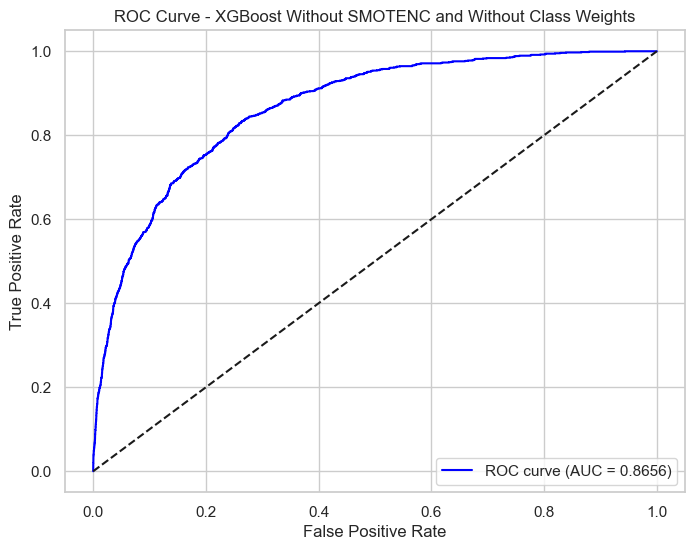

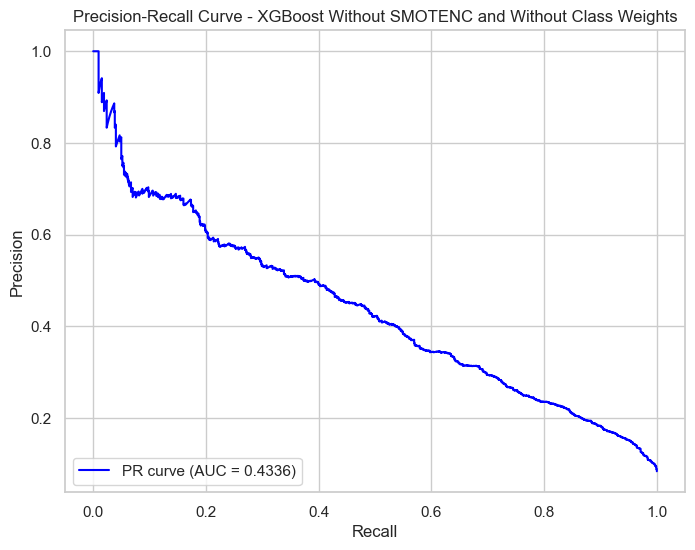

PR AUC Score: 0.4336


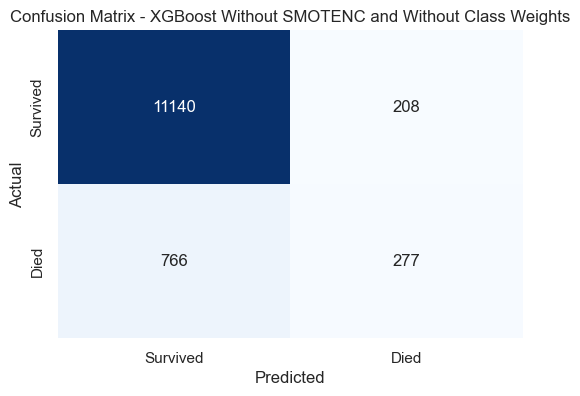

In [803]:
# --- XGBoost Without SMOTENC and Without Class Weights ---

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the XGBoost Classifier ---
xgb_model1 = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv_xgb1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb1 = cross_val_score(
    xgb_model1,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv_xgb1,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores_xgb1}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores_xgb1):.4f}")

# --- 3. Train the Model on the Full Training Data ---
xgb_model1.fit(X_train_ns_ns, y_train_ns_ns)

# --- 4. Predict on the Test Set ---
y_pred_proba_xgb1 = xgb_model1.predict_proba(X_test_ns_ns)[:, 1]
y_pred_xgb1 = xgb_model1.predict(X_test_ns_ns)

# --- 5. Evaluate the Model ---
print("\n=== XGBoost Without SMOTENC and Without Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_xgb1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_xgb1))
roc_auc_xgb1 = roc_auc_score(y_test_ns_ns, y_pred_proba_xgb1)
print(f"ROC AUC Score: {roc_auc_xgb1:.4f}")

# --- 6. Plot ROC Curve ---
fpr_xgb1, tpr_xgb1, thresholds_model1_xgb1 = roc_curve(y_test_ns_ns, y_pred_proba_xgb1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb1, tpr_xgb1, label=f'ROC curve (AUC = {roc_auc_xgb1:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Without SMOTENC and Without Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_xgb1, recall_xgb1, thresholds_pr_xgb1 = precision_recall_curve(y_test_ns_ns, y_pred_proba_xgb1)
pr_auc_xgb1 = auc(recall_xgb1, precision_xgb1)
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb1, precision_xgb1, label=f'PR curve (AUC = {pr_auc_xgb1:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Without SMOTENC and Without Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_xgb1:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_xgb1,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - XGBoost Without SMOTENC and Without Class Weights'
)



Threshold for desired recall of 90%: 0.02
Precision: 0.1711, Recall: 0.9166, F1-score: 0.2883

=== XGBoost Model 1 (Threshold: 0.02) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9872    0.5917    0.7399     11348
           1     0.1711    0.9166    0.2883      1043

    accuracy                         0.6191     12391
   macro avg     0.5791    0.7542    0.5141     12391
weighted avg     0.9185    0.6191    0.7019     12391

Confusion Matrix:
[[6715 4633]
 [  87  956]]


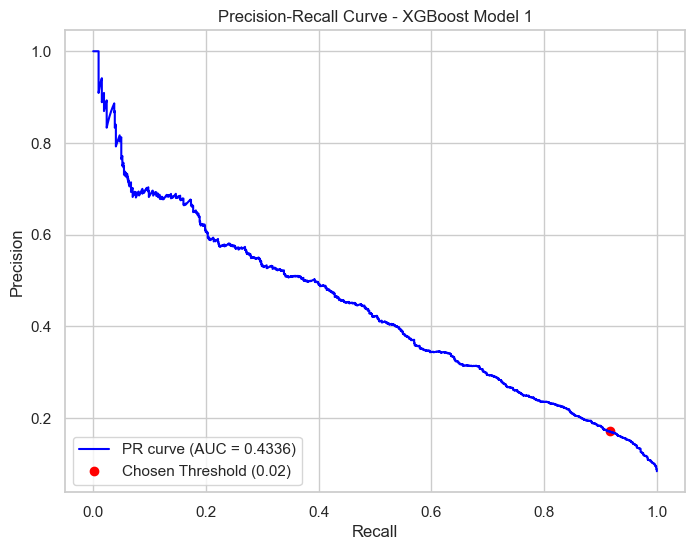

PR AUC Score: 0.4336


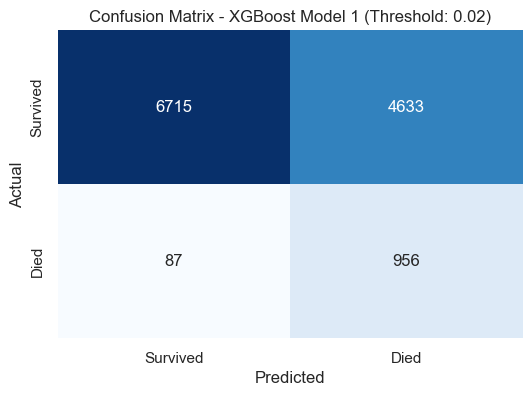

In [804]:
# --- Threshold Adjustment for XGBoost Model 1 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_xgb1, recall_xgb1, thresholds_pr_xgb1 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_xgb1, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_xgb1(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_xgb1 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_xgb1 = evaluate_thresholds_xgb1(y_test_ns_ns, y_pred_proba_xgb1, thresholds_to_evaluate_xgb1)

# Convert to DataFrame for easy analysis
metrics_df_xgb1 = pd.DataFrame(metrics_xgb1)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90
metrics_df_xgb1['recall_diff'] = metrics_df_xgb1['recall'] - desired_recall
metrics_df_xgb1['recall_diff'] = metrics_df_xgb1['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_xgb1 = metrics_df_xgb1['recall_diff'].idxmin()

if not np.isnan(optimal_index_xgb1):
    optimal_threshold_xgb1 = metrics_df_xgb1.loc[optimal_index_xgb1, 'threshold']
    precision_at_desired_recall_xgb1 = metrics_df_xgb1.loc[optimal_index_xgb1, 'precision']
    recall_at_desired_recall_xgb1 = metrics_df_xgb1.loc[optimal_index_xgb1, 'recall']
    f1_at_desired_recall_xgb1 = metrics_df_xgb1.loc[optimal_index_xgb1, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_xgb1:.2f}")
    print(f"Precision: {precision_at_desired_recall_xgb1:.4f}, Recall: {recall_at_desired_recall_xgb1:.4f}, F1-score: {f1_at_desired_recall_xgb1:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_xgb1 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_xgb1 = (y_pred_proba_xgb1 >= optimal_threshold_xgb1).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== XGBoost Model 1 (Threshold: {optimal_threshold_xgb1:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_optimal_xgb1, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_optimal_xgb1))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_xgb1, recall_curve_xgb1, thresholds_pr_xgb1 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_xgb1, pos_label=1
)
pr_auc_xgb1 = auc(recall_curve_xgb1, precision_curve_xgb1)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_xgb1, precision_curve_xgb1, label=f'PR curve (AUC = {pr_auc_xgb1:.4f})', color='blue')
plt.scatter(recall_at_desired_recall_xgb1, precision_at_desired_recall_xgb1, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_xgb1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Model 1')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_xgb1:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_optimal_xgb1,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - XGBoost Model 1 (Threshold: {optimal_threshold_xgb1:.2f})'
)


### SMOTENC

Cross-Validated ROC AUC Scores: [0.98824732 0.98845472 0.98866108 0.98826295 0.98889335]
Mean ROC AUC Score: 0.9885

=== XGBoost With SMOTENC ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9382    0.9760    0.9567     11348
           1     0.5350    0.3001    0.3845      1043

    accuracy                         0.9191     12391
   macro avg     0.7366    0.6381    0.6706     12391
weighted avg     0.9042    0.9191    0.9086     12391

Confusion Matrix:
[[11076   272]
 [  730   313]]
ROC AUC Score: 0.8565


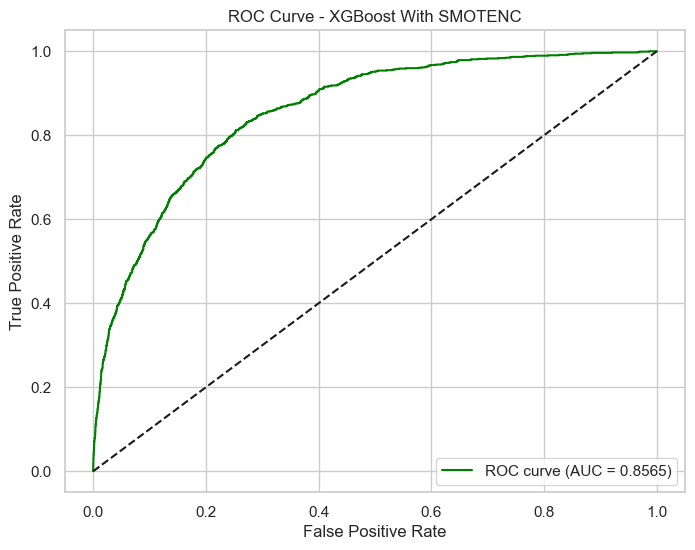

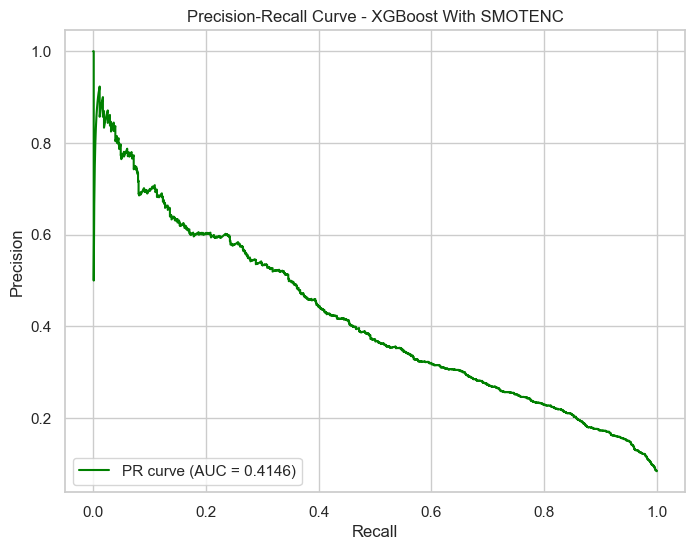

PR AUC Score: 0.4146


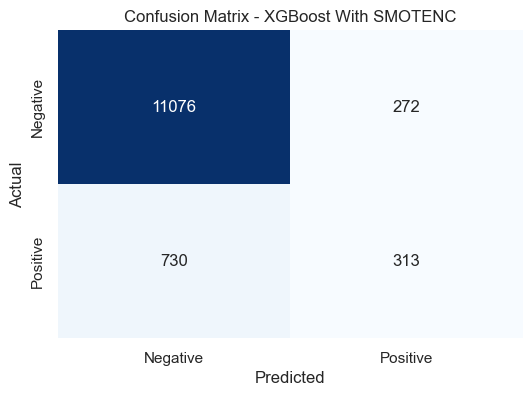

In [805]:
# --- XGBoost With SMOTENC ---

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the XGBoost Classifier ---
xgb_model2 = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv_xgb2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb2 = cross_val_score(
    xgb_model2,
    X_train_ns_s,
    y_train_ns_s,
    cv=cv_xgb2,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores_xgb2}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores_xgb2):.4f}")

# --- 3. Train the Model on the Full Training Data ---
xgb_model2.fit(X_train_ns_s, y_train_ns_s)

# --- 4. Predict on the Test Set ---
y_pred_proba_xgb2 = xgb_model2.predict_proba(X_test_ns_s)[:, 1]
y_pred_xgb2 = xgb_model2.predict(X_test_ns_s)

# --- 5. Evaluate the Model ---
print("\n=== XGBoost With SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_xgb2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_xgb2))
roc_auc_xgb2 = roc_auc_score(y_test_ns_s, y_pred_proba_xgb2)
print(f"ROC AUC Score: {roc_auc_xgb2:.4f}")

# --- 6. Plot ROC Curve ---
fpr_xgb2, tpr_xgb2, thresholds_model2_xgb2 = roc_curve(y_test_ns_s, y_pred_proba_xgb2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb2, tpr_xgb2, label=f'ROC curve (AUC = {roc_auc_xgb2:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost With SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_model2, recall_model2, thresholds_pr_model2 = precision_recall_curve(y_test_ns_s, y_pred_proba_xgb2)
pr_auc_model2 = auc(recall_model2, precision_model2)
plt.figure(figsize=(8, 6))
plt.plot(recall_model2, precision_model2, label=f'PR curve (AUC = {pr_auc_model2:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost With SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_model2:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_s,
    y_pred_xgb2,
    classes=['Negative', 'Positive'],
    title='Confusion Matrix - XGBoost With SMOTENC'
)



Threshold for desired recall of 90%: 0.02
Precision: 0.1546, Recall: 0.9415, F1-score: 0.2657

=== XGBoost Model 2 (Threshold: 0.02) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9899    0.5270    0.6878     11348
           1     0.1546    0.9415    0.2657      1043

    accuracy                         0.5619     12391
   macro avg     0.5723    0.7342    0.4767     12391
weighted avg     0.9196    0.5619    0.6523     12391

Confusion Matrix:
[[5980 5368]
 [  61  982]]


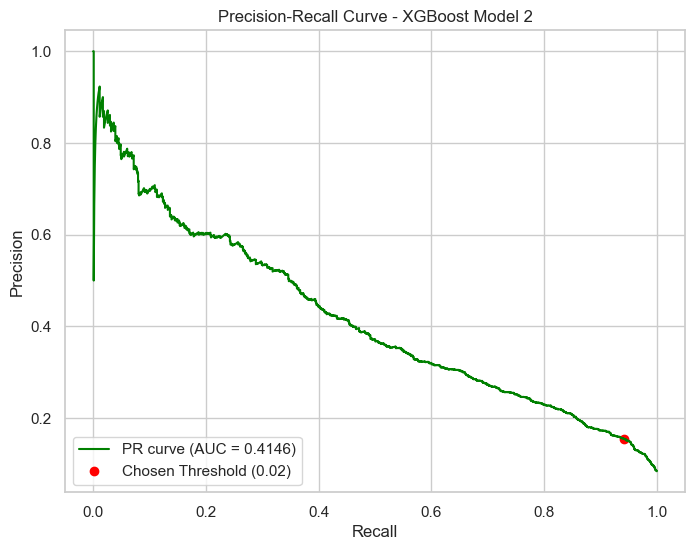

PR AUC Score: 0.4146


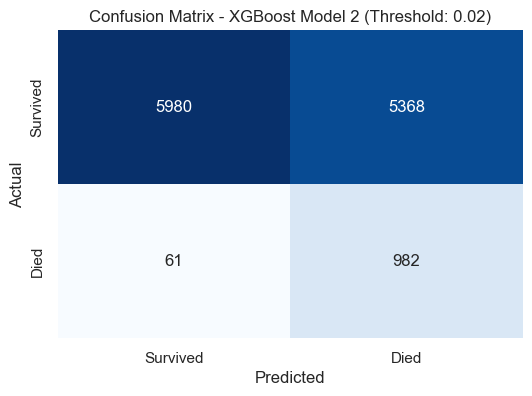

In [806]:
# --- Threshold Adjustment for XGBoost Model 2 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_xgb2, recall_xgb2, thresholds_pr_xgb2 = precision_recall_curve(
    y_test_ns_s, y_pred_proba_xgb2, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_xgb2(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_xgb2 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_xgb2 = evaluate_thresholds_xgb2(y_test_ns_s, y_pred_proba_xgb2, thresholds_to_evaluate_xgb2)

# Convert to DataFrame for easy analysis
metrics_df_xgb2 = pd.DataFrame(metrics_xgb2)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_xgb2['recall_diff'] = metrics_df_xgb2['recall'] - desired_recall
metrics_df_xgb2['recall_diff'] = metrics_df_xgb2['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_xgb2 = metrics_df_xgb2['recall_diff'].idxmin()

if not np.isnan(optimal_index_xgb2):
    optimal_threshold_xgb2 = metrics_df_xgb2.loc[optimal_index_xgb2, 'threshold']
    precision_at_desired_recall_xgb2 = metrics_df_xgb2.loc[optimal_index_xgb2, 'precision']
    recall_at_desired_recall_xgb2 = metrics_df_xgb2.loc[optimal_index_xgb2, 'recall']
    f1_at_desired_recall_xgb2 = metrics_df_xgb2.loc[optimal_index_xgb2, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_xgb2:.2f}")
    print(f"Precision: {precision_at_desired_recall_xgb2:.4f}, Recall: {recall_at_desired_recall_xgb2:.4f}, F1-score: {f1_at_desired_recall_xgb2:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_xgb2 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_xgb2 = (y_pred_proba_xgb2 >= optimal_threshold_xgb2).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== XGBoost Model 2 (Threshold: {optimal_threshold_xgb2:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_optimal_xgb2, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_optimal_xgb2))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_xgb2, recall_curve_xgb2, thresholds_pr_xgb2 = precision_recall_curve(
    y_test_ns_s, y_pred_proba_xgb2, pos_label=1
)
pr_auc_xgb2 = auc(recall_curve_xgb2, precision_curve_xgb2)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_xgb2, precision_curve_xgb2, label=f'PR curve (AUC = {pr_auc_xgb2:.4f})', color='green')
plt.scatter(recall_at_desired_recall_xgb2, precision_at_desired_recall_xgb2, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_xgb2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Model 2')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_xgb2:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_s,
    y_pred_optimal_xgb2,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - XGBoost Model 2 (Threshold: {optimal_threshold_xgb2:.2f})'
)


### NO SMOTENC Class Weights

Scale Pos Weight: 10.88
Cross-Validated ROC AUC Scores: [0.8486731  0.85225121 0.85673094 0.84217685 0.85182125]
Mean ROC AUC Score: 0.8503

=== XGBoost Without SMOTENC but With Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9591    0.8953    0.9261     11348
           1     0.3393    0.5849    0.4294      1043

    accuracy                         0.8692     12391
   macro avg     0.6492    0.7401    0.6778     12391
weighted avg     0.9069    0.8692    0.8843     12391

Confusion Matrix:
[[10160  1188]
 [  433   610]]
ROC AUC Score: 0.8520


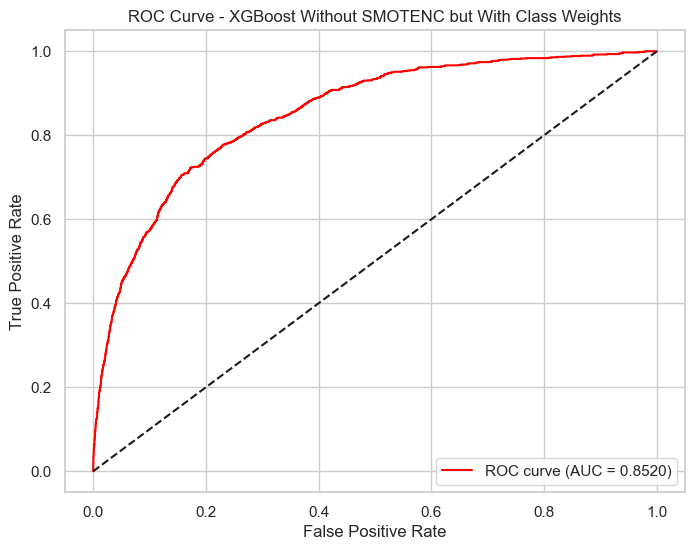

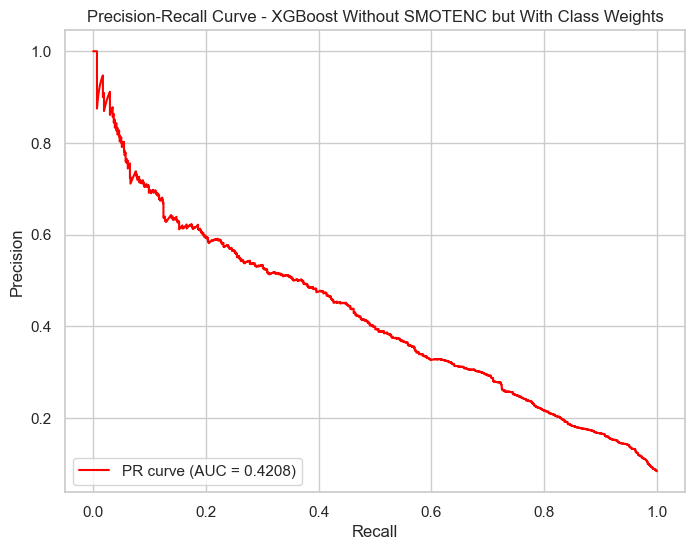

PR AUC Score: 0.4208


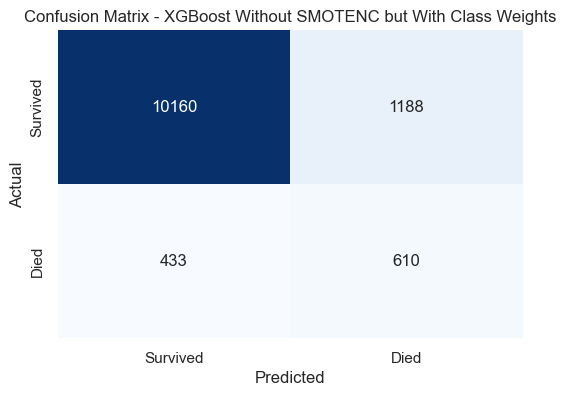

In [807]:
# --- XGBoost Without SMOTENC but With Class Weights ---

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Compute scale_pos_weight ---
# Number of negative class examples divided by number of positive class examples
neg_xgb3, pos_xgb3 = np.bincount(y_train_ns_ns)
scale_pos_weight_xgb3 = neg_xgb3 / pos_xgb3
print(f"Scale Pos Weight: {scale_pos_weight_xgb3:.2f}")

# --- 1. Initialize the XGBoost Classifier with class weights ---
xgb_model3 = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_xgb3,
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv_xgb3 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_xgb3 = cross_val_score(
    xgb_model3,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv_xgb3,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores_xgb3}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores_xgb3):.4f}")

# --- 3. Train the Model on the Full Training Data ---
xgb_model3.fit(X_train_ns_ns, y_train_ns_ns)

# --- 4. Predict on the Test Set ---
y_pred_proba_xgb3 = xgb_model3.predict_proba(X_test_ns_ns)[:, 1]
y_pred_xgb3 = xgb_model3.predict(X_test_ns_ns)

# --- 5. Evaluate the Model ---
print("\n=== XGBoost Without SMOTENC but With Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_xgb3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_xgb3))
roc_auc_xgb3 = roc_auc_score(y_test_ns_ns, y_pred_proba_xgb3)
print(f"ROC AUC Score: {roc_auc_xgb3:.4f}")

# --- 6. Plot ROC Curve ---
fpr_xgb3, tpr_xgb3, thresholds_model3_xgb3 = roc_curve(y_test_ns_ns, y_pred_proba_xgb3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb3, tpr_xgb3, label=f'ROC curve (AUC = {roc_auc_xgb3:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Without SMOTENC but With Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_model3, recall_model3, thresholds_pr_model3 = precision_recall_curve(y_test_ns_ns, y_pred_proba_xgb3)
pr_auc_xgb3 = auc(recall_model3, precision_model3)
plt.figure(figsize=(8, 6))
plt.plot(recall_model3, precision_model3, label=f'PR curve (AUC = {pr_auc_xgb3:.4f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Without SMOTENC but With Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_xgb3:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_xgb3,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - XGBoost Without SMOTENC but With Class Weights'
)



Threshold for desired recall of 90%: 0.09
Precision: 0.1636, Recall: 0.9080, F1-score: 0.2772

=== XGBoost Model 3 (Threshold: 0.09) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9855    0.5733    0.7249     11348
           1     0.1636    0.9080    0.2772      1043

    accuracy                         0.6015     12391
   macro avg     0.5745    0.7406    0.5011     12391
weighted avg     0.9163    0.6015    0.6872     12391

Confusion Matrix:
[[6506 4842]
 [  96  947]]


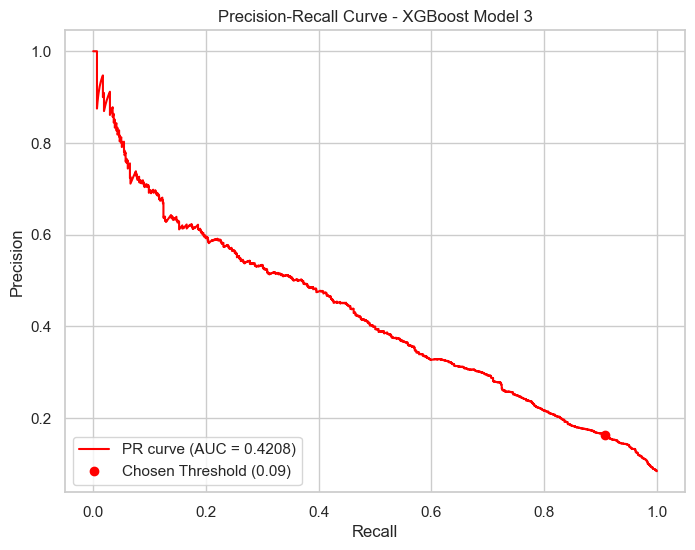

PR AUC Score: 0.4208


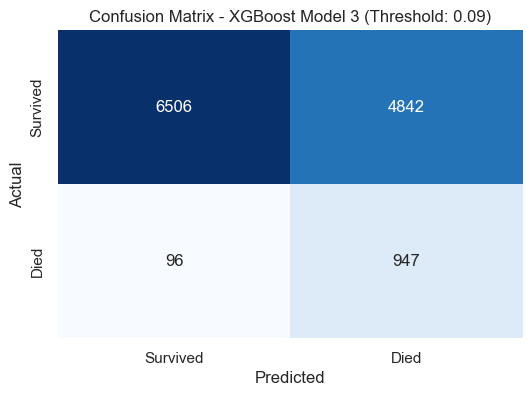

In [808]:
# --- Threshold Adjustment for XGBoost Model 3 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_xgb3, recall_xgb3, thresholds_pr_xgb3 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_xgb3, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_xgb3(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_xgb3 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_xgb3 = evaluate_thresholds_xgb3(y_test_ns_ns, y_pred_proba_xgb3, thresholds_to_evaluate_xgb3)

# Convert to DataFrame for easy analysis
metrics_df_xgb3 = pd.DataFrame(metrics_xgb3)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_xgb3['recall_diff'] = metrics_df_xgb3['recall'] - desired_recall
metrics_df_xgb3['recall_diff'] = metrics_df_xgb3['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_xgb3 = metrics_df_xgb3['recall_diff'].idxmin()

if not np.isnan(optimal_index_xgb3):
    optimal_threshold_xgb3 = metrics_df_xgb3.loc[optimal_index_xgb3, 'threshold']
    precision_at_desired_recall_xgb3 = metrics_df_xgb3.loc[optimal_index_xgb3, 'precision']
    recall_at_desired_recall_xgb3 = metrics_df_xgb3.loc[optimal_index_xgb3, 'recall']
    f1_at_desired_recall_xgb3 = metrics_df_xgb3.loc[optimal_index_xgb3, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_xgb3:.2f}")
    print(f"Precision: {precision_at_desired_recall_xgb3:.4f}, Recall: {recall_at_desired_recall_xgb3:.4f}, F1-score: {f1_at_desired_recall_xgb3:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_xgb3 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_xgb3 = (y_pred_proba_xgb3 >= optimal_threshold_xgb3).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== XGBoost Model 3 (Threshold: {optimal_threshold_xgb3:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_optimal_xgb3, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_optimal_xgb3))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_xgb3, recall_curve_xgb3, thresholds_pr_xgb3 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_xgb3, pos_label=1
)
pr_auc_xgb3 = auc(recall_curve_xgb3, precision_curve_xgb3)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_xgb3, precision_curve_xgb3, label=f'PR curve (AUC = {pr_auc_xgb3:.4f})', color='red')
plt.scatter(recall_at_desired_recall_xgb3, precision_at_desired_recall_xgb3, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_xgb3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost Model 3')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_xgb3:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_optimal_xgb3,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - XGBoost Model 3 (Threshold: {optimal_threshold_xgb3:.2f})'
)


 97%|=================== | 12044/12391 [00:29<00:00]       

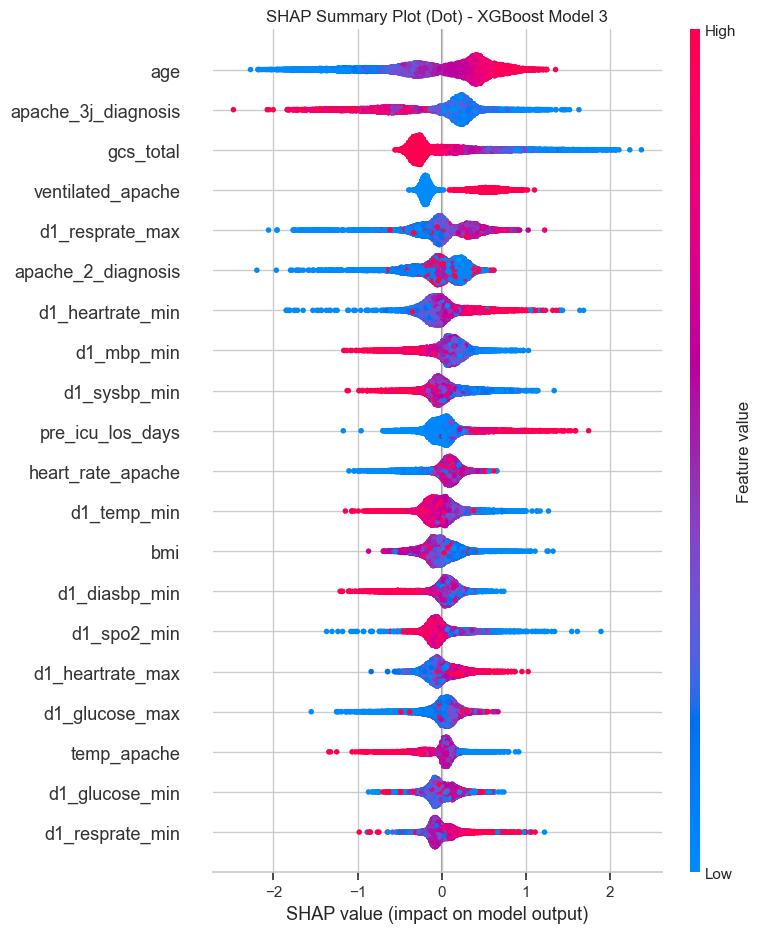

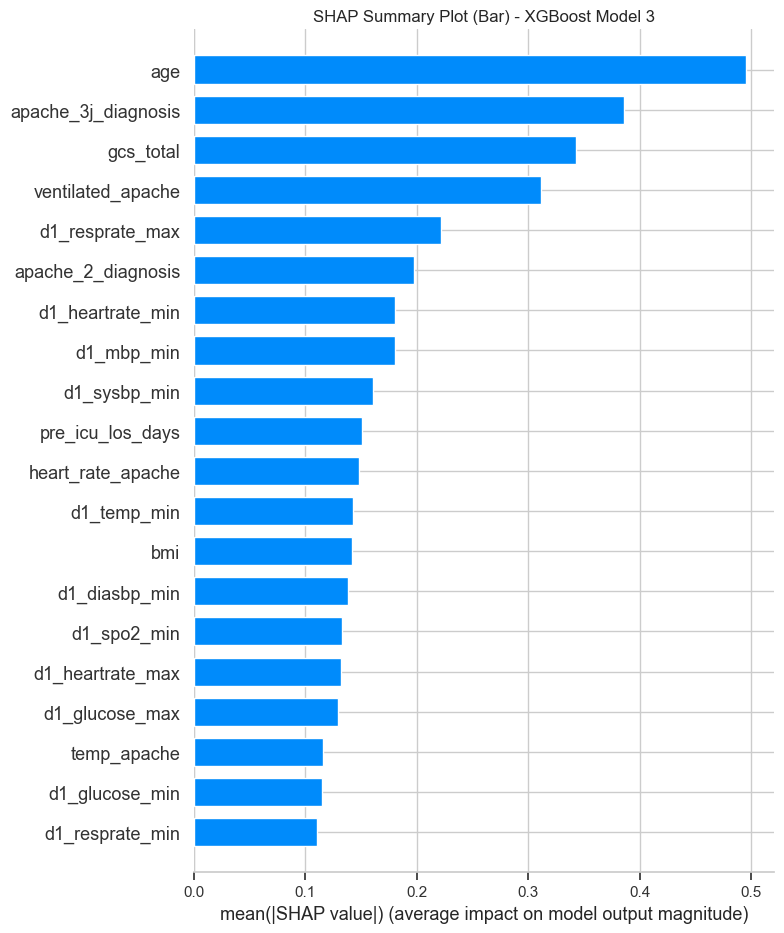

Top 5 features based on SHAP values: ['age', 'apache_3j_diagnosis', 'gcs_total', 'ventilated_apache', 'd1_resprate_max']


<Figure size 800x600 with 0 Axes>

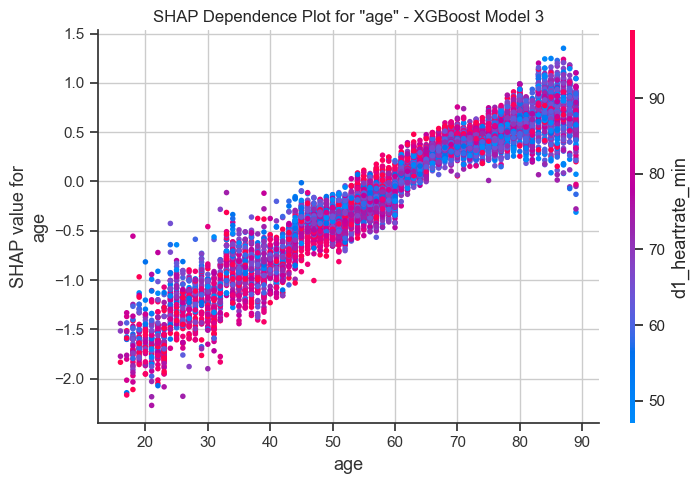

<Figure size 800x600 with 0 Axes>

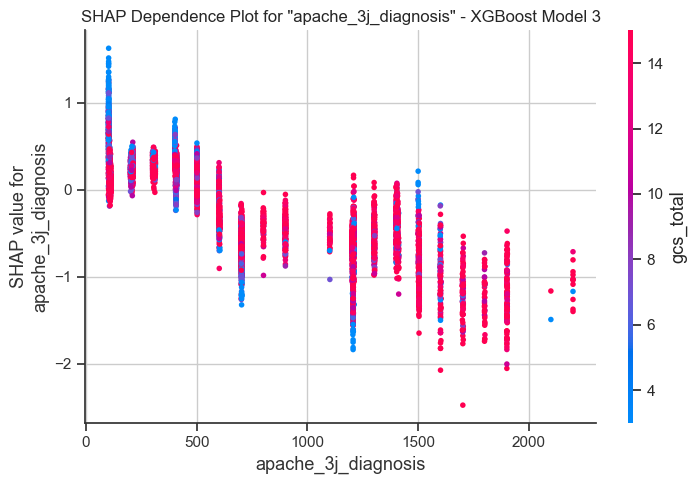

<Figure size 800x600 with 0 Axes>

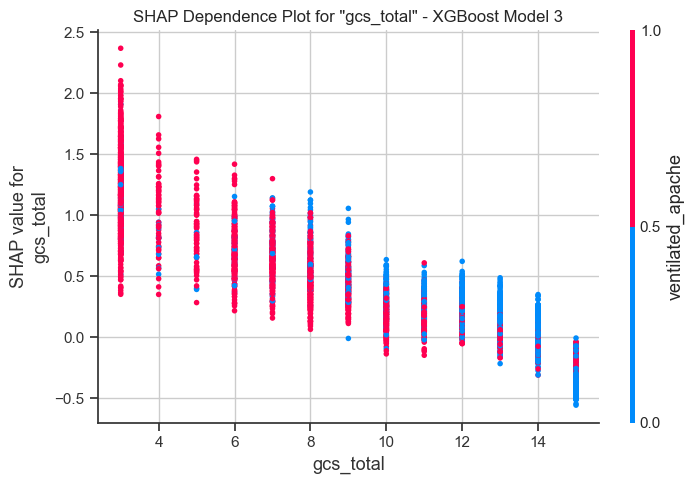

<Figure size 800x600 with 0 Axes>

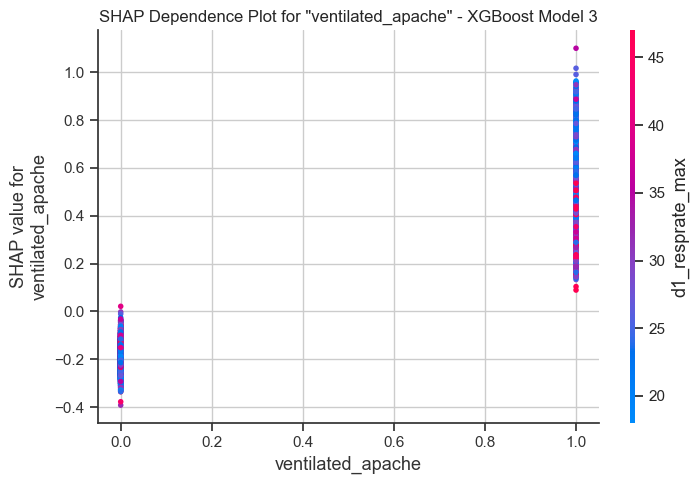

<Figure size 800x600 with 0 Axes>

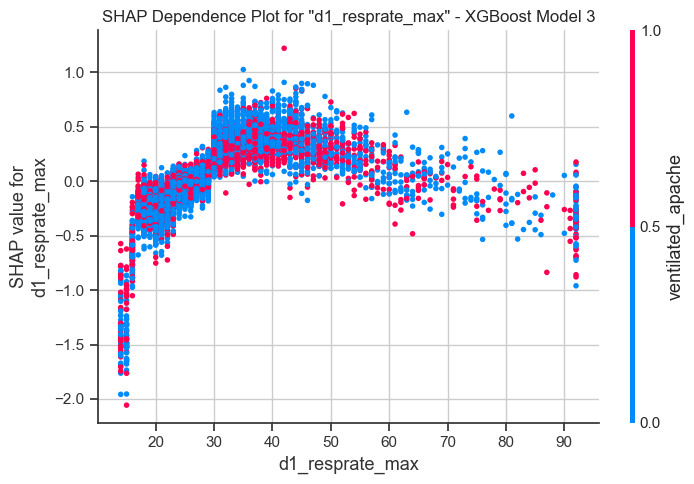

In [809]:
# --- SHAP Analysis for XGBoost Model 3 ---

# 1. Install SHAP (if not already installed)
# Uncomment the following line to install SHAP via pip
# !pip install shap

# 2. Import necessary libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Optional: Initialize JavaScript visualization for SHAP (if using Jupyter Notebook)
# shap.initjs()

# 3. Initialize the SHAP Explainer
# Using TreeExplainer is optimized for tree-based models like XGBoost
explainer = shap.Explainer(xgb_model3, X_train_ns_ns)

# 4. Compute SHAP values for the test set
shap_values = explainer(X_test_ns_ns)

# 5. Plot SHAP Summary Plot (Dot Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_ns_ns, show=False)
plt.title('SHAP Summary Plot (Dot) - XGBoost Model 3')
plt.tight_layout()
plt.show()

# 6. Plot SHAP Summary Plot (Bar Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_ns_ns, plot_type="bar", show=False)
plt.title('SHAP Summary Plot (Bar) - XGBoost Model 3')
plt.tight_layout()
plt.show()

# 7. Identify Top Features based on Mean Absolute SHAP Values
# Calculate mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
feature_names = X_test_ns_ns.columns
shap_importance = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': shap_abs_mean
}).sort_values(by='mean_abs_shap', ascending=False)

# Select top 5 features
top_features = shap_importance['feature'].head(5).tolist()
print(f"Top 5 features based on SHAP values: {top_features}")

# 8. Plot SHAP Dependence Plots for Top Features
for feature in top_features:
    plt.figure(figsize=(8, 6))
    shap.dependence_plot(feature, shap_values.values, X_test_ns_ns, show=False)
    plt.title(f'SHAP Dependence Plot for "{feature}" - XGBoost Model 3')
    plt.tight_layout()
    plt.show()


## CATBOOST

### No SMOTENC

Cross-Validated ROC AUC Scores: [0.86443681 0.87580822 0.87633358 0.86218323 0.87695039]
Mean ROC AUC Score: 0.8711

=== CatBoost Model 1: Without SMOTENC and Without Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9336    0.9866    0.9594     11348
           1     0.6190    0.2368    0.3426      1043

    accuracy                         0.9235     12391
   macro avg     0.7763    0.6117    0.6510     12391
weighted avg     0.9071    0.9235    0.9075     12391

Confusion Matrix:
[[11196   152]
 [  796   247]]
ROC AUC Score: 0.8753


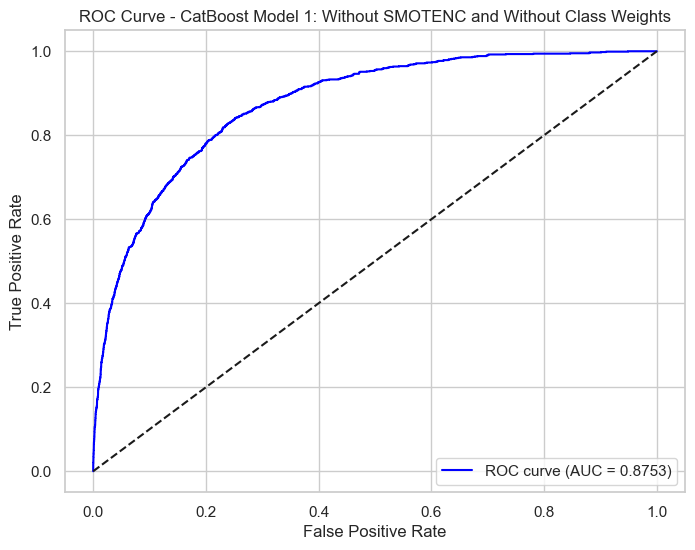

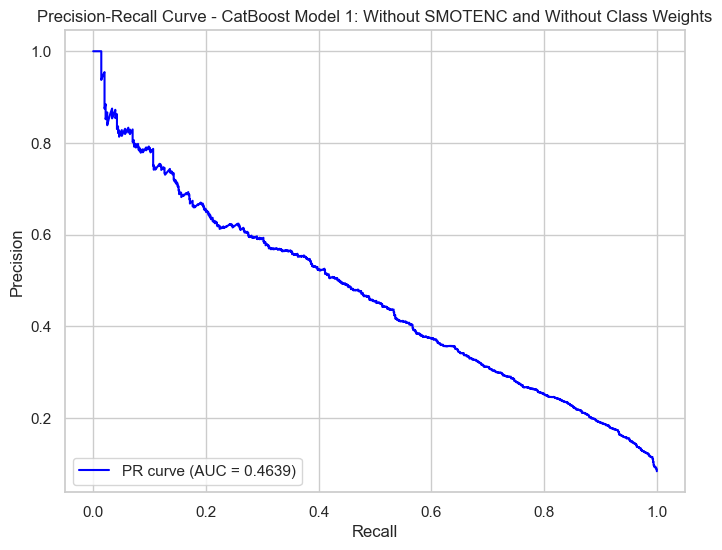

PR AUC Score: 0.4639


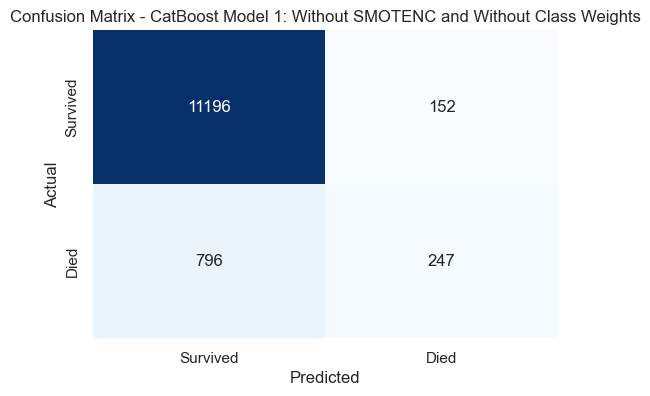

In [810]:
# --- CatBoost Model 1: Without SMOTENC and Without Class Weights ---

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the CatBoost Classifier ---
cat_model1 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    cat_model1,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 3. Train the Model on the Full Training Data ---
cat_model1.fit(X_train_ns_ns, y_train_ns_ns, eval_set=(X_test_ns_ns, y_test_ns_ns), early_stopping_rounds=50, verbose=False)

# --- 4. Predict on the Test Set ---
y_pred_proba_cat1 = cat_model1.predict_proba(X_test_ns_ns)[:, 1]
y_pred_cat1 = cat_model1.predict(X_test_ns_ns)

# --- 5. Evaluate the Model ---
print("\n=== CatBoost Model 1: Without SMOTENC and Without Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_cat1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_cat1))
roc_auc_cat1 = roc_auc_score(y_test_ns_ns, y_pred_proba_cat1)
print(f"ROC AUC Score: {roc_auc_cat1:.4f}")

# --- 6. Plot ROC Curve ---
fpr_cat1, tpr_cat1, thresholds_cat1 = roc_curve(y_test_ns_ns, y_pred_proba_cat1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cat1, tpr_cat1, label=f'ROC curve (AUC = {roc_auc_cat1:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost Model 1: Without SMOTENC and Without Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_cat1, recall_cat1, thresholds_pr_cat1 = precision_recall_curve(y_test_ns_ns, y_pred_proba_cat1)
pr_auc_cat1 = auc(recall_cat1, precision_cat1)
plt.figure(figsize=(8, 6))
plt.plot(recall_cat1, precision_cat1, label=f'PR curve (AUC = {pr_auc_cat1:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost Model 1: Without SMOTENC and Without Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_cat1:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_cat1,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - CatBoost Model 1: Without SMOTENC and Without Class Weights'
)



Threshold for desired recall of 90%: 0.03
Precision: 0.1700, Recall: 0.9329, F1-score: 0.2876

=== CatBoost Model 1 (Threshold: 0.03) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9895    0.5813    0.7324     11348
           1     0.1700    0.9329    0.2876      1043

    accuracy                         0.6109     12391
   macro avg     0.5797    0.7571    0.5100     12391
weighted avg     0.9205    0.6109    0.6949     12391

Confusion Matrix:
[[6597 4751]
 [  70  973]]


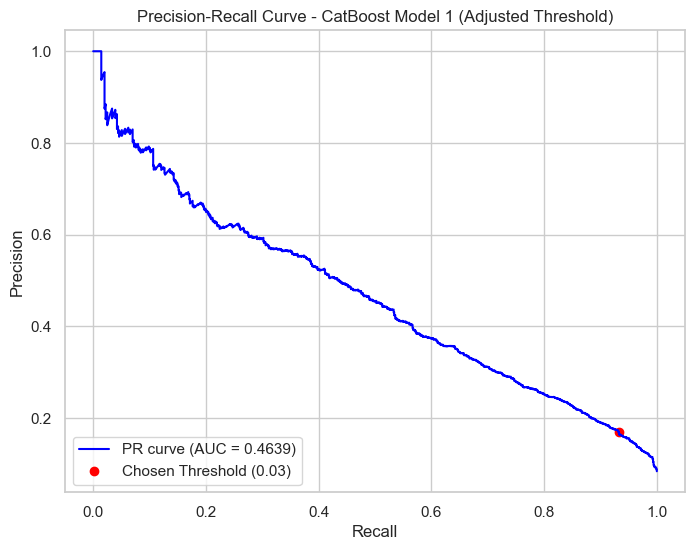

PR AUC Score: 0.4639


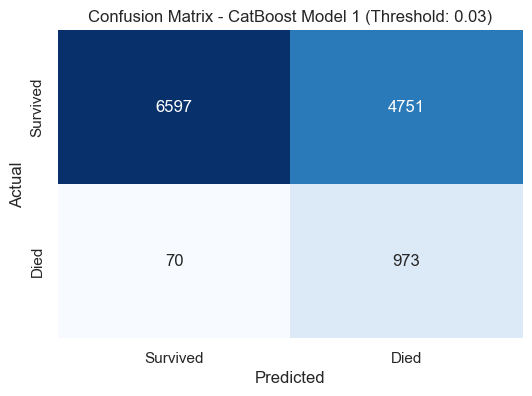

In [811]:
# --- Threshold Adjustment for CatBoost Model 1 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_cat1, recall_cat1, thresholds_pr_cat1 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_cat1, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_cat1(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_cat1 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_cat1 = evaluate_thresholds_cat1(y_test_ns_ns, y_pred_proba_cat1, thresholds_to_evaluate_cat1)

# Convert to DataFrame for easy analysis
metrics_df_cat1 = pd.DataFrame(metrics_cat1)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_cat1['recall_diff'] = metrics_df_cat1['recall'] - desired_recall
metrics_df_cat1['recall_diff'] = metrics_df_cat1['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_cat1 = metrics_df_cat1['recall_diff'].idxmin()

if not np.isnan(optimal_index_cat1):
    optimal_threshold_cat1 = metrics_df_cat1.loc[optimal_index_cat1, 'threshold']
    precision_at_desired_recall_cat1 = metrics_df_cat1.loc[optimal_index_cat1, 'precision']
    recall_at_desired_recall_cat1 = metrics_df_cat1.loc[optimal_index_cat1, 'recall']
    f1_at_desired_recall_cat1 = metrics_df_cat1.loc[optimal_index_cat1, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_cat1:.2f}")
    print(f"Precision: {precision_at_desired_recall_cat1:.4f}, Recall: {recall_at_desired_recall_cat1:.4f}, F1-score: {f1_at_desired_recall_cat1:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_cat1 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_cat1 = (y_pred_proba_cat1 >= optimal_threshold_cat1).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== CatBoost Model 1 (Threshold: {optimal_threshold_cat1:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_optimal_cat1, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_optimal_cat1))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_cat1, recall_curve_cat1, thresholds_pr_cat1 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_cat1, pos_label=1
)
pr_auc_cat1 = auc(recall_curve_cat1, precision_curve_cat1)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_cat1, precision_curve_cat1, label=f'PR curve (AUC = {pr_auc_cat1:.4f})', color='blue')
plt.scatter(recall_at_desired_recall_cat1, precision_at_desired_recall_cat1, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_cat1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost Model 1 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_cat1:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_optimal_cat1,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - CatBoost Model 1 (Threshold: {optimal_threshold_cat1:.2f})'
)


## SMOTENC

Cross-Validated ROC AUC Scores: [0.98858166 0.98868742 0.98895301 0.98810454 0.98962279]
Mean ROC AUC Score: 0.9888

=== CatBoost Model 2: With SMOTENC ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9383    0.9815    0.9594     11348
           1     0.5962    0.2972    0.3967      1043

    accuracy                         0.9239     12391
   macro avg     0.7672    0.6394    0.6780     12391
weighted avg     0.9095    0.9239    0.9120     12391

Confusion Matrix:
[[11138   210]
 [  733   310]]
ROC AUC Score: 0.8706


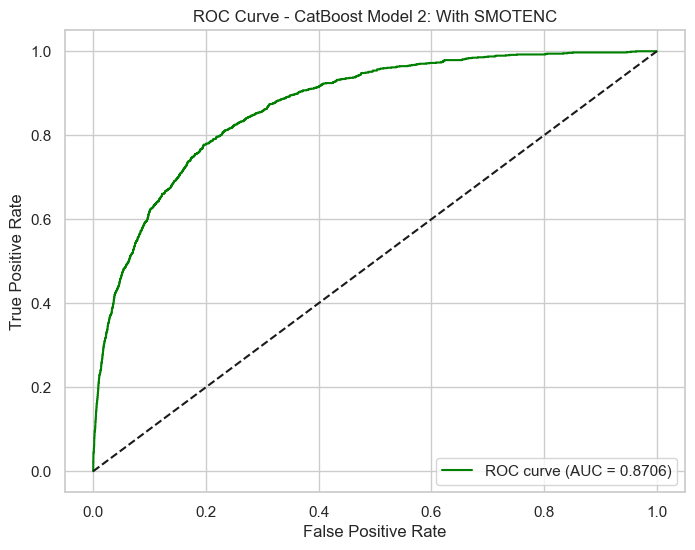

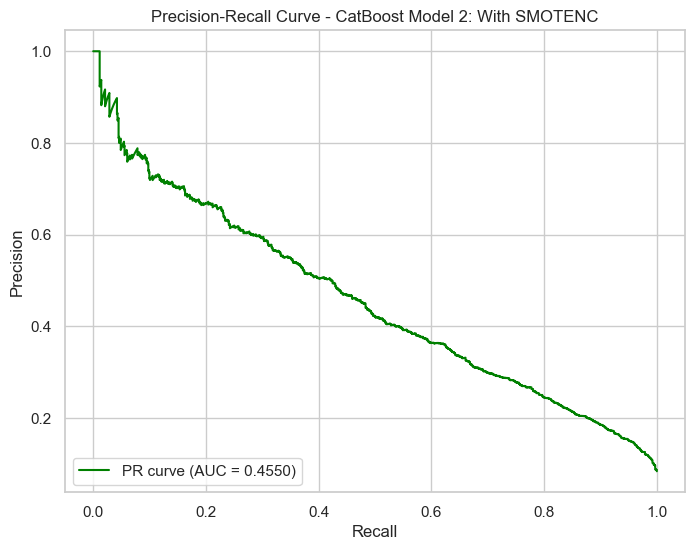

PR AUC Score: 0.4550


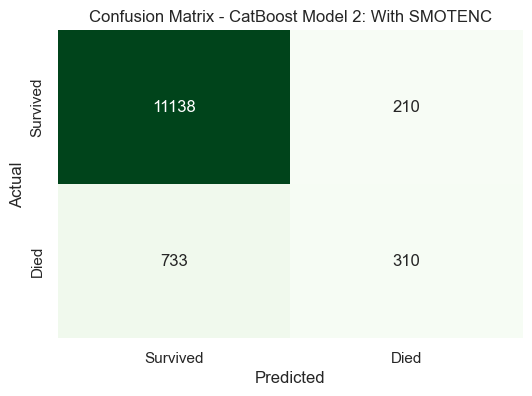

In [812]:
# --- CatBoost Model 2: With SMOTENC ---

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Initialize the CatBoost Classifier ---
cat_model2 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

# --- 2. Perform Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    cat_model2,
    X_train_ns_s,
    y_train_ns_s,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 3. Train the Model on the Full Training Data ---
cat_model2.fit(X_train_ns_s, y_train_ns_s, eval_set=(X_test_ns_s, y_test_ns_s), early_stopping_rounds=50, verbose=False)

# --- 4. Predict on the Test Set ---
y_pred_proba_cat2 = cat_model2.predict_proba(X_test_ns_s)[:, 1]
y_pred_cat2 = cat_model2.predict(X_test_ns_s)

# --- 5. Evaluate the Model ---
print("\n=== CatBoost Model 2: With SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_cat2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_cat2))
roc_auc_cat2 = roc_auc_score(y_test_ns_s, y_pred_proba_cat2)
print(f"ROC AUC Score: {roc_auc_cat2:.4f}")

# --- 6. Plot ROC Curve ---
fpr_cat2, tpr_cat2, thresholds_cat2 = roc_curve(y_test_ns_s, y_pred_proba_cat2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cat2, tpr_cat2, label=f'ROC curve (AUC = {roc_auc_cat2:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost Model 2: With SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 7. Plot Precision-Recall Curve ---
precision_cat2, recall_cat2, thresholds_pr_cat2 = precision_recall_curve(y_test_ns_s, y_pred_proba_cat2)
pr_auc_cat2 = auc(recall_cat2, precision_cat2)
plt.figure(figsize=(8, 6))
plt.plot(recall_cat2, precision_cat2, label=f'PR curve (AUC = {pr_auc_cat2:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost Model 2: With SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_cat2:.4f}")

# --- 8. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_s,
    y_pred_cat2,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - CatBoost Model 2: With SMOTENC'
)



Threshold for desired recall of 90%: 0.04
Precision: 0.1745, Recall: 0.9137, F1-score: 0.2931

=== CatBoost Model 2 (Threshold: 0.04) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9870    0.6027    0.7484     11348
           1     0.1745    0.9137    0.2931      1043

    accuracy                         0.6289     12391
   macro avg     0.5808    0.7582    0.5207     12391
weighted avg     0.9186    0.6289    0.7101     12391

Confusion Matrix:
[[6840 4508]
 [  90  953]]


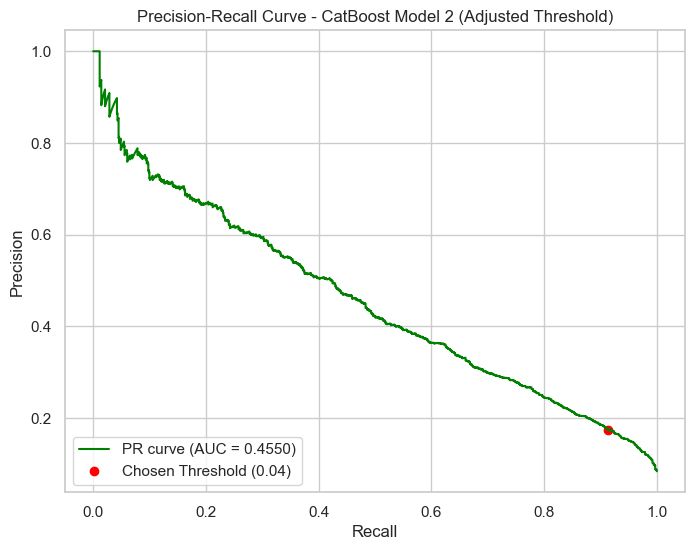

PR AUC Score: 0.4550


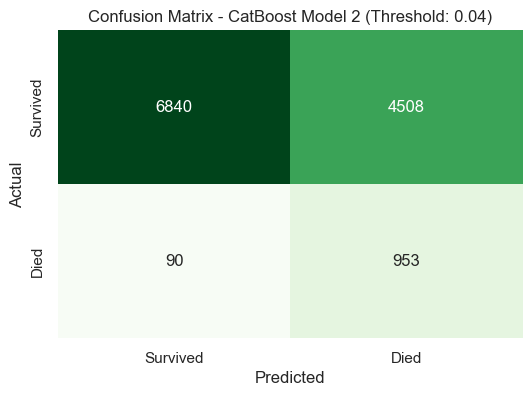

In [813]:
# --- Threshold Adjustment for CatBoost Model 2 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_cat2, recall_cat2, thresholds_pr_cat2 = precision_recall_curve(
    y_test_ns_s, y_pred_proba_cat2, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_cat2(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_cat2 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_cat2 = evaluate_thresholds_cat2(y_test_ns_s, y_pred_proba_cat2, thresholds_to_evaluate_cat2)

# Convert to DataFrame for easy analysis
metrics_df_cat2 = pd.DataFrame(metrics_cat2)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_cat2['recall_diff'] = metrics_df_cat2['recall'] - desired_recall
metrics_df_cat2['recall_diff'] = metrics_df_cat2['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_cat2 = metrics_df_cat2['recall_diff'].idxmin()

if not np.isnan(optimal_index_cat2):
    optimal_threshold_cat2 = metrics_df_cat2.loc[optimal_index_cat2, 'threshold']
    precision_at_desired_recall_cat2 = metrics_df_cat2.loc[optimal_index_cat2, 'precision']
    recall_at_desired_recall_cat2 = metrics_df_cat2.loc[optimal_index_cat2, 'recall']
    f1_at_desired_recall_cat2 = metrics_df_cat2.loc[optimal_index_cat2, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_cat2:.2f}")
    print(f"Precision: {precision_at_desired_recall_cat2:.4f}, Recall: {recall_at_desired_recall_cat2:.4f}, F1-score: {f1_at_desired_recall_cat2:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_cat2 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_cat2 = (y_pred_proba_cat2 >= optimal_threshold_cat2).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== CatBoost Model 2 (Threshold: {optimal_threshold_cat2:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_s, y_pred_optimal_cat2, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_s, y_pred_optimal_cat2))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_cat2, recall_curve_cat2, thresholds_pr_cat2 = precision_recall_curve(
    y_test_ns_s, y_pred_proba_cat2, pos_label=1
)
pr_auc_cat2 = auc(recall_curve_cat2, precision_curve_cat2)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_cat2, precision_curve_cat2, label=f'PR curve (AUC = {pr_auc_cat2:.4f})', color='green')
plt.scatter(recall_at_desired_recall_cat2, precision_at_desired_recall_cat2, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_cat2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost Model 2 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_cat2:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_s,
    y_pred_optimal_cat2,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - CatBoost Model 2 (Threshold: {optimal_threshold_cat2:.2f})'
)


### Class Weights

Scale Pos Weight: 10.88
Cross-Validated ROC AUC Scores: [0.85139739 0.86061465 0.8691709  0.85245002 0.8645397 ]
Mean ROC AUC Score: 0.8596

=== CatBoost Model 3: Without SMOTENC but With Class Weights ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9734    0.8173    0.8886     11348
           1     0.2759    0.7574    0.4045      1043

    accuracy                         0.8123     12391
   macro avg     0.6247    0.7874    0.6465     12391
weighted avg     0.9147    0.8123    0.8478     12391

Confusion Matrix:
[[9275 2073]
 [ 253  790]]
ROC AUC Score: 0.8751


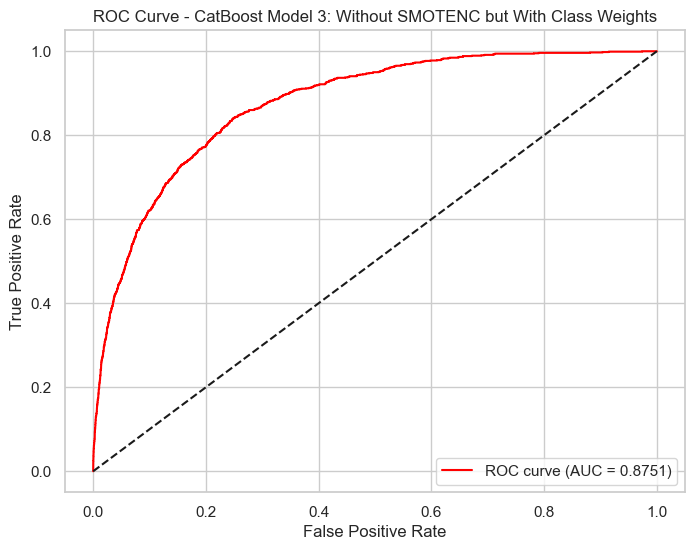

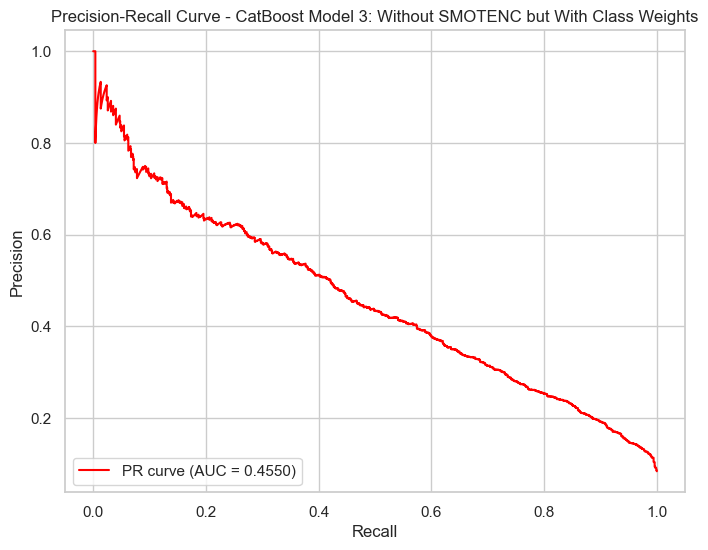

PR AUC Score: 0.4550


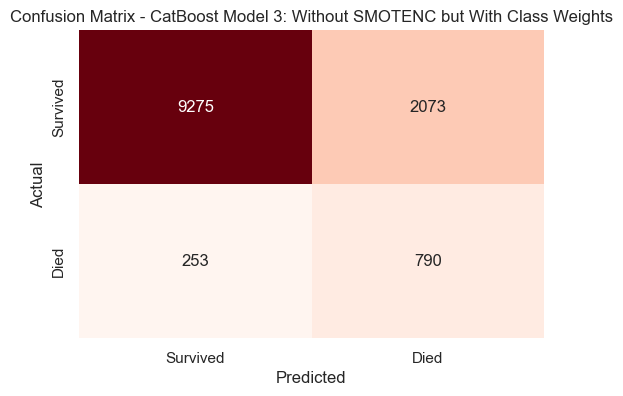

In [814]:
# --- CatBoost Model 3: Without SMOTENC but With Class Weights ---

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- 1. Compute scale_pos_weight ---
# Number of negative class examples divided by number of positive class examples
neg_cat3, pos_cat3 = np.bincount(y_train_ns_ns)
scale_pos_weight_cat3 = neg_cat3 / pos_cat3
print(f"Scale Pos Weight: {scale_pos_weight_cat3:.2f}")

# --- 2. Initialize the CatBoost Classifier with class weights ---
cat_model3 = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    class_weights=[1, scale_pos_weight_cat3],  # [weight for class 0, weight for class 1]
    eval_metric='AUC',
    verbose=0,
    random_state=42
)

# --- 3. Perform Stratified K-Fold Cross-Validation ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    cat_model3,
    X_train_ns_ns,
    y_train_ns_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {np.mean(cv_scores):.4f}")

# --- 4. Train the Model on the Full Training Data ---
cat_model3.fit(X_train_ns_ns, y_train_ns_ns, eval_set=(X_test_ns_ns, y_test_ns_ns), early_stopping_rounds=50, verbose=False)

# --- 5. Predict on the Test Set ---
y_pred_proba_cat3 = cat_model3.predict_proba(X_test_ns_ns)[:, 1]
y_pred_cat3 = cat_model3.predict(X_test_ns_ns)

# --- 6. Evaluate the Model ---
print("\n=== CatBoost Model 3: Without SMOTENC but With Class Weights ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_cat3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_cat3))
roc_auc_cat3 = roc_auc_score(y_test_ns_ns, y_pred_proba_cat3)
print(f"ROC AUC Score: {roc_auc_cat3:.4f}")

# --- 7. Plot ROC Curve ---
fpr_cat3, tpr_cat3, thresholds_cat3 = roc_curve(y_test_ns_ns, y_pred_proba_cat3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_cat3, tpr_cat3, label=f'ROC curve (AUC = {roc_auc_cat3:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - CatBoost Model 3: Without SMOTENC but With Class Weights')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- 8. Plot Precision-Recall Curve ---
precision_cat3, recall_cat3, thresholds_pr_cat3 = precision_recall_curve(y_test_ns_ns, y_pred_proba_cat3)
pr_auc_cat3 = auc(recall_cat3, precision_cat3)
plt.figure(figsize=(8, 6))
plt.plot(recall_cat3, precision_cat3, label=f'PR curve (AUC = {pr_auc_cat3:.4f})', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost Model 3: Without SMOTENC but With Class Weights')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_cat3:.4f}")

# --- 9. Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_cat3,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - CatBoost Model 3: Without SMOTENC but With Class Weights'
)



Threshold for desired recall of 90%: 0.29
Precision: 0.1909, Recall: 0.9032, F1-score: 0.3152

=== CatBoost Model 3 (Threshold: 0.29) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9865    0.6482    0.7823     11348
           1     0.1909    0.9032    0.3152      1043

    accuracy                         0.6697     12391
   macro avg     0.5887    0.7757    0.5488     12391
weighted avg     0.9195    0.6697    0.7430     12391

Confusion Matrix:
[[7356 3992]
 [ 101  942]]


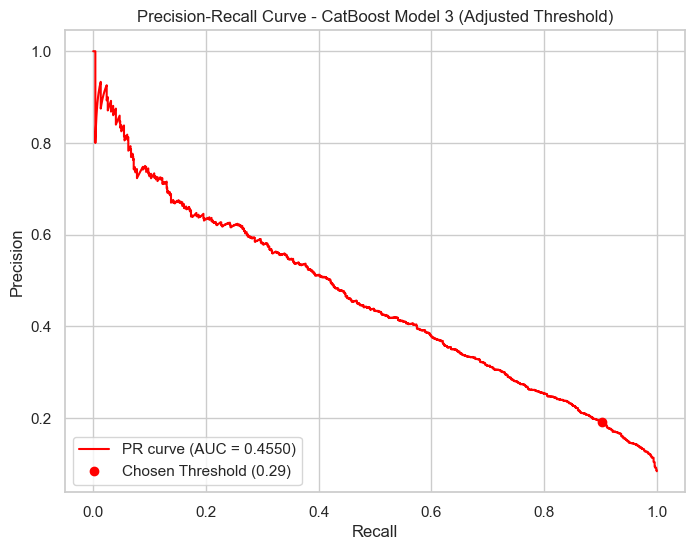

PR AUC Score: 0.4550


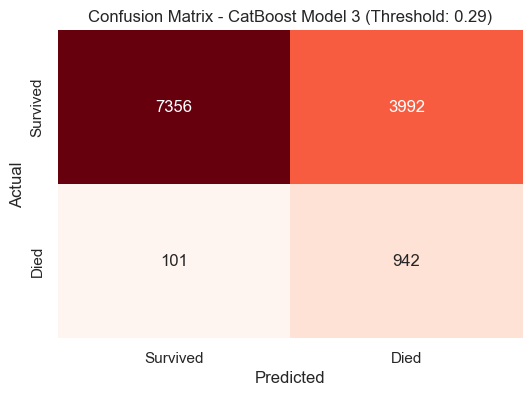

In [815]:
# --- Threshold Adjustment for CatBoost Model 3 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Compute Precision-Recall Curve ---
precision_cat3, recall_cat3, thresholds_pr_cat3 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_cat3, pos_label=1
)

# --- 2. Evaluate Metrics at Various Thresholds ---
def evaluate_thresholds_cat3(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define thresholds to evaluate
thresholds_to_evaluate_cat3 = np.linspace(0, 1, 101)

# Evaluate metrics at each threshold
metrics_cat3 = evaluate_thresholds_cat3(y_test_ns_ns, y_pred_proba_cat3, thresholds_to_evaluate_cat3)

# Convert to DataFrame for easy analysis
metrics_df_cat3 = pd.DataFrame(metrics_cat3)

# --- 3. Choose Threshold Corresponding to Desired Recall ---
desired_recall = 0.90  # Adjust as needed
metrics_df_cat3['recall_diff'] = metrics_df_cat3['recall'] - desired_recall
metrics_df_cat3['recall_diff'] = metrics_df_cat3['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index_cat3 = metrics_df_cat3['recall_diff'].idxmin()

if not np.isnan(optimal_index_cat3):
    optimal_threshold_cat3 = metrics_df_cat3.loc[optimal_index_cat3, 'threshold']
    precision_at_desired_recall_cat3 = metrics_df_cat3.loc[optimal_index_cat3, 'precision']
    recall_at_desired_recall_cat3 = metrics_df_cat3.loc[optimal_index_cat3, 'recall']
    f1_at_desired_recall_cat3 = metrics_df_cat3.loc[optimal_index_cat3, 'f1_score']
    print(f"\nThreshold for desired recall of {desired_recall*100:.0f}%: {optimal_threshold_cat3:.2f}")
    print(f"Precision: {precision_at_desired_recall_cat3:.4f}, Recall: {recall_at_desired_recall_cat3:.4f}, F1-score: {f1_at_desired_recall_cat3:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold_cat3 = 0.5  # Default threshold

# --- 4. Predict with the Desired Threshold ---
y_pred_optimal_cat3 = (y_pred_proba_cat3 >= optimal_threshold_cat3).astype(int)

# --- 5. Evaluate the Model with the Desired Threshold ---
print(f"\n=== CatBoost Model 3 (Threshold: {optimal_threshold_cat3:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_ns_ns, y_pred_optimal_cat3, digits=4, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_test_ns_ns, y_pred_optimal_cat3))

# --- 6. Plot Precision-Recall Curve with Chosen Threshold ---
precision_curve_cat3, recall_curve_cat3, thresholds_pr_cat3 = precision_recall_curve(
    y_test_ns_ns, y_pred_proba_cat3, pos_label=1
)
pr_auc_cat3 = auc(recall_curve_cat3, precision_curve_cat3)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve_cat3, precision_curve_cat3, label=f'PR curve (AUC = {pr_auc_cat3:.4f})', color='red')
plt.scatter(recall_at_desired_recall_cat3, precision_at_desired_recall_cat3, color='red', 
            label=f'Chosen Threshold ({optimal_threshold_cat3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - CatBoost Model 3 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_cat3:.4f}")

# --- 7. Plot Confusion Matrix ---
plot_confusion_matrix(
    y_test_ns_ns,
    y_pred_optimal_cat3,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - CatBoost Model 3 (Threshold: {optimal_threshold_cat3:.2f})'
)


 99%|===================| 12215/12391 [00:59<00:00]        

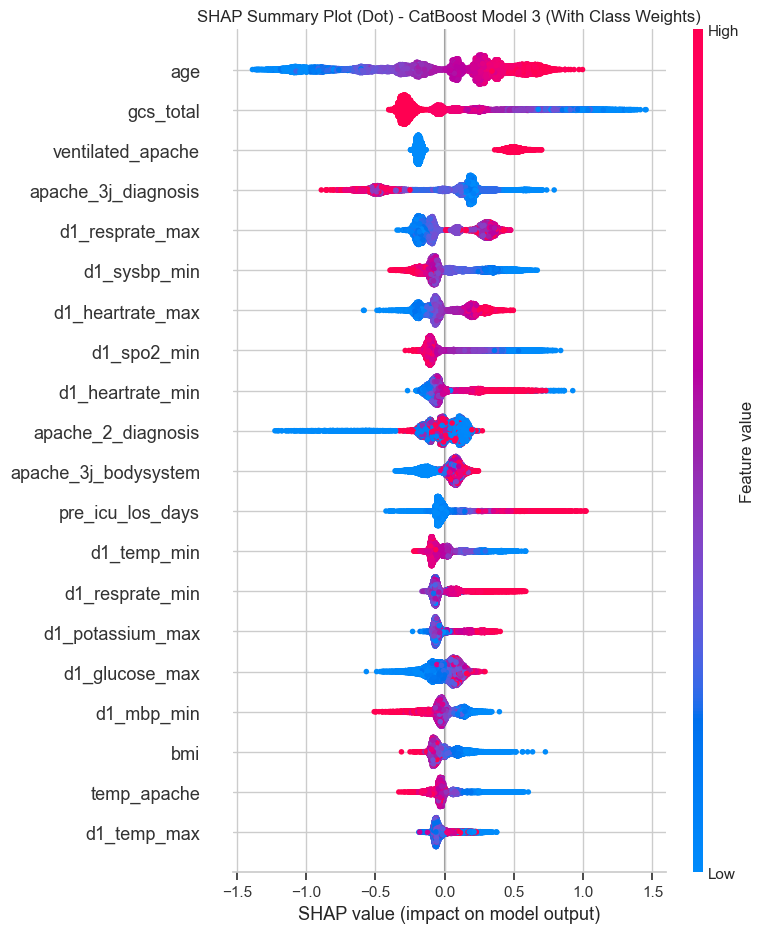

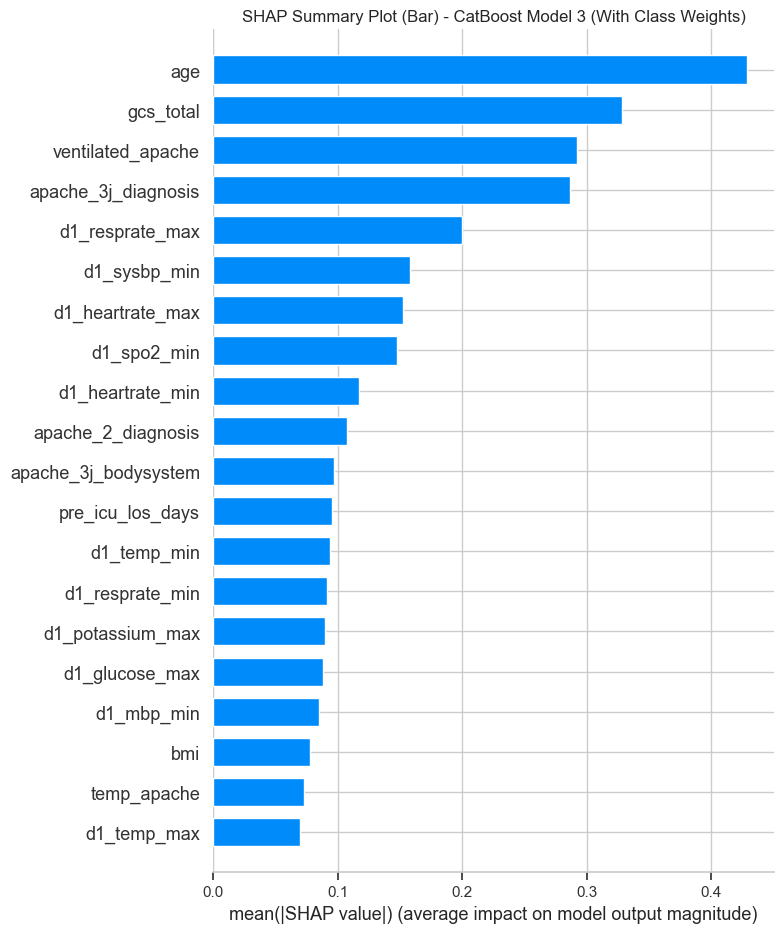

Top 5 features based on SHAP values: ['age', 'gcs_total', 'ventilated_apache', 'apache_3j_diagnosis', 'd1_resprate_max']


<Figure size 800x600 with 0 Axes>

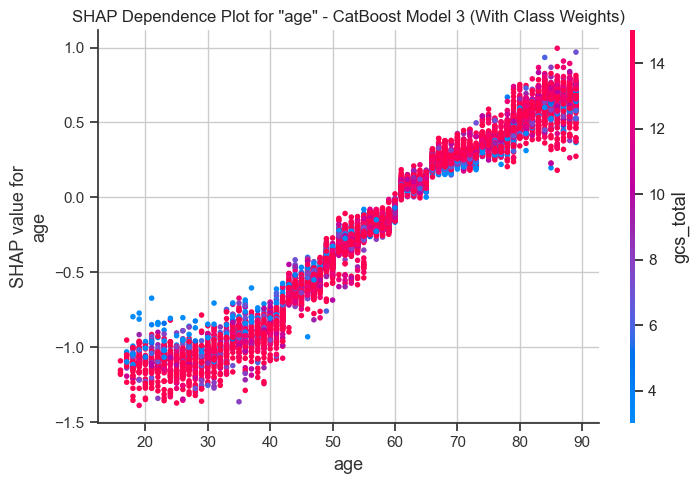

<Figure size 800x600 with 0 Axes>

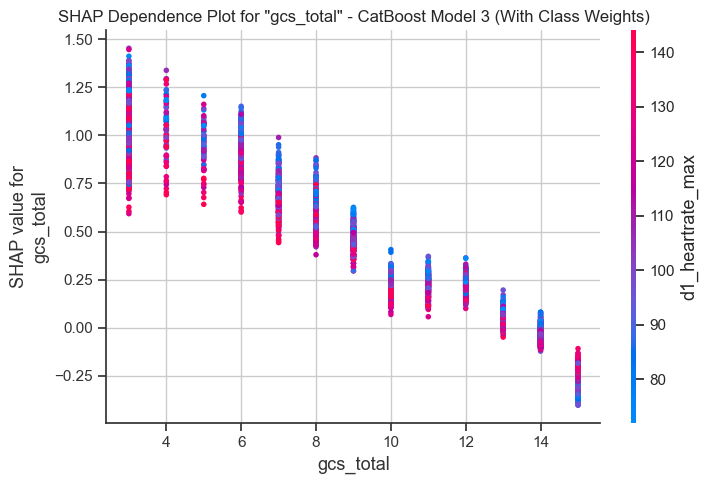

<Figure size 800x600 with 0 Axes>

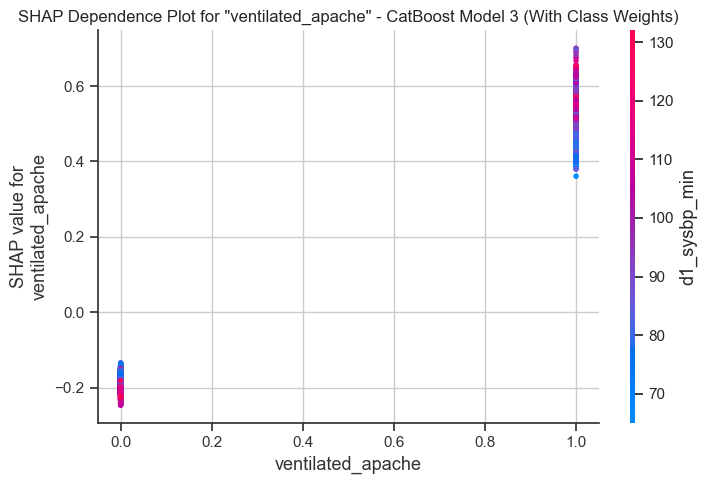

<Figure size 800x600 with 0 Axes>

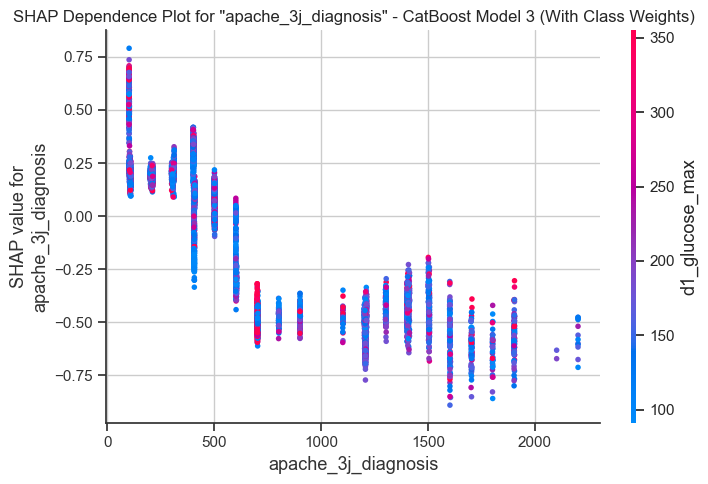

<Figure size 800x600 with 0 Axes>

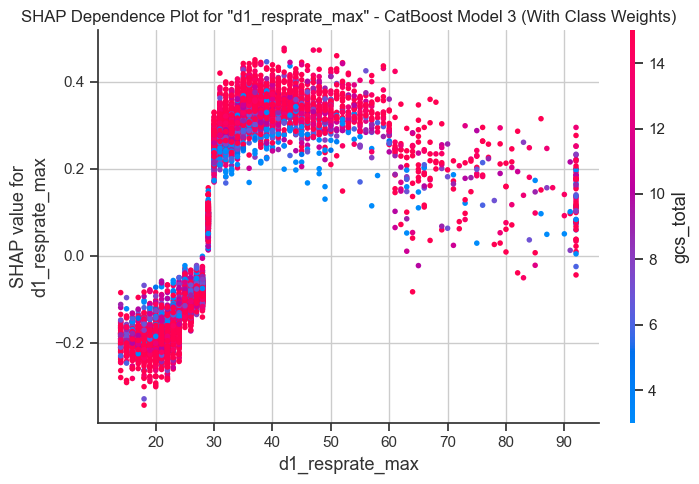

In [816]:
# --- SHAP Analysis for CatBoost Model 3 (Without SMOTENC but With Class Weights) ---

# 1. Install SHAP (if not already installed)
# Uncomment the following line to install SHAP via pip
# !pip install shap

# 2. Import necessary libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Optional: Initialize JavaScript visualization for SHAP (if using Jupyter Notebook)
# shap.initjs()

# 3. Initialize the SHAP Explainer
# For CatBoost models, TreeExplainer is optimized and recommended
explainer_cat3 = shap.Explainer(cat_model3, X_train_ns_ns)

# 4. Compute SHAP values for the test set
shap_values_cat3 = explainer_cat3(X_test_ns_ns)

# 5. Plot SHAP Summary Plot (Dot Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_cat3, X_test_ns_ns, show=False)
plt.title('SHAP Summary Plot (Dot) - CatBoost Model 3 (With Class Weights)')
plt.tight_layout()
plt.show()

# 6. Plot SHAP Summary Plot (Bar Plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_cat3, X_test_ns_ns, plot_type="bar", show=False)
plt.title('SHAP Summary Plot (Bar) - CatBoost Model 3 (With Class Weights)')
plt.tight_layout()
plt.show()

# 7. Identify Top Features based on Mean Absolute SHAP Values
# Calculate mean absolute SHAP values for each feature
shap_abs_mean_cat3 = np.abs(shap_values_cat3.values).mean(axis=0)
feature_names_cat3 = X_test_ns_ns.columns
shap_importance_cat3 = pd.DataFrame({
    'feature': feature_names_cat3,
    'mean_abs_shap': shap_abs_mean_cat3
}).sort_values(by='mean_abs_shap', ascending=False)

# Select top 5 features
top_features_cat3 = shap_importance_cat3['feature'].head(5).tolist()
print(f"Top 5 features based on SHAP values: {top_features_cat3}")

# 8. Plot SHAP Dependence Plots for Top Features
for feature in top_features_cat3:
    plt.figure(figsize=(8, 6))
    shap.dependence_plot(feature, shap_values_cat3.values, X_test_ns_ns, show=False)
    plt.title(f'SHAP Dependence Plot for "{feature}" - CatBoost Model 3 (With Class Weights)')
    plt.tight_layout()
    plt.show()


## SVM

### No SMOTENC

Cross-Validated ROC AUC Scores: [0.79809773 0.8006288  0.82424524 0.78862975 0.81011833]
Mean ROC AUC Score: 0.8043

=== SVM Model 1: Scaled, No SMOTENC ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9273    0.9940    0.9595     11348
           1     0.6991    0.1515    0.2490      1043

    accuracy                         0.9231     12391
   macro avg     0.8132    0.5727    0.6042     12391
weighted avg     0.9080    0.9231    0.8997     12391

Confusion Matrix:
[[11280    68]
 [  885   158]]
ROC AUC Score: 0.7975


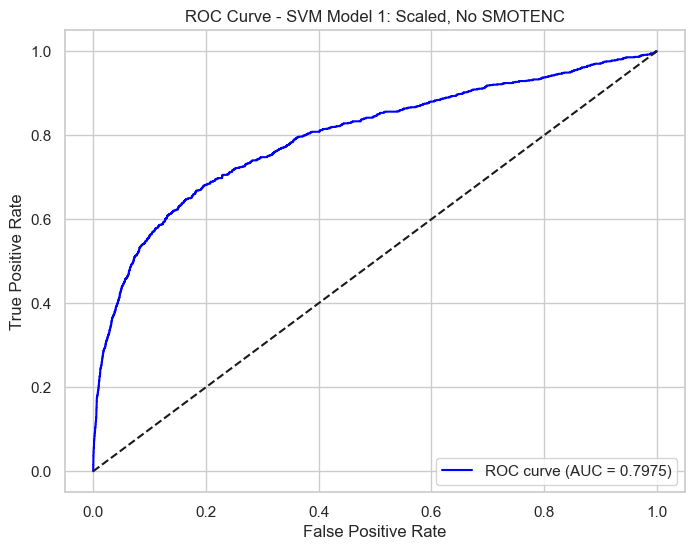

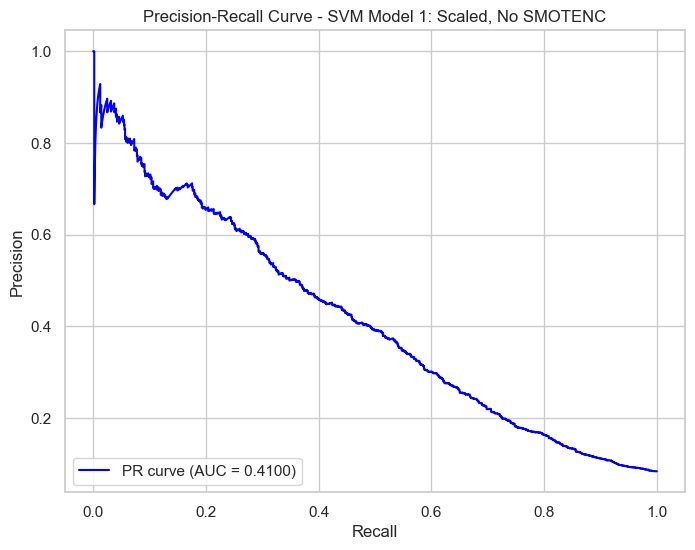

PR AUC Score: 0.4100


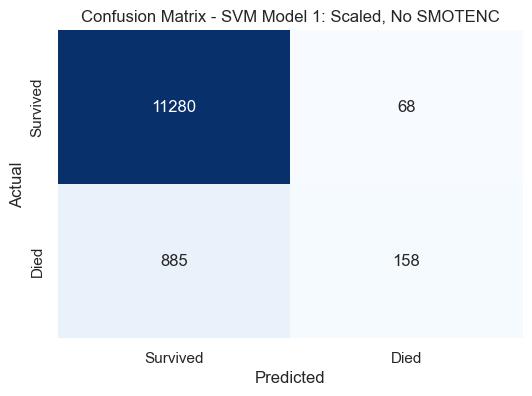

In [817]:
# --- SVM Model 1: Scaled, No SMOTENC ---

# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the SVM Classifier with fixed hyperparameters
svm_model1 = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validated ROC AUC Scores
cv_scores = cross_val_score(
    svm_model1,
    X_train_s_ns,
    y_train_s_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f}")

# Fit the model on the full training data
svm_model1.fit(X_train_s_ns, y_train_s_ns)

# Predict on the test set
y_pred_proba_svm1 = svm_model1.predict_proba(X_test_s_ns)[:, 1]
y_pred_svm1 = svm_model1.predict(X_test_s_ns)

# Evaluate the model
print("\n=== SVM Model 1: Scaled, No SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_svm1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_svm1))
roc_auc_svm1 = roc_auc_score(y_test_s_ns, y_pred_proba_svm1)
print(f"ROC AUC Score: {roc_auc_svm1:.4f}")

# Plot ROC Curve
fpr_svm1, tpr_svm1, thresholds_svm1 = roc_curve(y_test_s_ns, y_pred_proba_svm1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm1, tpr_svm1, label=f'ROC curve (AUC = {roc_auc_svm1:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model 1: Scaled, No SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_svm1, recall_svm1, thresholds_pr_svm1 = precision_recall_curve(y_test_s_ns, y_pred_proba_svm1)
pr_auc_svm1 = auc(recall_svm1, precision_svm1)
plt.figure(figsize=(8, 6))
plt.plot(recall_svm1, precision_svm1, label=f'PR curve (AUC = {pr_auc_svm1:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model 1: Scaled, No SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_svm1:.4f}")

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_svm1,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - SVM Model 1: Scaled, No SMOTENC'
)



Optimal Threshold for Desired Recall of 90%: 0.04
Precision: 0.0967, Recall: 0.9386, F1-score: 0.1754

=== SVM Model 1 (Threshold: 0.04) ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9718    0.1945    0.3241     11348
           1     0.0967    0.9386    0.1754      1043

    accuracy                         0.2571     12391
   macro avg     0.5343    0.5666    0.2498     12391
weighted avg     0.8982    0.2571    0.3116     12391

Confusion Matrix:
[[2207 9141]
 [  64  979]]


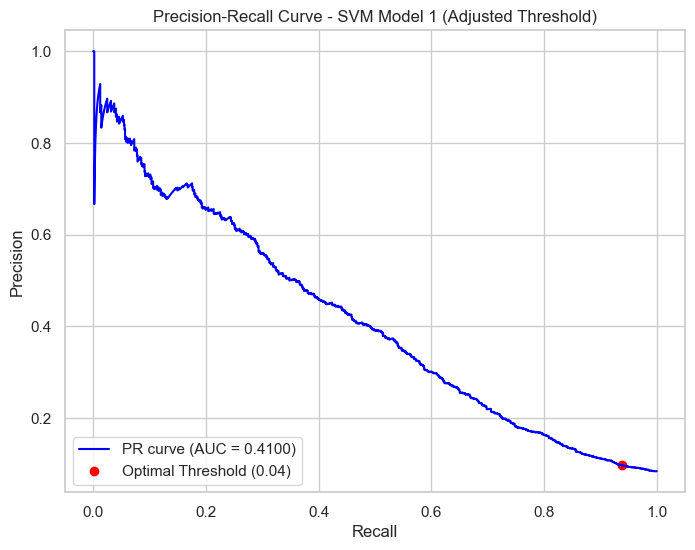

PR AUC Score: 0.4100


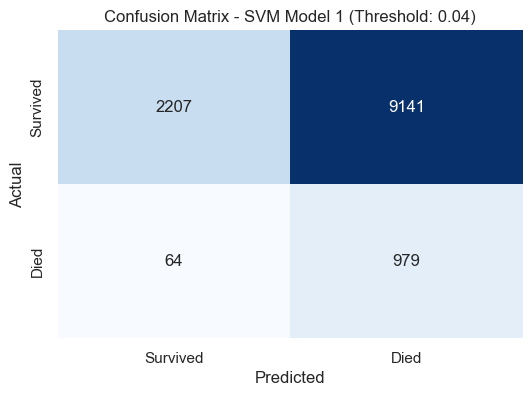

In [818]:
# --- Threshold Adjustment for SVM Model 1 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Desired Recall
desired_recall = 0.90  # 90% Recall

# Compute Precision-Recall Curve
precision_svm1, recall_svm1, thresholds_pr_svm1 = precision_recall_curve(
    y_test_s_ns, y_pred_proba_svm1, pos_label=1
)

# Function to Evaluate Metrics at Various Thresholds
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define Thresholds to Evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate Metrics at Each Threshold
metrics_svm1 = evaluate_thresholds(y_test_s_ns, y_pred_proba_svm1, thresholds_to_evaluate)

# Convert to DataFrame
metrics_df_svm1 = pd.DataFrame(metrics_svm1)

# Select Threshold for Desired Recall
metrics_df_svm1['recall_diff'] = metrics_df_svm1['recall'] - desired_recall
metrics_df_svm1['recall_diff'] = metrics_df_svm1['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_svm1['recall_diff'].idxmin()

if not np.isnan(optimal_index):
    optimal_threshold = metrics_df_svm1.loc[optimal_index, 'threshold']
    precision_at_optimal = metrics_df_svm1.loc[optimal_index, 'precision']
    recall_at_optimal = metrics_df_svm1.loc[optimal_index, 'recall']
    f1_at_optimal = metrics_df_svm1.loc[optimal_index, 'f1_score']
    print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_optimal:.4f}, Recall: {recall_at_optimal:.4f}, F1-score: {f1_at_optimal:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# Predict with Optimal Threshold
y_pred_optimal = (y_pred_proba_svm1 >= optimal_threshold).astype(int)

# Evaluate Model with Optimal Threshold
print(f"\n=== SVM Model 1 (Threshold: {optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_optimal, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_optimal))

# Plot Precision-Recall Curve with Optimal Threshold
plt.figure(figsize=(8, 6))
plt.plot(recall_svm1, precision_svm1, label=f'PR curve (AUC = {pr_auc_svm1:.4f})', color='blue')
plt.scatter(recall_at_optimal, precision_at_optimal, color='red',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model 1 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_svm1:.4f}")

# Plot Confusion Matrix with Optimal Threshold
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_optimal,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - SVM Model 1 (Threshold: {optimal_threshold:.2f})'
)


### SMOTENC

In [ ]:
# --- SVM Model 2: Scaled, With SMOTENC ---

# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the SVM Classifier with fixed hyperparameters
svm_model2 = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validated ROC AUC Scores
cv_scores = cross_val_score(
    svm_model2,
    X_train_s_s,
    y_train_s_s,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f}")

# Fit the model on the full training data
svm_model2.fit(X_train_s_s, y_train_s_s)

# Predict on the test set
y_pred_proba_svm2 = svm_model2.predict_proba(X_test_s_s)[:, 1]
y_pred_svm2 = svm_model2.predict(X_test_s_s)

# Evaluate the model
print("\n=== SVM Model 2: Scaled, With SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_svm2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_svm2))
roc_auc_svm2 = roc_auc_score(y_test_s_s, y_pred_proba_svm2)
print(f"ROC AUC Score: {roc_auc_svm2:.4f}")

# Plot ROC Curve
fpr_svm2, tpr_svm2, thresholds_svm2 = roc_curve(y_test_s_s, y_pred_proba_svm2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm2, tpr_svm2, label=f'ROC curve (AUC = {roc_auc_svm2:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model 2: Scaled, With SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_svm2, recall_svm2, thresholds_pr_svm2 = precision_recall_curve(y_test_s_s, y_pred_proba_svm2)
pr_auc_svm2 = auc(recall_svm2, precision_svm2)
plt.figure(figsize=(8, 6))
plt.plot(recall_svm2, precision_svm2, label=f'PR curve (AUC = {pr_auc_svm2:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model 2: Scaled, With SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_svm2:.4f}")

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(
    y_test_s_s,
    y_pred_svm2,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - SVM Model 2: Scaled, With SMOTENC'
)


In [ ]:
# --- Threshold Adjustment for SVM Model 2 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Desired Recall
desired_recall = 0.90  # 90% Recall

# Compute Precision-Recall Curve
precision_svm2, recall_svm2, thresholds_pr_svm2 = precision_recall_curve(
    y_test_s_s, y_pred_proba_svm2, pos_label=1
)

# Function to Evaluate Metrics at Various Thresholds
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define Thresholds to Evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate Metrics at Each Threshold
metrics_svm2 = evaluate_thresholds(y_test_s_s, y_pred_proba_svm2, thresholds_to_evaluate)

# Convert to DataFrame
metrics_df_svm2 = pd.DataFrame(metrics_svm2)

# Select Threshold for Desired Recall
metrics_df_svm2['recall_diff'] = metrics_df_svm2['recall'] - desired_recall
metrics_df_svm2['recall_diff'] = metrics_df_svm2['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_svm2['recall_diff'].idxmin()

if not np.isnan(optimal_index):
    optimal_threshold = metrics_df_svm2.loc[optimal_index, 'threshold']
    precision_at_optimal = metrics_df_svm2.loc[optimal_index, 'precision']
    recall_at_optimal = metrics_df_svm2.loc[optimal_index, 'recall']
    f1_at_optimal = metrics_df_svm2.loc[optimal_index, 'f1_score']
    print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_optimal:.4f}, Recall: {recall_at_optimal:.4f}, F1-score: {f1_at_optimal:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# Predict with Optimal Threshold
y_pred_optimal = (y_pred_proba_svm2 >= optimal_threshold).astype(int)

# Evaluate Model with Optimal Threshold
print(f"\n=== SVM Model 2 (Threshold: {optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_optimal, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_optimal))

# Plot Precision-Recall Curve with Optimal Threshold
plt.figure(figsize=(8, 6))
plt.plot(recall_svm2, precision_svm2, label=f'PR curve (AUC = {pr_auc_svm2:.4f})', color='green')
plt.scatter(recall_at_optimal, precision_at_optimal, color='red',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model 2 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_svm2:.4f}")

# Plot Confusion Matrix with Optimal Threshold
plot_confusion_matrix(
    y_test_s_s,
    y_pred_optimal,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - SVM Model 2 (Threshold: {optimal_threshold:.2f})'
)


### Class Weights

In [ ]:
# --- SVM Model 3: Scaled, No SMOTENC, With Class Weights Balanced ---

# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the SVM Classifier with Class Weights
svm_model3 = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    class_weight='balanced',
    random_state=42
)

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validated ROC AUC Scores
cv_scores = cross_val_score(
    svm_model3,
    X_train_s_ns,
    y_train_s_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f}")

# Fit the model on the full training data
svm_model3.fit(X_train_s_ns, y_train_s_ns)

# Predict on the test set
y_pred_proba_svm3 = svm_model3.predict_proba(X_test_s_ns)[:, 1]
y_pred_svm3 = svm_model3.predict(X_test_s_ns)

# Evaluate the model
print("\n=== SVM Model 3: Scaled, No SMOTENC, With Class Weights Balanced ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_svm3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_svm3))
roc_auc_svm3 = roc_auc_score(y_test_s_ns, y_pred_proba_svm3)
print(f"ROC AUC Score: {roc_auc_svm3:.4f}")

# Plot ROC Curve
fpr_svm3, tpr_svm3, thresholds_svm3 = roc_curve(y_test_s_ns, y_pred_proba_svm3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm3, tpr_svm3, label=f'ROC curve (AUC = {roc_auc_svm3:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model 3: Scaled, No SMOTENC, With Class Weights Balanced')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_svm3, recall_svm3, thresholds_pr_svm3 = precision_recall_curve(y_test_s_ns, y_pred_proba_svm3)
pr_auc_svm3 = auc(recall_svm3, precision_svm3)
plt.figure(figsize=(8, 6))
plt.plot(recall_svm3, precision_svm3, label=f'PR curve (AUC = {pr_auc_svm3:.4f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model 3: Scaled, No SMOTENC, With Class Weights Balanced')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_svm3:.4f}")

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_svm3,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - SVM Model 3: Scaled, No SMOTENC, With Class Weights Balanced'
)


In [ ]:
# --- Threshold Adjustment for SVM Model 3 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Desired Recall
desired_recall = 0.90  # 90% Recall

# Compute Precision-Recall Curve
precision_svm3, recall_svm3, thresholds_pr_svm3 = precision_recall_curve(
    y_test_s_ns, y_pred_proba_svm3, pos_label=1
)

# Function to Evaluate Metrics at Various Thresholds
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define Thresholds to Evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate Metrics at Each Threshold
metrics_svm3 = evaluate_thresholds(y_test_s_ns, y_pred_proba_svm3, thresholds_to_evaluate)

# Convert to DataFrame
metrics_df_svm3 = pd.DataFrame(metrics_svm3)

# Select Threshold for Desired Recall
metrics_df_svm3['recall_diff'] = metrics_df_svm3['recall'] - desired_recall
metrics_df_svm3['recall_diff'] = metrics_df_svm3['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_svm3['recall_diff'].idxmin()

if not np.isnan(optimal_index):
    optimal_threshold = metrics_df_svm3.loc[optimal_index, 'threshold']
    precision_at_optimal = metrics_df_svm3.loc[optimal_index, 'precision']
    recall_at_optimal = metrics_df_svm3.loc[optimal_index, 'recall']
    f1_at_optimal = metrics_df_svm3.loc[optimal_index, 'f1_score']
    print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_optimal:.4f}, Recall: {recall_at_optimal:.4f}, F1-score: {f1_at_optimal:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# Predict with Optimal Threshold
y_pred_optimal = (y_pred_proba_svm3 >= optimal_threshold).astype(int)

# Evaluate Model with Optimal Threshold
print(f"\n=== SVM Model 3 (Threshold: {optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_optimal, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_optimal))

# Plot Precision-Recall Curve with Optimal Threshold
plt.figure(figsize=(8, 6))
plt.plot(recall_svm3, precision_svm3, label=f'PR curve (AUC = {pr_auc_svm3:.4f})', color='purple')
plt.scatter(recall_at_optimal, precision_at_optimal, color='red',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVM Model 3 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_svm3:.4f}")

# Plot Confusion Matrix with Optimal Threshold
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_optimal,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - SVM Model 3 (Threshold: {optimal_threshold:.2f})'
)


In [ ]:
# --- Adjusted SHAP Analysis for SVM Model 3 ---

# 1. Install SHAP if not already installed
# Uncomment the following line if SHAP is not installed
# !pip install shap

# 2. Import necessary libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 3. Ensure that svm_model3 is already trained and available
# and that X_test_s_ns is your test feature set

# 4. Create a sample of the test data for SHAP to speed up computation
# Adjust the sample size based on your computational resources
sample_size = 100  # Number of samples to explain
if X_test_s_ns.shape[0] > sample_size:
    X_sample = X_test_s_ns.sample(n=sample_size, random_state=42)
else:
    X_sample = X_test_s_ns.copy()

# 5. Initialize the SHAP KernelExplainer with a function that returns probabilities for class 1
# Use a background dataset, here we use a subset of the training data
background_size = 100  # Number of background samples
if X_train_s_ns.shape[0] > background_size:
    X_background = X_train_s_ns.sample(n=background_size, random_state=42)
else:
    X_background = X_train_s_ns.copy()

# Convert to NumPy arrays for SHAP
X_background_np = X_background.values
X_sample_np = X_sample.values

# 6. Verify Data Orientation
print(f"Original X_background_np shape: {X_background_np.shape}")
print(f"Original X_sample_np shape: {X_sample_np.shape}")

# If features and samples are swapped, transpose the arrays
if X_background_np.shape[0] != 100 and X_background_np.shape[1] == 43:
    X_background_np = X_background_np.T
    print("Transposed X_background_np to correct orientation.")

if X_sample_np.shape[0] != 100 and X_sample_np.shape[1] == 43:
    X_sample_np = X_sample_np.T
    print("Transposed X_sample_np to correct orientation.")

# Re-check shapes
print(f"Adjusted X_background_np shape: {X_background_np.shape}")
print(f"Adjusted X_sample_np shape: {X_sample_np.shape}")

# 7. Initialize the explainer with a function that returns probabilities for class 1
explainer = shap.KernelExplainer(lambda x: svm_model3.predict_proba(x)[:, 1], X_background_np)

# 8. Compute SHAP values for the sample
print("Computing SHAP values... This may take a while depending on the sample size.")
shap_values = explainer.shap_values(X_sample_np, nsamples=100)

# 9. Diagnose the Shape Mismatch
print(f"Shape of shap_values: {shap_values.shape}")       # Expected: (100, 43)
print(f"Shape of X_sample_np: {X_sample_np.shape}")     # Expected: (100, 43)

# 10. Verify and Adjust SHAP Values if Necessary
# For binary classification, shap_values should be a single array for the positive class
if isinstance(shap_values, list):
    # shap_values is a list with two arrays (for each class)
    print(f"Number of classes: {len(shap_values)}")
    if shap_values[1].shape != X_sample_np.shape:
        print("Detected shape mismatch in shap_values[1]. Excluding any extra columns if present.")
        # If shap_values[1] has an extra column (bias term), exclude it
        if shap_values[1].shape[1] == X_sample_np.shape[1] + 1:
            adjusted_shap_values = shap_values[1][:, :-1]
            print("Excluded the last column of shap_values[1].")
        else:
            # If no extra columns, but still mismatch, raise an error
            raise AssertionError("shap_values[1] shape does not match X_sample_np. Check model and data alignment.")
    else:
        adjusted_shap_values = shap_values[1]
else:
    # shap_values is a single array
    adjusted_shap_values = shap_values

# 11. Plot SHAP Summary Plot
shap.initjs()
plt.figure(figsize=(10, 8))
shap.summary_plot(adjusted_shap_values, X_sample_np, feature_names=X_test_s_ns.columns, show=False)
plt.title('SHAP Summary Plot - SVM Model 3')
plt.tight_layout()
plt.show()

# 12. Identify the top feature based on absolute SHAP values
shap_abs_mean = np.abs(adjusted_shap_values).mean(axis=0)
top_feature_index = np.argmax(shap_abs_mean)
top_feature_name = X_test_s_ns.columns[top_feature_index]

# 13. Plot SHAP Dependence Plot for the top feature
plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature_index, adjusted_shap_values, X_sample_np, feature_names=X_test_s_ns.columns, show=False)
plt.title(f'SHAP Dependence Plot - {top_feature_name} (SVM Model 3)')
plt.tight_layout()
plt.show()

# 14. (Optional) Plot SHAP Force Plot for an Individual Prediction
sample_idx = 0  # Change this index to visualize different samples
shap.force_plot(
    explainer.expected_value,
    adjusted_shap_values[sample_idx],
    X_sample_np[sample_idx],
    feature_names=X_test_s_ns.columns,
    matplotlib=True,
    show=False
)
plt.title('SHAP Force Plot - Individual Prediction')
plt.tight_layout()
plt.show()

# 15. (Optional) Save SHAP Plots
# Uncomment the following lines to save the plots
# plt.savefig('shap_summary_plot_model3.png', bbox_inches='tight')
# plt.savefig('shap_dependence_plot_model3.png', bbox_inches='tight')
# shap.save_html('shap_force_plot_model3.html', shap.force_plot(
#     explainer.expected_value,
#     adjusted_shap_values[sample_idx],
#     X_sample_np[sample_idx],
#     feature_names=X_test_s_ns.columns
# ))


## Guassian 

### No SMOTENC

In [ ]:
# --- GaussianNB Model 1: Scaled, No SMOTENC ---

# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize Gaussian Naive Bayes
gnb_model1 = GaussianNB()

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validated ROC AUC Scores
cv_scores = cross_val_score(
    gnb_model1,
    X_train_s_ns,
    y_train_s_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores for GaussianNB Model 1: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f}")

# Fit the model on the full training data
gnb_model1.fit(X_train_s_ns, y_train_s_ns)

# Predict on the test set
y_pred_proba_gnb1 = gnb_model1.predict_proba(X_test_s_ns)[:, 1]
y_pred_gnb1 = gnb_model1.predict(X_test_s_ns)

# Evaluate the model
print("\n=== GaussianNB Model 1: Scaled, No SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_gnb1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_gnb1))
roc_auc_gnb1 = roc_auc_score(y_test_s_ns, y_pred_proba_gnb1)
print(f"ROC AUC Score: {roc_auc_gnb1:.4f}")

# Plot ROC Curve
fpr_gnb1, tpr_gnb1, thresholds_gnb1 = roc_curve(y_test_s_ns, y_pred_proba_gnb1)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb1, tpr_gnb1, label=f'ROC curve (AUC = {roc_auc_gnb1:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB Model 1: Scaled, No SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_gnb1, recall_gnb1, thresholds_pr_gnb1 = precision_recall_curve(y_test_s_ns, y_pred_proba_gnb1)
pr_auc_gnb1 = auc(recall_gnb1, precision_gnb1)
plt.figure(figsize=(8, 6))
plt.plot(recall_gnb1, precision_gnb1, label=f'PR curve (AUC = {pr_auc_gnb1:.4f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB Model 1: Scaled, No SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_gnb1:.4f}")

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_gnb1,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - GaussianNB Model 1: Scaled, No SMOTENC'
)


In [ ]:
# --- Threshold Adjustment for GaussianNB Model 1 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Desired Recall
desired_recall = 0.90  # 90% Recall

# Compute Precision-Recall Curve
precision_gnb1, recall_gnb1, thresholds_pr_gnb1 = precision_recall_curve(
    y_test_s_ns, y_pred_proba_gnb1, pos_label=1
)

# Function to Evaluate Metrics at Various Thresholds
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define Thresholds to Evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate Metrics at Each Threshold
metrics_gnb1 = evaluate_thresholds(y_test_s_ns, y_pred_proba_gnb1, thresholds_to_evaluate)

# Convert to DataFrame
metrics_df_gnb1 = pd.DataFrame(metrics_gnb1)

# Select Threshold for Desired Recall
metrics_df_gnb1['recall_diff'] = metrics_df_gnb1['recall'] - desired_recall
metrics_df_gnb1['recall_diff'] = metrics_df_gnb1['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_gnb1['recall_diff'].idxmin()

if not np.isnan(optimal_index):
    optimal_threshold = metrics_df_gnb1.loc[optimal_index, 'threshold']
    precision_at_optimal = metrics_df_gnb1.loc[optimal_index, 'precision']
    recall_at_optimal = metrics_df_gnb1.loc[optimal_index, 'recall']
    f1_at_optimal = metrics_df_gnb1.loc[optimal_index, 'f1_score']
    print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_optimal:.4f}, Recall: {recall_at_optimal:.4f}, F1-score: {f1_at_optimal:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# Predict with Optimal Threshold
y_pred_optimal_gnb1 = (y_pred_proba_gnb1 >= optimal_threshold).astype(int)

# Evaluate Model with Optimal Threshold
print(f"\n=== GaussianNB Model 1 (Threshold: {optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_optimal_gnb1, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_optimal_gnb1))

# Plot Precision-Recall Curve with Optimal Threshold
plt.figure(figsize=(8, 6))
plt.plot(recall_gnb1, precision_gnb1, label=f'PR curve (AUC = {pr_auc_gnb1:.4f})', color='blue')
plt.scatter(recall_at_optimal, precision_at_optimal, color='red',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB Model 1 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_gnb1:.4f}")

# Plot Confusion Matrix with Optimal Threshold
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_optimal_gnb1,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - GaussianNB Model 1 (Threshold: {optimal_threshold:.2f})'
)


### SMOTENC

In [ ]:
# --- GaussianNB Model 2: Scaled, With SMOTENC ---

# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize Gaussian Naive Bayes
gnb_model2 = GaussianNB()

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validated ROC AUC Scores
cv_scores = cross_val_score(
    gnb_model2,
    X_train_s_s,
    y_train_s_s,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores for GaussianNB Model 2: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f}")

# Fit the model on the full training data
gnb_model2.fit(X_train_s_s, y_train_s_s)

# Predict on the test set
y_pred_proba_gnb2 = gnb_model2.predict_proba(X_test_s_s)[:, 1]
y_pred_gnb2 = gnb_model2.predict(X_test_s_s)

# Evaluate the model
print("\n=== GaussianNB Model 2: Scaled, With SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_gnb2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_gnb2))
roc_auc_gnb2 = roc_auc_score(y_test_s_s, y_pred_proba_gnb2)
print(f"ROC AUC Score: {roc_auc_gnb2:.4f}")

# Plot ROC Curve
fpr_gnb2, tpr_gnb2, thresholds_gnb2 = roc_curve(y_test_s_s, y_pred_proba_gnb2)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb2, tpr_gnb2, label=f'ROC curve (AUC = {roc_auc_gnb2:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB Model 2: Scaled, With SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_gnb2, recall_gnb2, thresholds_pr_gnb2 = precision_recall_curve(y_test_s_s, y_pred_proba_gnb2)
pr_auc_gnb2 = auc(recall_gnb2, precision_gnb2)
plt.figure(figsize=(8, 6))
plt.plot(recall_gnb2, precision_gnb2, label=f'PR curve (AUC = {pr_auc_gnb2:.4f})', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB Model 2: Scaled, With SMOTENC')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_gnb2:.4f}")

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(
    y_test_s_s,
    y_pred_gnb2,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - GaussianNB Model 2: Scaled, With SMOTENC'
)


In [ ]:
# --- Threshold Adjustment for GaussianNB Model 2 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Desired Recall
desired_recall = 0.90  # 90% Recall

# Compute Precision-Recall Curve
precision_gnb2, recall_gnb2, thresholds_pr_gnb2 = precision_recall_curve(
    y_test_s_s, y_pred_proba_gnb2, pos_label=1
)

# Function to Evaluate Metrics at Various Thresholds
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define Thresholds to Evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate Metrics at Each Threshold
metrics_gnb2 = evaluate_thresholds(y_test_s_s, y_pred_proba_gnb2, thresholds_to_evaluate)

# Convert to DataFrame
metrics_df_gnb2 = pd.DataFrame(metrics_gnb2)

# Select Threshold for Desired Recall
metrics_df_gnb2['recall_diff'] = metrics_df_gnb2['recall'] - desired_recall
metrics_df_gnb2['recall_diff'] = metrics_df_gnb2['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_gnb2['recall_diff'].idxmin()

if not np.isnan(optimal_index):
    optimal_threshold = metrics_df_gnb2.loc[optimal_index, 'threshold']
    precision_at_optimal = metrics_df_gnb2.loc[optimal_index, 'precision']
    recall_at_optimal = metrics_df_gnb2.loc[optimal_index, 'recall']
    f1_at_optimal = metrics_df_gnb2.loc[optimal_index, 'f1_score']
    print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_optimal:.4f}, Recall: {recall_at_optimal:.4f}, F1-score: {f1_at_optimal:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# Predict with Optimal Threshold
y_pred_optimal_gnb2 = (y_pred_proba_gnb2 >= optimal_threshold).astype(int)

# Evaluate Model with Optimal Threshold
print(f"\n=== GaussianNB Model 2 (Threshold: {optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_optimal_gnb2, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_optimal_gnb2))

# Plot Precision-Recall Curve with Optimal Threshold
plt.figure(figsize=(8, 6))
plt.plot(recall_gnb2, precision_gnb2, label=f'PR curve (AUC = {pr_auc_gnb2:.4f})', color='green')
plt.scatter(recall_at_optimal, precision_at_optimal, color='red',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB Model 2 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_gnb2:.4f}")

# Plot Confusion Matrix with Optimal Threshold
plot_confusion_matrix(
    y_test_s_s,
    y_pred_optimal_gnb2,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - GaussianNB Model 2 (Threshold: {optimal_threshold:.2f})'
)


In [ ]:
# --- SHAP Analysis for GaussianNB Model 2 ---

# 1. Import Necessary Libraries
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import GaussianNB

# 2. Verify Model and Data Availability
# Ensure that gnb_model2 (GaussianNB Model 2) is already trained
# and that X_train_s_s, y_train_s_s, X_test_s_s, y_test_s_s are defined
try:
    gnb_model2
except NameError:
    raise NameError("gnb_model2 (GaussianNB Model 2) is not defined. Please train the model before proceeding.")

# 3. Sample the Test Data for SHAP Analysis
sample_size = 100  # Adjust based on your computational resources
if X_test_s_s.shape[0] > sample_size:
    X_sample = X_test_s_s.sample(n=sample_size, random_state=42)
else:
    X_sample = X_test_s_s.copy()

# 4. Define the Background Dataset for SHAP
background_size = 100  # Adjust based on your computational resources
if X_train_s_s.shape[0] > background_size:
    X_background = X_train_s_s.sample(n=background_size, random_state=42)
else:
    X_background = X_train_s_s.copy()

# 5. Convert to NumPy Arrays
X_background_np = X_background.values
X_sample_np = X_sample.values

# 6. Initialize the SHAP Explainer for GaussianNB
# GaussianNB is a probabilistic model; use KernelExplainer
# Define a function that returns the probability for the positive class
def model_predict_proba(x):
    return gnb_model2.predict_proba(x)[:, 1]

# Initialize the KernelExplainer with the model's predict_proba function
explainer = shap.KernelExplainer(model_predict_proba, X_background_np)

# 7. Compute SHAP Values for the Sample
print("Computing SHAP values... This may take a moment.")
shap_values = explainer.shap_values(X_sample_np, nsamples=100)

# 8. Verify the Shape of SHAP Values and Input Data
print(f"Shape of shap_values: {shap_values.shape}")       # Expected: (100, 43)
print(f"Shape of X_sample_np: {X_sample_np.shape}")     # Expected: (100, 43)

# Check for shape mismatch
if shap_values.shape != X_sample_np.shape:
    raise AssertionError(f"Mismatch in SHAP values and input data shapes: "
                         f"shap_values shape {shap_values.shape}, "
                         f"input data shape {X_sample_np.shape}")

# 9. Generate SHAP Summary Plot
shap.initjs()
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample_np, feature_names=X_test_s_s.columns, show=False)
plt.title('SHAP Summary Plot - GaussianNB Model 2')
plt.tight_layout()
plt.show()

# 10. Identify and Plot the Top Feature
# Calculate the mean absolute SHAP value for each feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)
top_feature_index = np.argmax(shap_abs_mean)
top_feature_name = X_test_s_s.columns[top_feature_index]
print(f"Top feature based on SHAP values: {top_feature_name}")

# Generate SHAP Dependence Plot for the Top Feature
plt.figure(figsize=(10, 6))
shap.dependence_plot(top_feature_index, shap_values, X_sample_np, feature_names=X_test_s_s.columns, show=False)
plt.title(f'SHAP Dependence Plot - {top_feature_name} (GaussianNB Model 2)')
plt.tight_layout()
plt.show()

# 11. (Optional) Generate SHAP Force Plot for an Individual Prediction
# Choose a sample index to visualize; change 'sample_idx' as needed
sample_idx = 0  # Index of the sample to visualize
plt.figure(figsize=(12, 2))
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_sample_np[sample_idx],
    feature_names=X_test_s_s.columns,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot - Sample Index {sample_idx} (GaussianNB Model 2)')
plt.tight_layout()
plt.show()

# 12. (Optional) Save SHAP Plots
# Uncomment the following lines to save the plots
# plt.savefig('shap_summary_plot_gnb_model2.png', bbox_inches='tight')
# plt.savefig('shap_dependence_plot_gnb_model2.png', bbox_inches='tight')
# shap.save_html('shap_force_plot_gnb_model2.html', shap.force_plot(
#     explainer.expected_value,
#     shap_values[sample_idx],
#     X_sample_np[sample_idx],
#     feature_names=X_test_s_s.columns
# ))


### Class Weights 

In [ ]:
# --- GaussianNB Model 3: Scaled, No SMOTENC, Balanced Class Priors ---

# Import necessary libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate class priors based on the training data
class_counts = y_train_s_ns.value_counts(normalize=True)
priors = class_counts.sort_index().values  # Ensure classes are in order [0,1]

# Initialize Gaussian Naive Bayes with balanced class priors
gnb_model3 = GaussianNB(priors=priors)

# Define Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validated ROC AUC Scores
cv_scores = cross_val_score(
    gnb_model3,
    X_train_s_ns,
    y_train_s_ns,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)
print(f"Cross-Validated ROC AUC Scores for GaussianNB Model 3: {cv_scores}")
print(f"Mean ROC AUC Score: {cv_scores.mean():.4f}")

# Fit the model on the full training data
gnb_model3.fit(X_train_s_ns, y_train_s_ns)

# Predict on the test set
y_pred_proba_gnb3 = gnb_model3.predict_proba(X_test_s_ns)[:, 1]
y_pred_gnb3 = gnb_model3.predict(X_test_s_ns)

# Evaluate the model
print("\n=== GaussianNB Model 3: Scaled, No SMOTENC, Balanced Class Priors ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_gnb3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_gnb3))
roc_auc_gnb3 = roc_auc_score(y_test_s_ns, y_pred_proba_gnb3)
print(f"ROC AUC Score: {roc_auc_gnb3:.4f}")

# Plot ROC Curve
fpr_gnb3, tpr_gnb3, thresholds_gnb3 = roc_curve(y_test_s_ns, y_pred_proba_gnb3)
plt.figure(figsize=(8, 6))
plt.plot(fpr_gnb3, tpr_gnb3, label=f'ROC curve (AUC = {roc_auc_gnb3:.4f})', color='purple')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB Model 3: Scaled, No SMOTENC, Balanced Class Priors')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall Curve
precision_gnb3, recall_gnb3, thresholds_pr_gnb3 = precision_recall_curve(y_test_s_ns, y_pred_proba_gnb3)
pr_auc_gnb3 = auc(recall_gnb3, precision_gnb3)
plt.figure(figsize=(8, 6))
plt.plot(recall_gnb3, precision_gnb3, label=f'PR curve (AUC = {pr_auc_gnb3:.4f})', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB Model 3: Scaled, No SMOTENC, Balanced Class Priors')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_gnb3:.4f}")

# Function to Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_gnb3,
    classes=['Survived', 'Died'],
    title='Confusion Matrix - GaussianNB Model 3: Scaled, No SMOTENC, Balanced Class Priors'
)


In [ ]:
# --- Threshold Adjustment for GaussianNB Model 3 ---

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    auc
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Desired Recall
desired_recall = 0.90  # 90% Recall

# Compute Precision-Recall Curve
precision_gnb3, recall_gnb3, thresholds_pr_gnb3 = precision_recall_curve(
    y_test_s_ns, y_pred_proba_gnb3, pos_label=1
)

# Function to Evaluate Metrics at Various Thresholds
def evaluate_thresholds(y_true, y_proba, thresholds):
    metrics_list = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        metrics_list.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        })
    return metrics_list

# Define Thresholds to Evaluate
thresholds_to_evaluate = np.linspace(0, 1, 101)

# Evaluate Metrics at Each Threshold
metrics_gnb3 = evaluate_thresholds(y_test_s_ns, y_pred_proba_gnb3, thresholds_to_evaluate)

# Convert to DataFrame
metrics_df_gnb3 = pd.DataFrame(metrics_gnb3)

# Select Threshold for Desired Recall
metrics_df_gnb3['recall_diff'] = metrics_df_gnb3['recall'] - desired_recall
metrics_df_gnb3['recall_diff'] = metrics_df_gnb3['recall_diff'].apply(lambda x: x if x >= 0 else np.nan)
optimal_index = metrics_df_gnb3['recall_diff'].idxmin()

if not np.isnan(optimal_index):
    optimal_threshold = metrics_df_gnb3.loc[optimal_index, 'threshold']
    precision_at_optimal = metrics_df_gnb3.loc[optimal_index, 'precision']
    recall_at_optimal = metrics_df_gnb3.loc[optimal_index, 'recall']
    f1_at_optimal = metrics_df_gnb3.loc[optimal_index, 'f1_score']
    print(f"\nOptimal Threshold for Desired Recall of {desired_recall*100:.0f}%: {optimal_threshold:.2f}")
    print(f"Precision: {precision_at_optimal:.4f}, Recall: {recall_at_optimal:.4f}, F1-score: {f1_at_optimal:.4f}")
else:
    print("\nDesired recall not achievable with the model.")
    optimal_threshold = 0.5  # Default threshold

# Predict with Optimal Threshold
y_pred_optimal_gnb3 = (y_pred_proba_gnb3 >= optimal_threshold).astype(int)

# Evaluate Model with Optimal Threshold
print(f"\n=== GaussianNB Model 3 (Threshold: {optimal_threshold:.2f}) ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_optimal_gnb3, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_optimal_gnb3))

# Plot Precision-Recall Curve with Optimal Threshold
plt.figure(figsize=(8, 6))
plt.plot(recall_gnb3, precision_gnb3, label=f'PR curve (AUC = {pr_auc_gnb3:.4f})', color='purple')
plt.scatter(recall_at_optimal, precision_at_optimal, color='red',
            label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - GaussianNB Model 3 (Adjusted Threshold)')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
print(f"PR AUC Score: {pr_auc_gnb3:.4f}")

# Plot Confusion Matrix with Optimal Threshold
plot_confusion_matrix(
    y_test_s_ns,
    y_pred_optimal_gnb3,
    classes=['Survived', 'Died'],
    title=f'Confusion Matrix - GaussianNB Model 3 (Threshold: {optimal_threshold:.2f})'
)


## Stacking Classifier

### No SMOTENC

In [ ]:
# --- Cell 1A: Training the Stacking Classifier Without SMOTENC ---

# 1. Import Necessary Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# 2. Define Base Models
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight=None  # No class weights
)

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
    # GradientBoostingClassifier does not support 'class_weight' directly
)

svm_clf = SVC(
    probability=True,  # Enables probability estimates
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight=None,  # No class weights
    random_state=42
)

# 3. Define Meta-Classifier
meta_clf = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    class_weight=None  # No class weights
)

# 4. Initialize Stacking Classifier
estimators = [
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('svm', svm_clf)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_clf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    stack_method='predict_proba',  # Use probability estimates for meta-classifier
    passthrough=False,  # Do not include original features to meta-classifier
    n_jobs=-1  # Utilize all available cores
)

# 5. Train the Stacking Classifier on Scaled, No SMOTENC Dataset
print("Training the Stacking Classifier without SMOTENC...")
stacking_clf.fit(X_train_s_ns, y_train_s_ns)
print("Training completed successfully.")


### SMOTENC

In [ ]:
# --- Cell 2A: Training the Stacking Classifier With SMOTENC ---

# 1. Import Necessary Libraries (if not already imported)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc

# 2. Define Base Models
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight=None  # No class weights
)

gb_clf = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
    # GradientBoostingClassifier does not support 'class_weight' directly
)

svm_clf = SVC(
    probability=True,  # Enables probability estimates
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight=None,  # No class weights
    random_state=42
)

# 3. Define Meta-Classifier
meta_clf = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    class_weight=None  # No class weights
)

# 4. Initialize Stacking Classifier
estimators = [
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('svm', svm_clf)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_clf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    stack_method='predict_proba',  # Use probability estimates for meta-classifier
    passthrough=False,  # Do not include original features to meta-classifier
    n_jobs=-1  # Utilize all available cores
)

# 5. Train the Stacking Classifier on Resampled Data
print("Training the Stacking Classifier with SMOTENC...")
stacking_clf.fit(X_train_s_s, y_train_s_s)
print("Training completed successfully.")

### Class Weights

In [ ]:
# --- Cell 3A: Training the Stacking Classifier with Class Weights ---

# 1. Import Necessary Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from xgboost import XGBClassifier  # If using XGBoost as suggested

# 2. Define Base Models with Class Weights
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # To handle class imbalance
)

gb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=(len(y_train_s_ns) - sum(y_train_s_ns)) / sum(y_train_s_ns),  # To handle imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)

svm_clf = SVC(
    probability=True,  # Enables probability estimates
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',  # To handle class imbalance
    random_state=42
)

# 3. Define Meta-Classifier with Class Weights
meta_clf = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    class_weight='balanced'  # To handle class imbalance
)

# 4. Initialize Stacking Classifier
estimators = [
    ('rf', rf_clf),
    ('gb', gb_clf),
    ('svm', svm_clf)
]

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_clf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    stack_method='predict_proba',  # Use probability estimates for meta-classifier
    passthrough=False,  # Do not include original features to meta-classifier
    n_jobs=-1  # Utilize all available cores
)

# 5. Train the Stacking Classifier on Scaled, No SMOTENC Dataset with Class Weights
print("Training the Stacking Classifier with Class Weights...")
stacking_clf.fit(X_train_s_ns, y_train_s_ns)
print("Training completed successfully.")


In [ ]:
# --- SHAP Analysis for Stacking Classifier with Class Weights ---

import shap

# 1. Initialize SHAP Explainer
# Since StackingClassifier can be complex, we'll focus on the meta-classifier for SHAP analysis.

# Extract meta-classifier from the stacking ensemble
meta_model = stacking_clf.final_estimator_

# Extract the base models' predictions as features for the meta-classifier
# Alternatively, use the original features if passthrough is enabled

# Create a new dataset with base model predictions
base_model_predictions = np.column_stack([
    estimator.predict_proba(X_test_s_ns)[:, 1] for name, estimator in stacking_clf.named_estimators_.items()
])
base_model_names = [f"{name}_proba" for name, estimator in stacking_clf.named_estimators_.items()]
base_model_df = pd.DataFrame(base_model_predictions, columns=base_model_names)

# 2. Fit SHAP Explainer on Meta-Classifier
explainer = shap.Explainer(meta_model, base_model_df)
shap_values = explainer(base_model_df)

# 3. Summary Plot
shap.summary_plot(shap_values, base_model_df, plot_type="bar")
plt.title('SHAP Feature Importance - Meta-Classifier (Stacking Classifier with Class Weights)')
plt.show()

# 4. Detailed SHAP Summary Plot
shap.summary_plot(shap_values, base_model_df, plot_type="dot")
plt.title('SHAP Summary Plot - Meta-Classifier (Stacking Classifier with Class Weights)')
plt.show()

# 5. SHAP Dependence Plot for a Specific Feature (e.g., Random Forest Probability)
specific_feature = 'rf_proba'  # Replace with desired feature name
shap.dependence_plot(specific_feature, shap_values.values, base_model_df)
plt.title(f'SHAP Dependence Plot for {specific_feature}')
plt.show()

# 6. SHAP Force Plot for an Individual Prediction
# Select an instance (e.g., first test instance)
instance_idx = 0
shap.force_plot(
    explainer.expected_value, 
    shap_values.values[instance_idx], 
    base_model_df.iloc[instance_idx],
    matplotlib=True
)
plt.title('SHAP Force Plot for an Individual Prediction')
plt.show()
